# Capstone Project

In this capstone project, we will be training and testing an MLP on the UCI Bank Marketing Data Set in order to predict whether calls will end in a sale based off of the data for each client. 

In [2]:
import pandas as pd

df = pd.read_csv('bank-full.csv', sep=';')

### Description of labels

#### Client Data
1. age (numeric)
2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. default: has credit in default? (categorical: 'no','yes','unknown')
6. balance: balance in account at the time of last call (int)
7. housing: has housing loan? (categorical: 'no','yes','unknown')
8. loan: has personal loan? (categorical: 'no','yes','unknown')

#### Related with the last contact of the current campaign:
9. contact: contact communication type (categorical: 'cellular','telephone')
10. day: day of the month in which contact was made (int)
11. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
12. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

#### Other attributes:
13. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
14. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
15. previous: number of contacts performed before this campaign and for this client (numeric)
16. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

#### Target variable:
17. y: has the client subscribed a term deposit? (binary: 'yes','no')

Out of all the labels, the first one that we can immediately rule out is 'duration' because it refers to the duration of the last call (the call that yielded the target variable). Therefore, for our purpose of creating a realistic predictive model, this label is pretty useless (call duration cannot be known beforehand).

In [3]:
# drop 'duration' column from dataset
df = df.drop('duration', axis=1)

## Data Exploration

We will now explore the data a bit, in order to better understand what we are dealing with.

In [4]:
# basic data info to check for missing values and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null object
dtypes: int64(6), object(10)
memory usage: 5.5+ MB


In [5]:
# quick view of the data 
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,-1,0,unknown,no


In [6]:
# simple statistics of the data's numeric features
df.describe()

,age,balance,day,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,63.000000,871.000000,275.000000


In [7]:
# check target variable value counts
df.y.value_counts()

no     39922
yes     5289
Name: y, dtype: int64

The target variable is evidently skewed in favor of negative outcomes. Let's check the proportion of this imbalance:

In [8]:
print('Ratio of "yes" to "no" is:', '1:{:.1f}'.format(df.y.value_counts()[0]/df.y.value_counts()[1]))

Ratio of "yes" to "no" is: 1:7.5


## Examining Features: Data Cleaning

For future reference purposes, let's separate the numerical columns from the categorical ones:

In [9]:
# define numerical and categorical labels
numerical = ['age', 'balance', 'campaign', 'pdays', 'previous']
categorical = ['job', 'day', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']

#### Transforming 'Day' Column

From the two arrays above one can infer that the feature 'day'has not been included in the numeical array but rather the categorical one. This is because, although it is a variable with data in numerical form (int64), it really isn't a feature from which one can extract meaning by measuring a range or something like it. In fact, its distribution does not resemble a normal distribution, like that of other variables, because calls could happen in any day of the month. Therefore, rather than a numerical variable, this feature resembles a categorical variable. 

Since the 1st, 3rd, 7th, 15th, etc of each month could fall on any day of the week, we cannot infer a lot from the categorical values of this feature. Another complication that this variable presents is that it represents 31 different categories (one for each possible day of the month). If we attempted to combine the month in which the call was made with the day, we could maybe extract more information from this feature, but this would result in 12 x 31 different possible categories! This just makes it worse!

How, then, could we attempt to extract more meaning from such a seemingly meaningless feature? A pragmatical answer is to break down the days of the month into groups that convey the most information in the context of this problem. We are dealing with a bank dataset, and so the underlying mechanics of the services offered and accepted/rejected in each call revolve around money. Could it be that maybe people feel more inclined towards accepting the services offered by the bank when they have just been paid? In most of the world, salaries are paid on a semi-monthly basis (on the 1st and 15th day of each month). Therefore, if we maybe replaced the day the call was made with which week of the month (1, 2, 3, or 4) it was made in, we theoretically could draw a more latent pattern between weeks 1, 3 and 'yes' (salaries paid during these weeks, so people feel 'wealthier'), and weeks 2, 4 and 'no' (people have not yet been paid).

Let's modify the 'day' column by applying a function that maps each numeric day to its corresponding week (NOTE: Week 4 is numerically longer, but for the purposes outlined above (salary paid on the 1st and 15th), this is not an issue):

In [10]:
# define mapping function
def day2week_mapper(day):
    if 1 <= day and day <= 7:
        return 1
    elif 8 <= day and day <= 14:
        return 2
    elif 15 <= day and day <= 21:
        return 3
    elif 22 <= day and day <= 31:
        return 4
    else: return 0 #unnecessary but it closes the if-statement

# apply mapping   
df['day'] = df['day'].apply(day2week_mapper)

In [11]:
# check results
df.day.value_counts()

3    13900
4    11071
2    10442
1     9798
Name: day, dtype: int64

#### Change categorical features to categorical type

Categorical types are more useful than 'object' (or generalized strings) for the purposes of this project, because they occupy less space in memory and allow the features to be used by other python libraries for analysis (ex. keras.utils.to_categorical):

In [12]:
# apply func
df[categorical] = df[categorical].apply(lambda x: x.astype('category'))

In [13]:
# check results
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
age          45211 non-null int64
job          45211 non-null category
marital      45211 non-null category
education    45211 non-null category
default      45211 non-null category
balance      45211 non-null int64
housing      45211 non-null category
loan         45211 non-null category
contact      45211 non-null category
day          45211 non-null category
month        45211 non-null category
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null category
y            45211 non-null category
dtypes: category(11), int64(5)
memory usage: 2.2 MB


It is relevant to note that with these columns as type 'object', the df occupied 5.3+ MB in memory, while now its size has been reduced by nearly 60%.

#### Examination of Numerical Features: Distribution

Let's begin by examining how the numerical features' values are distributed:

In [14]:
import matplotlib.pyplot as plt
% matplotlib inline

In [15]:
# simple pipeline method to facilitate analysis
def interpret(feature, kind, minmax):
    print('\n\n', feature)
    df[feature].plot(kind=kind)
    plt.show()
    if minmax:
        print('Min:', df[feature].min())
        print('Max:', df[feature].max())



 age


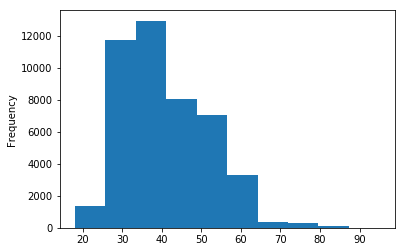

Min: 18
Max: 95


 balance


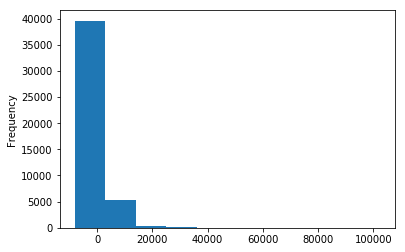

Min: -8019
Max: 102127


 campaign


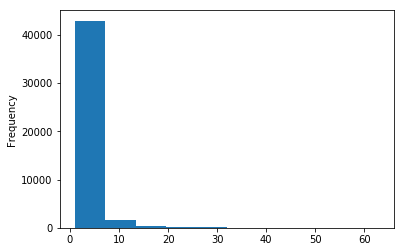

Min: 1
Max: 63


 pdays


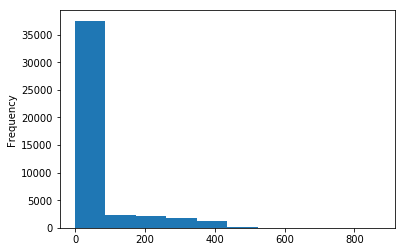

Min: -1
Max: 871


 previous


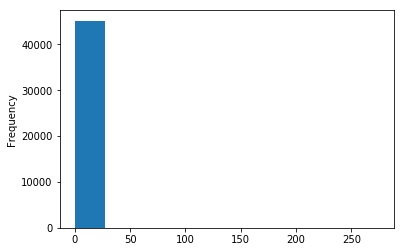

Min: 0
Max: 275


In [16]:
# plot histograms for all of the numerical variables to see distribution
for feature in numerical:
    interpret(feature, 'hist', True)

From the above analysis, it is evident that many of the variables in the dataset are heavily skewed towards smaller values but present vastly larger values, too. Therefore, it is important to normalize these features, since the algorithms can be very sensitive to these distributions.

- Age: Needs normalization to improve performance. 
- Balance: Needs normalization to improve performance. 
- Campaign: Needs normalization to improve performance.
- Pdays: Needs normalization to improve performance.
- Previous: Needs normalization to improve performance.

From an examination of the dataset description online (included at the beginning of the notebook), we can draw some conclusions about the numerical features:

- Age: Presents no abnormalities. 
- Balance: Presents no abnormalities. 
- Campaign: This refers to the number of calls during the current campaign (including the last call). Because the last call is the call that yielded the target variable (y/n), for realistic prediction purposes, we must subtract 1 from all the values to remove this last call.

In [17]:
# subtract 1 to all the values in the 'campaign' column
df['campaign'] = df['campaign'] - 1

- Pdays: This refers to the number of days that have elapsed since the last call was made to contact the client. Clients that were not previously contacted contain a value of -1. In the context of this problem, clients that were not previously contacted resemble clients that have been contacted again after a very long time. Therefore, it could make more sense to replace these -1 values with the greatest value of this feature (871), or even 999. This, however, would only result in a sort of bimodal distribution, and may even make all of these previously uncontacted clients outliers in the data. Therefore, it is more useful to first remove the outliers and then make this -1 value equal to, say, 2 times the max value.
- Previous: Presents no abnormalities.

#### Examination of numerical features: Identifying Outliers

To examine the presence of outliers, we can plot box plots and density plots for each feature.



 age


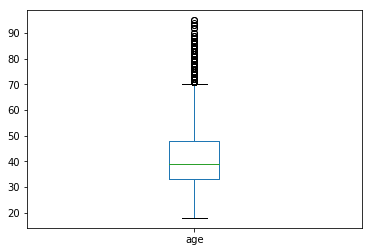

Min: 18
Max: 95


 balance


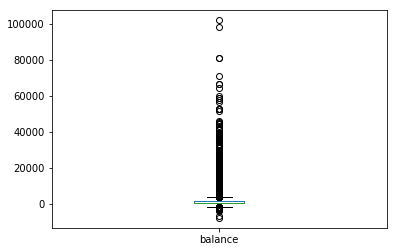

Min: -8019
Max: 102127


 campaign


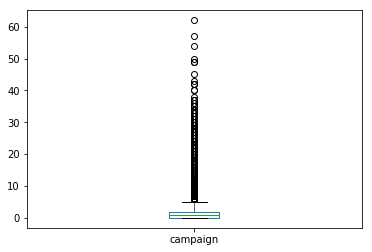

Min: 0
Max: 62


 pdays


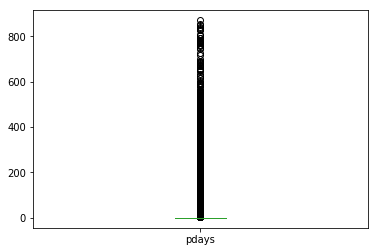

Min: -1
Max: 871


 previous


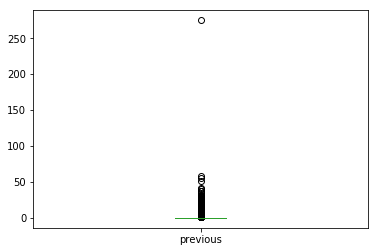

Min: 0
Max: 275


In [18]:
# Box plots
for feature in numerical:
    interpret(feature, 'box', True)



 age


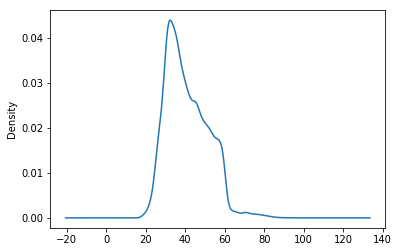



 balance


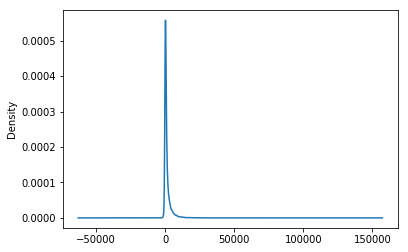



 campaign


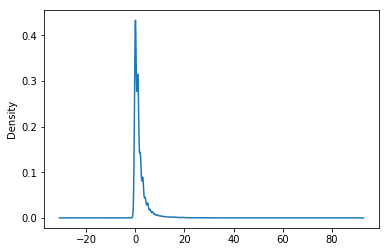



 pdays


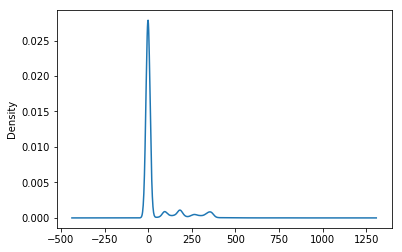



 previous


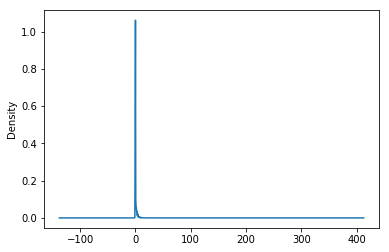

In [19]:
# Density plots
for feature in numerical:
    interpret(feature, 'density', False)

From both series of plots above, it becomes very evident that this dataset presents many outliers in its numerical features. This needs to be removed, since outliers can greatly affect the performance of our prediction models.

With respect to the variable 'pdays', we can see that there is a great concentration of clients around the value 0. This represents all the clients that were only contacted yesterday (pdays = 0) and the clients that had never been contacted before (pdays = -1). It doesn't seem logical to huddle both of these very different types of clients so closely together in the dataset. As discussed before, simply replacing the -1 values with 999 or the max value would only distort the data further. Granted, the statistics would change, and perhaps the outlier threshold would be incremented, too. However, this would only create a data 'abyss' between very small values (huddled close to 0) and very large values (all the 871s or 999s). Although this huge range can be scaled, it still distorts the data. Therefore, I see it fit to remove most of the outliers in the data, and then simply assign a value of 1.5 * the max value after the outliers have been removed. 

#### Examining Numerical Features: Removing Outliers

To identify outliers, I will use the widely-accepted statistical definition of an outlier, proposed by John Tukey:

According to Tukey's definition, outliers are points that lie outside the range:

[Q1 - k(Q3 - Q1), Q3 + k(Q3 - Q1)]

Where *Q3 - Q1* is the Interquartile Range (IQR) and *k* is a nonnegative number. For Tukey, a value *k = 1.5* identifies points that are 'outliers', while *k = 3* identifies points that are 'far out'.

In [20]:
# method to count outliers in a series 
def get_outliers(feature, k):
    feature_outliers = pd.DataFrame()
    Q3 = df[feature].quantile(0.75)
    Q1 = df[feature].quantile(0.25)
    iqr = Q3 - Q1
    for i in range(df.index.size):
        client = df.loc[i]
        if client[feature] < Q1 - k * iqr or client[feature] > Q3 + k * iqr:
            feature_outliers = feature_outliers.append(client)
    return feature_outliers

Now let's iterate over the numerical features in the dataframe and append the outliers in those features to another dataframe. After we've done this, let's drop the duplicates so that we are left with unique outlier samples (samples that are outliers in at least one feature)

In [21]:
# Select all outliers in the dataframe and drop duplicate rows. 
outliers = pd.DataFrame()

for feature in numerical:
    outliers = outliers.append(get_outliers(feature, 1.5))
    
outliers = outliers.drop_duplicates()

# Number of unique outliers in the data
print(outliers.shape[0], 'outliers in the data')

14804 outliers in the data


Before proceeding to drop the outliers from the dataset, it is important to consider that the dataset is imbalanced towards negative outcomes ('no'), with a proportion of 'yes'-to-'no' outcomes of roughly 1:7.5 (imbalance calculated towards the beginning of the notebook).

What would happen to this proportion if we did actually drop the outliers from the dataset?

In [22]:
# Calculate and report new value counts of target variable after having dropped outliers
val_counts_dropped = {'yes': df.y.value_counts()[1] - outliers.y.value_counts()[1], 
                      'no': df.y.value_counts()[0] - outliers.y.value_counts()[0]}

print(val_counts_dropped)
print('New ratio of "yes" to "no" is:', '1:{:.1f}'.format(val_counts_dropped['no'] / val_counts_dropped['yes']))

{'yes': 2684, 'no': 27723}
New ratio of "yes" to "no" is: 1:10.3


It is evidently very harmful for the dataset to increase this imbalance further. To alleviate this issue, I see two possible solutions:

1. Calculate the exact number of outliers with target variable 'yes' needed so that the proportion of 1:7.5 remains untouched.
2. Identify the 'outliers' within the outliers with target variable 'yes' (in order to shave off less clients with target variable 'yes') using *k = 1* instead of *k = 1.5* so that Tukey's range is slightly less lenient.
3. Identify the outliers with target variable 'yes' of the whole dataset again, this time using a slightly greater value of k (such as *k = 2*) so that the number of 'yes' outliers is slightly smaller.

The advantage of the first alternative is clearly that the proportion can remain untouched. However, by randomly selecting elements from the outlier list, I would be risking the appearance of a very large value in the dataset that would distort the model's predictions. This option can therefore be ruled out in favor of a more systematic solution. 

The second alternative is more systematic than the first, but still presents an important issue: the Q3, Q1, and IQR calculated will be calculated using the outlier data. This will make the final, resulting list of outliers not dropped from the dataset to be clustered around the IQR of the initial outliers. In the end, all I would be doing is eliminating the very large values and very small values of outlier dataset, but end up with outliers nonetheless in my original bank dataset. This, therefore, is not an option either.

The last option will be the one I use, then. This way, I will be making Tukey's range slightly more lenient to exclude less values as outliers, but I will still be avoiding the main complication of option 2. As a result, I will get slightly more data (including outliers, according to Tukey's *k=1.5* threshold, but not the *k = 2*) that is clustered around the data I *actually* want to use for prediction - non-outliers!

In [23]:
# For reference purposes, let's keep a count of the 'yes' and 'no' values in outliers
outliers.y.value_counts()

no     12199
yes     2605
Name: y, dtype: int64

In [24]:
# Separate outliers with 'yes' and 'no' target variables
outliers_y = outliers.loc[outliers.y == 'yes']
outliers_n = outliers.drop(outliers_y.index.values)
assert outliers_y.index.size == outliers.y.value_counts()[1] and outliers_n.index.size == outliers.y.value_counts()[0]

In [25]:
# Create a Data Frame with only the rows that contain the target variable 'yes' and check for equality
df_y = df.loc[df.y == 'yes']
assert df_y.index.size == df.y.value_counts()[1]

# Adaptation of method to count outliers in a series (this time using df_y instead of df)
def get_outliers_y(feature, k):
    feature_outliers = pd.DataFrame()
    Q3 = df_y[feature].quantile(0.75)
    Q1 = df_y[feature].quantile(0.25)
    iqr = Q3 - Q1
    for i in df_y.index.values:
        client = df_y.loc[i]
        if client[feature] < Q1 - k * iqr or client[feature] > Q3 + k * iqr:
            feature_outliers = feature_outliers.append(client)
    return feature_outliers

In [26]:
# Select all 'outliers' in df_y and drop duplicate rows. 
outliers_y = pd.DataFrame()

for feature in numerical:
    outliers_y = outliers_y.append(get_outliers_y(feature, 2))
    
outliers_y = outliers_y.drop_duplicates()

# Number of unique outliers in the data
print(outliers_y.shape[0], '"yes" outliers in the data')

1235 "yes" outliers in the data


In [27]:
# Calculate new proportion of 'yes'-to-'no' targets remaining in the data after removing outliers_n and outliers_y
new_val_counts_dropped = {'yes': df.y.value_counts()[1] - outliers_y.index.size, 
                          'no': df.y.value_counts()[0] - outliers_n.index.size}

print(new_val_counts_dropped)
print('New ratio of "yes" to "no" is:', '1:{:.1f}'.format(new_val_counts_dropped['no'] / new_val_counts_dropped['yes']))

{'yes': 4054, 'no': 27723}
New ratio of "yes" to "no" is: 1:6.8


This is very good. By removing the current outliers contained in outliers_n (ruled out using *k=1.5*) and outliers_y (using *k=2*) the proportion of 'yes' to 'no' targets drops from 1:7.5 to 1:6.8. 

Now we can proceed to drop these outliers from the actual data frame.

In [28]:
# drop 'no' outliers
df = df.drop(outliers_n.index.values)

# drop 'yes' outliers
df = df.drop(outliers_y.index.values)

In [29]:
# Check for equality between 'new_val_counts_dropped' (above) and df.y.value_counts() after dropping outliers
df.y.value_counts()

no     27723
yes     4054
Name: y, dtype: int64

As it can be seen above, the numbers coincide. After dropping outliers_y (*k=2*) and outliers_n (*k=1.5*) from the dataset, we end up with the same number of 'yes' and 'no' target features calculated above. 

In [30]:
# Reset Data Frame index for better presentation from now onwards
df.reset_index(drop=True, inplace=True)

#### Examining Numerical Features: Post-Outlier Removal

Now that we have successfully removed the outliers from the dataset, we can proceed to do two things:

1. Replace 'pdays' -1 values with 1.5 * pdays.max()
2. Examine the histogram, box, and density plots of all features.

In [31]:
# Replace -1 with new value in df.pdays
df.pdays = df.pdays.replace(to_replace=-1, value=1.5*df.pdays.max())



 age


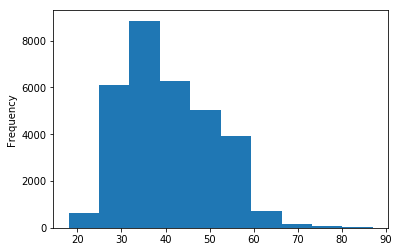

Min: 18
Max: 87


 balance


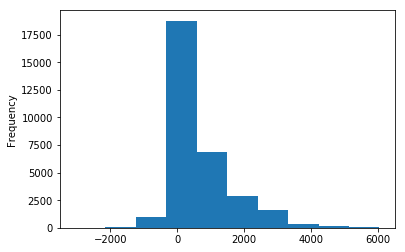

Min: -3058
Max: 6046


 campaign


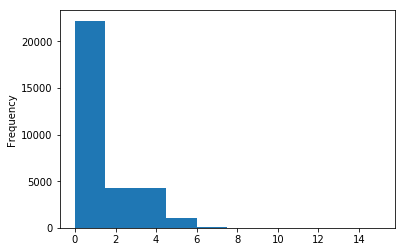

Min: 0
Max: 15


 pdays


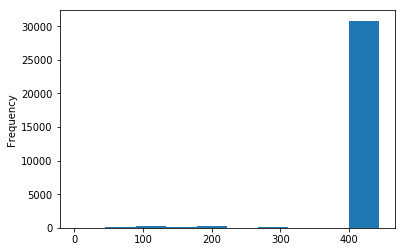

Min: 1
Max: 444


 previous


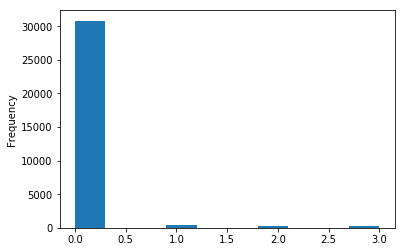

Min: 0
Max: 3


In [32]:
# Histogram plots
for feature in numerical:
    interpret(feature, 'hist', True)



 age


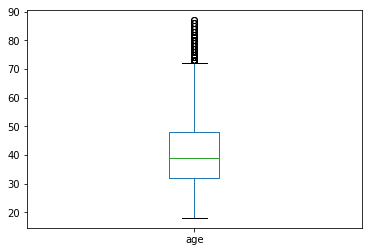

Min: 18
Max: 87


 balance


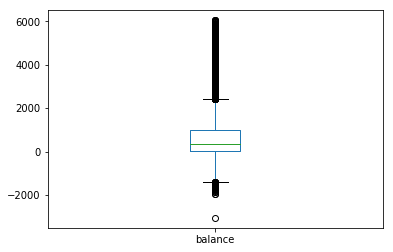

Min: -3058
Max: 6046


 campaign


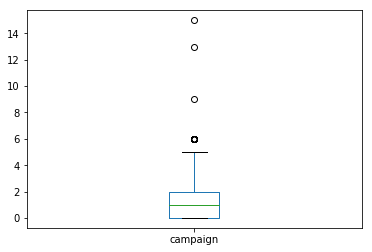

Min: 0
Max: 15


 pdays


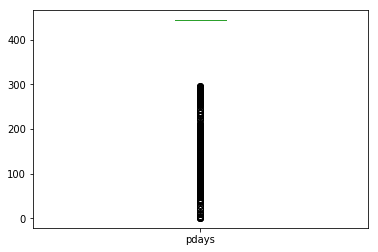

Min: 1
Max: 444


 previous


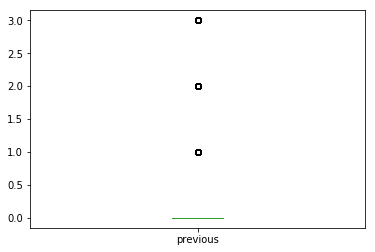

Min: 0
Max: 3


In [33]:
# Box plots
for feature in numerical:
    interpret(feature, 'box', True)



 age


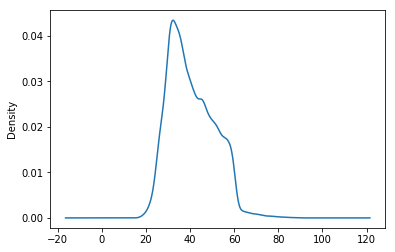



 balance


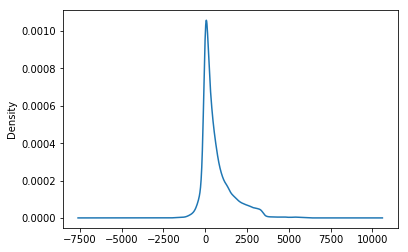



 campaign


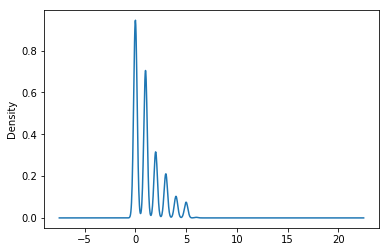



 pdays


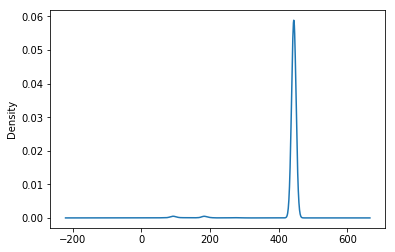



 previous


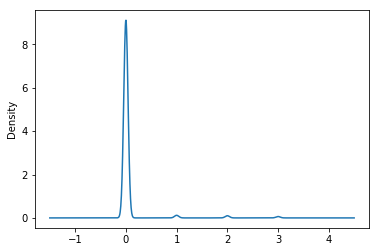

In [34]:
# Density plots
for feature in numerical:
    interpret(feature, 'density', False)

From the plots above, we can see that the data is a lot more centralized after having removed the outliers from the dataset. There is still a very pronounced skew in features such as 'pdays' and 'previous', but this is due to the nature of the data: approximately 30,000 people had never received a call before the call registered in the dataset, and that's whiy there's a spike; a similiar thing occurs with the 'previous' feature. 

Despite these spikes, the data is, in fact, more centralized, and we can proceed to transform it. 

## Pre-processing Features: Transformations

Having cleaned the data for use, we can now proceed to transform the features to optimize the model's performance. 

The three main transformations that I will be performing are as follows:

1. Transforming (numerical) skewed continuous features
2. Normalizing the (numerical) features using a scaler
3. One-hot encoding the categorical features.

#### Transforming Skewed Continuous Features

In the 'Finding Donors' project I was introduced to this concept. In that project, we used the transformation:
    
    lambda x: np.log(x + 1)
    
However, because I am dealing with negative values in features like 'balance', I cannot use this log approach for all features. 

Researching online, I found that a convenient way of attempting to transform skewed data is using a Box-Cox transformation. Essentially, what is done is that the data is transformed by elevating each feature to a specific value, lambda (more info on https://www.isixsigma.com/tools-templates/normality/tips-recognizing-and-transforming-non-normal-data/).

To determine the best value of lambda one should elevate the data to, one must look at the standard deviation produced by each transformation. Logically, the transformation that minimizes the standard deviation is the optimal one. 

I will therefore use a simple for-loop to test the transformation on 'dummy' feature series, and identify the one that produces the smallest standard deviation for each.

(Note: Because 0 cannot be elevated to a negative exponent nor can it be used as the argument of a logarithm, I added a small value (0.01) to each element.)

In [35]:
# Load the features onto a dummy data frame
import numpy as np
df_test = df[numerical]

In [36]:
# Initiate a dictionary and possible values of lambda
std = {}
lmbda = [-2.0, -0.5, 0.0, 0.5, 1.0, 2.0]

# Iterate over numerical features and each value of lambda for each feature
for feature in numerical:
    feature_std = {}
    for i in lmbda:
        dummy = df_test[feature]
        if i == 0.0:
            feature_std[str(i)] = dummy.apply(lambda x: np.log(x + 0.01)).std()
        else:
            feature_std[str(i)] = dummy.apply(lambda x: (x + 0.01) ** i).std()
    std[str(feature)] = feature_std

# Select best value of lambda for each feature
best_lmbda = dict((feature, min(std[feature], key=(lambda k: std[feature][k]))) for feature in numerical)
print(best_lmbda)

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/numpy/core/_methods.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
  return umr_sum(a, axis, dtype, out, keepdims)


{'age': '-2.0', 'balance': '-0.5', 'campaign': '0.5', 'pdays': '-2.0', 'previous': '0.5'}


Having identified the best value of lambda for each numerical feature, I can now transform all features with a simple for loop:

In [37]:
# Transform skewed features with best value of lambda:
for feature in numerical:
    df[feature] = df[feature].apply(lambda x: (x + 0.01) ** float(best_lmbda[feature])) 

#### Normalizing Numerical Features

In addition to the transformations applied on the skewed features, I will normalize them by using a scaler. This is a good practice that will further enhance the model's performance.

In [38]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
df[numerical] = scaler.fit_transform(df[numerical])

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


#### One-hot encoding categorical features

The last pre-processing step to be taken is simply to one-hot encode the many categorical features included in the dataset. Because the algorithms expect numerical features instead of categorical ones, we simply one-hot encode to create binary 'vectors' for each category.

The only categorical variable that does not need to be one-hot encoded is 'y', the target variable. For this one, we can simply replace 'yes' with 1 and 'no' with 0.

In [39]:
# Replace values in target variable
target = df.y.replace(to_replace=['yes', 'no'], value=[1, 0])

# Drop target variable from data set before one-hot encoding
features = df.drop('y', axis=1)

# One-hot encode features
features = pd.get_dummies(features)

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

53 total features after one-hot encoding.


In [40]:
# Check gist of features 
features.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31777 entries, 0 to 31776
Columns: 53 entries, age to poutcome_unknown
dtypes: float64(5), uint8(48)
memory usage: 2.7 MB


In [41]:
# Check gist of targets
target.value_counts()

0    27723
1     4054
Name: y, dtype: int64

Having finished the data pre-processing, we can now break it down into training and testing sets, apply PCA on it to reduce dimensionality, and then design and train both the benchmark model and the MLP.

## Data Shuffle & Split

This is a simple step that precedes the training of both the benchmark and MLP models.

80% of the data will be used for training and the remaining 20% will be used for testing.

In [42]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'target' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    target, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 25421 samples.
Testing set has 6356 samples.


## PCA Decomposition

Initially, I had believed it useful to first apply feature selection on the data and afterwards reduce the dimensionality of those features. In order to get the feature importances I would need to either train a Linear Regressor on the current dataset or use an SVC with a linear kernel, or any other model that allows one to calculate the importances of the different features in a dataset. 

Because this extra training step is computationally complex, I have decided to skip the feature selection and delve into PCA directly. This way, the dimensions found by PCA will be able to capture as many patterns in the data as possible. If I did apply feature selection beforehand, I would be hampering PCA's ability to do this. 

In [43]:
# Import PCA
from sklearn.decomposition import PCA

# Create PCA object that seeks to retain 95% of the variance and fit it to the training data
pca = PCA(n_components=0.95, random_state=42)
pca.fit(X_train)

# Transform X_train and X_test data using PCA
X_train_red = pca.transform(X_train)
X_test_red = pca.transform(X_test)

In [44]:
# PCA overview
print('Variance captured by PCA: {:.1f}%'.format(pca.n_components*100))
print('Principal Components shape:', pca.components_.shape)

# Compare training set dimensions before and after PCA
print('Training set dimensions: \nBefore PCA:', X_train.shape, '\nAfter PCA:', X_train_red.shape)

Variance captured by PCA: 95.0%
Principal Components shape: (27, 53)
Training set dimensions: 
Before PCA: (25421, 53) 
After PCA: (25421, 27)


As it can be seen above, PCA has effectively reduced the number of variables/features in the dataset from 53 to 27 (a reduction of nearly 50%). This is noteworthy because through PCA we have been able to capture 95% of the variance in the dataset with only half as many features. Computationally, this is very beneficial to the training and testing times of our models. 

## Benchmark Model Design & Training

For this project I will be using a Support Vector Machine Classifier as the benchmark model to which I will compare the MLP later.

For this SVC, I have decided to use an RBF kernel because it is more specific ('contours' of data clusters are more flexible) and less generic than other kernels such as 'poly' and 'linear'. In order to fine-tune it, I have decided to iterate over different combinations of hyperparameters C and gamma. In addition, I have kept the number of folds at 3, which is the default, in order to avoid elongating the training times further.

For comparison purposes, I have decided to train the benchmark model on both the full training set (X_train) and the PCA-reduced training set (X_train_red). This is unnecessary from a practical standpoint, but it does help to better understand how the data reduction step affects the training process.  

My hypothesis is that the PCA-reduced training set will take considerably less time to train, but due to the fact it is essentially the same data as the full training set, the model's performance after training and testing will not differ vastly from those of the model trained on the full training set. 

In [45]:
# Import SVC classifier, etc.
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score, cohen_kappa_score

# Create classifier, scorer, and parameter grid
classifier = SVC(kernel = 'rbf', random_state=42)
f2_score = make_scorer(fbeta_score, beta=2)
cohen_score = make_scorer(cohen_kappa_score)
scores = {'F2-Score': f2_score, 
          "Cohen's Kappa": cohen_score}
params = {'C':[0.001, 0.01, 0.1, 1, 10], 
          'gamma':[0.001, 0.01, 0.1, 1]}

# Create GSCV object
grid = GridSearchCV(classifier, param_grid=params, scoring=scores, refit='F2-Score', verbose=4)

# Fit grid to FULL data
grid_result = grid.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] C=0.001, gamma=0.001 ............................................


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.001, gamma=0.001, F2-Score=0.0, Cohen's Kappa=0.0, total=  13.1s
[CV] C=0.001, gamma=0.001 ............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.3s remaining:    0.0s
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.001, gamma=0.001, F2-Score=0.0, Cohen's Kappa=0.0, total=  13.1s
[CV] C=0.001, gamma=0.001 ............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   50.5s remaining:    0.0s
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.001, gamma=0.001, F2-Score=0.0, Cohen's Kappa=0.0, total=  13.1s
[CV] C=0.001, gamma=0.01 .............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.3min remaining:    0.0s
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.001, gamma=0.01, F2-Score=0.0, Cohen's Kappa=0.0, total=  13.0s
[CV] C=0.001, gamma=0.01 .............................................


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.001, gamma=0.01, F2-Score=0.0, Cohen's Kappa=0.0, total=  13.1s
[CV] C=0.001, gamma=0.01 .............................................


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.001, gamma=0.01, F2-Score=0.0, Cohen's Kappa=0.0, total=  13.0s
[CV] C=0.001, gamma=0.1 ..............................................


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.001, gamma=0.1, F2-Score=0.0, Cohen's Kappa=0.0, total=  13.3s
[CV] C=0.001, gamma=0.1 ..............................................


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.001, gamma=0.1, F2-Score=0.0, Cohen's Kappa=0.0, total=  13.3s
[CV] C=0.001, gamma=0.1 ..............................................


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.001, gamma=0.1, F2-Score=0.0, Cohen's Kappa=0.0, total=  13.4s
[CV] C=0.001, gamma=1 ................................................


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.001, gamma=1, F2-Score=0.0, Cohen's Kappa=0.0, total=  13.3s
[CV] C=0.001, gamma=1 ................................................


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.001, gamma=1, F2-Score=0.0, Cohen's Kappa=0.0, total=  13.3s
[CV] C=0.001, gamma=1 ................................................


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.001, gamma=1, F2-Score=0.0, Cohen's Kappa=0.0, total=  13.3s
[CV] C=0.01, gamma=0.001 .............................................


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.01, gamma=0.001, F2-Score=0.0, Cohen's Kappa=0.0, total=  13.1s
[CV] C=0.01, gamma=0.001 .............................................


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.01, gamma=0.001, F2-Score=0.0, Cohen's Kappa=0.0, total=  13.1s
[CV] C=0.01, gamma=0.001 .............................................


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.01, gamma=0.001, F2-Score=0.0, Cohen's Kappa=0.0, total=  13.0s
[CV] C=0.01, gamma=0.01 ..............................................


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.01, gamma=0.01, F2-Score=0.0, Cohen's Kappa=0.0, total=  13.1s
[CV] C=0.01, gamma=0.01 ..............................................


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.01, gamma=0.01, F2-Score=0.0, Cohen's Kappa=0.0, total=  13.2s
[CV] C=0.01, gamma=0.01 ..............................................


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.01, gamma=0.01, F2-Score=0.0, Cohen's Kappa=0.0, total=  13.1s
[CV] C=0.01, gamma=0.1 ...............................................


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.01, gamma=0.1, F2-Score=0.0, Cohen's Kappa=0.0, total=  16.8s
[CV] C=0.01, gamma=0.1 ...............................................
[CV]  C=0.01, gamma=0.1, F2-Score=0.002303086135421465, Cohen's Kappa=0.003210201742215313, total=  16.8s
[CV] C=0.01, gamma=0.1 ...............................................


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.01, gamma=0.1, F2-Score=0.0, Cohen's Kappa=0.0, total=  16.6s
[CV] C=0.01, gamma=1 .................................................


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.01, gamma=1, F2-Score=0.0, Cohen's Kappa=0.0, total=  30.2s
[CV] C=0.01, gamma=1 .................................................


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.01, gamma=1, F2-Score=0.0, Cohen's Kappa=0.0, total=  30.3s
[CV] C=0.01, gamma=1 .................................................


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.01, gamma=1, F2-Score=0.0, Cohen's Kappa=0.0, total=  30.3s
[CV] C=0.1, gamma=0.001 ..............................................


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.1, gamma=0.001, F2-Score=0.0, Cohen's Kappa=0.0, total=  13.1s
[CV] C=0.1, gamma=0.001 ..............................................


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.1, gamma=0.001, F2-Score=0.0, Cohen's Kappa=0.0, total=  13.2s
[CV] C=0.1, gamma=0.001 ..............................................


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.1, gamma=0.001, F2-Score=0.0, Cohen's Kappa=0.0, total=  13.1s
[CV] C=0.1, gamma=0.01 ...............................................
[CV]  C=0.1, gamma=0.01, F2-Score=0.2897764271760365, Cohen's Kappa=0.36274339096505825, total=  15.8s
[CV] C=0.1, gamma=0.01 ...............................................
[CV]  C=0.1, gamma=0.01, F2-Score=0.27027027027027023, Cohen's Kappa=0.3406815706208829, total=  15.6s
[CV] C=0.1, gamma=0.01 ...............................................
[CV]  C=0.1, gamma=0.01, F2-Score=0.2764475402699173, Cohen's Kappa=0.3476974184297871, total=  15.7s
[CV] C=0.1, gamma=0.1 ................................................
[CV]  C=0.1, gamma=0.1, F2-Score=0.2897764271760365, Cohen's Kappa=0.36274339096505825, total=  16.6s
[CV] C=0.1, gamma=0.1 ................................................
[CV]  C=0.1, gamma=0.1, F2-Score=0.27027027027027023, Cohen's Kappa=0.3406815706208829, total=  16.3s
[CV] C=0.1, gamma=0.1 ......................................

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.1, gamma=1, F2-Score=0.0, Cohen's Kappa=0.0, total=  55.2s
[CV] C=0.1, gamma=1 ..................................................


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.1, gamma=1, F2-Score=0.0, Cohen's Kappa=0.0, total=  44.7s
[CV] C=0.1, gamma=1 ..................................................


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.1, gamma=1, F2-Score=0.0, Cohen's Kappa=0.0, total=  56.4s
[CV] C=1, gamma=0.001 ................................................
[CV]  C=1, gamma=0.001, F2-Score=0.2897764271760365, Cohen's Kappa=0.36274339096505825, total=  13.0s
[CV] C=1, gamma=0.001 ................................................
[CV]  C=1, gamma=0.001, F2-Score=0.27027027027027023, Cohen's Kappa=0.3406815706208829, total=  13.1s
[CV] C=1, gamma=0.001 ................................................
[CV]  C=1, gamma=0.001, F2-Score=0.2764475402699173, Cohen's Kappa=0.3476974184297871, total=  12.9s
[CV] C=1, gamma=0.01 .................................................
[CV]  C=1, gamma=0.01, F2-Score=0.2897764271760365, Cohen's Kappa=0.36274339096505825, total=  15.6s
[CV] C=1, gamma=0.01 .................................................
[CV]  C=1, gamma=0.01, F2-Score=0.27027027027027023, Cohen's Kappa=0.3406815706208829, total=  15.5s
[CV] C=1, gamma=0.01 ..............................................

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 37.9min finished


In [46]:
# Observe best performance
print('Best performance: F-2 Score of {:.2f} with parameters: {}'.format(grid_result.best_score_, grid_result.best_params_))

Best performance: F-2 Score of 0.40 with parameters: {'C': 10, 'gamma': 0.1}


Having our model in place, we can proceed to predict the training and testing set targets with it to view its performance (on the full training and testing data):

In [47]:
# Create 'semi' benchmark model (because it was trained on the full dataset, it is not the actual benchmark model)
semi_benchmark = grid_result.best_estimator_

# Predict training and testing sets to observe performance
semi_benchmark_train_predict = semi_benchmark.predict(X_train)
semi_benchmark_test_predict = semi_benchmark.predict(X_test)

# Print out metrics used during training
print("F-2 & Cohen's Kappa:\n")
print("Training set F2-Score: {:.2f} \nTraining set Cohen's Kappa: {:.2f} \n".format(fbeta_score(y_train, semi_benchmark_train_predict, beta=2),
                                                                                   cohen_kappa_score(y_train, semi_benchmark_train_predict)))
print("Testing set F2-Score: {:.2f} \nTesting set Cohen's Kappa: {:.2f} \n\n".format(fbeta_score(y_test, semi_benchmark_test_predict, beta=2),
                                                                                   cohen_kappa_score(y_test, semi_benchmark_test_predict)))

# Print out accuracy (accuracy isn't a good metric to use during training for the purposes of this problem,
# but we can use it here post-mortem to view performance)
from sklearn.metrics import accuracy_score
print("Accuracy Score:\n")
print("Training set Accuracy: {:.2f}".format(accuracy_score(y_train, semi_benchmark_train_predict)))
print("Testing set Accuracy: {:.2f}".format(accuracy_score(y_test, semi_benchmark_test_predict)))

F-2 & Cohen's Kappa:

Training set F2-Score: 0.46 
Training set Cohen's Kappa: 0.52 

Testing set F2-Score: 0.41 
Testing set Cohen's Kappa: 0.45 


Accuracy Score:

Training set Accuracy: 0.92
Testing set Accuracy: 0.91


As it would be expected, the model performs better on the training set than it does on the testing set, according to the metrics used during training. This it does, however, by a very tight margin. 

Otherwise, it is very positive to note that the accuracy of the model on the training and testing sets is nearly identical. This means that the model has neither underfit (low training and testing accuracies) nor overfit (high training and low testing accuracies). 

It is worth noting that this predictive accuracy far surpasses the bibliographical figure of cold-calling's 13% average success rate. According to this benchmark model, one could predict with 91% accuracy whether a call will be successful or unsuccessful, making the success rate effectively 91%. 

Will this performance be maintained by a model trained on the reduced data set?

In [48]:
# Create new GSCV object (identical to the one used for training the model on the full dataset)
grid_red = GridSearchCV(classifier, param_grid=params, scoring=scores, refit='F2-Score', verbose=4)

# Fit grid to PCA-REDUCED data
grid_red_result = grid_red.fit(X_train_red, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] C=0.001, gamma=0.001 ............................................


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.001, gamma=0.001, F2-Score=0.0, Cohen's Kappa=0.0, total=   9.0s
[CV] C=0.001, gamma=0.001 ............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.0s remaining:    0.0s
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.001, gamma=0.001, F2-Score=0.0, Cohen's Kappa=0.0, total=   9.0s
[CV] C=0.001, gamma=0.001 ............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   34.0s remaining:    0.0s
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.001, gamma=0.001, F2-Score=0.0, Cohen's Kappa=0.0, total=   9.0s
[CV] C=0.001, gamma=0.01 .............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   50.9s remaining:    0.0s
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.001, gamma=0.01, F2-Score=0.0, Cohen's Kappa=0.0, total=   9.0s
[CV] C=0.001, gamma=0.01 .............................................


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.001, gamma=0.01, F2-Score=0.0, Cohen's Kappa=0.0, total=   8.9s
[CV] C=0.001, gamma=0.01 .............................................


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.001, gamma=0.01, F2-Score=0.0, Cohen's Kappa=0.0, total=   9.0s
[CV] C=0.001, gamma=0.1 ..............................................


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.001, gamma=0.1, F2-Score=0.0, Cohen's Kappa=0.0, total=   9.3s
[CV] C=0.001, gamma=0.1 ..............................................


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.001, gamma=0.1, F2-Score=0.0, Cohen's Kappa=0.0, total=   9.3s
[CV] C=0.001, gamma=0.1 ..............................................


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.001, gamma=0.1, F2-Score=0.0, Cohen's Kappa=0.0, total=   9.3s
[CV] C=0.001, gamma=1 ................................................


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.001, gamma=1, F2-Score=0.0, Cohen's Kappa=0.0, total=   9.1s
[CV] C=0.001, gamma=1 ................................................


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.001, gamma=1, F2-Score=0.0, Cohen's Kappa=0.0, total=   9.0s
[CV] C=0.001, gamma=1 ................................................


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.001, gamma=1, F2-Score=0.0, Cohen's Kappa=0.0, total=   9.0s
[CV] C=0.01, gamma=0.001 .............................................


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.01, gamma=0.001, F2-Score=0.0, Cohen's Kappa=0.0, total=   8.9s
[CV] C=0.01, gamma=0.001 .............................................


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.01, gamma=0.001, F2-Score=0.0, Cohen's Kappa=0.0, total=   9.0s
[CV] C=0.01, gamma=0.001 .............................................


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.01, gamma=0.001, F2-Score=0.0, Cohen's Kappa=0.0, total=   9.0s
[CV] C=0.01, gamma=0.01 ..............................................


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.01, gamma=0.01, F2-Score=0.0, Cohen's Kappa=0.0, total=   9.9s
[CV] C=0.01, gamma=0.01 ..............................................


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.01, gamma=0.01, F2-Score=0.0, Cohen's Kappa=0.0, total=  10.0s
[CV] C=0.01, gamma=0.01 ..............................................


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.01, gamma=0.01, F2-Score=0.0, Cohen's Kappa=0.0, total=   9.7s
[CV] C=0.01, gamma=0.1 ...............................................
[CV]  C=0.01, gamma=0.1, F2-Score=0.018365472910927456, Cohen's Kappa=0.02543777112245793, total=  10.5s
[CV] C=0.01, gamma=0.1 ...............................................
[CV]  C=0.01, gamma=0.1, F2-Score=0.02635801054320422, Cohen's Kappa=0.036394018298194775, total=  10.5s
[CV] C=0.01, gamma=0.1 ...............................................
[CV]  C=0.01, gamma=0.1, F2-Score=0.02065167508031207, Cohen's Kappa=0.028578247037954085, total=  10.5s
[CV] C=0.01, gamma=1 .................................................


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.01, gamma=1, F2-Score=0.0, Cohen's Kappa=0.0, total=  16.5s
[CV] C=0.01, gamma=1 .................................................


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.01, gamma=1, F2-Score=0.0, Cohen's Kappa=0.0, total=  16.9s
[CV] C=0.01, gamma=1 .................................................


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] . C=0.01, gamma=1, F2-Score=0.0, Cohen's Kappa=0.0, total=  17.2s
[CV] C=0.1, gamma=0.001 ..............................................


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.1, gamma=0.001, F2-Score=0.0, Cohen's Kappa=0.0, total=   9.8s
[CV] C=0.1, gamma=0.001 ..............................................


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.1, gamma=0.001, F2-Score=0.0, Cohen's Kappa=0.0, total=   9.8s
[CV] C=0.1, gamma=0.001 ..............................................


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.1, gamma=0.001, F2-Score=0.0, Cohen's Kappa=0.0, total=   9.8s
[CV] C=0.1, gamma=0.01 ...............................................
[CV]  C=0.1, gamma=0.01, F2-Score=0.2897764271760365, Cohen's Kappa=0.36274339096505825, total=  10.1s
[CV] C=0.1, gamma=0.01 ...............................................
[CV]  C=0.1, gamma=0.01, F2-Score=0.27027027027027023, Cohen's Kappa=0.3406815706208829, total=  10.1s
[CV] C=0.1, gamma=0.01 ...............................................
[CV]  C=0.1, gamma=0.01, F2-Score=0.2764475402699173, Cohen's Kappa=0.3476974184297871, total=  10.1s
[CV] C=0.1, gamma=0.1 ................................................
[CV]  C=0.1, gamma=0.1, F2-Score=0.2897764271760365, Cohen's Kappa=0.36274339096505825, total=  10.2s
[CV] C=0.1, gamma=0.1 ................................................
[CV]  C=0.1, gamma=0.1, F2-Score=0.27027027027027023, Cohen's Kappa=0.3406815706208829, total=  10.0s
[CV] C=0.1, gamma=0.1 ......................................

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 22.9min finished


In [49]:
# Observe best performance
print('Best performance: F-2 Score of {:.2f} with parameters: {}'.format(grid_red_result.best_score_, grid_red_result.best_params_))

Best performance: F-2 Score of 0.34 with parameters: {'C': 10, 'gamma': 0.1}


As it can be seen above, both the model trained on the full dataset and the model trained on the reduced dataset converged on the same ideal combination of hyperparameters. In addition, the model trained on the reduced dataset took significantly less time (nearly half as long, which is to be expected since the reduced data contained nearly half as many features). 

Let's now observe the perfomance of this model, and compare it to the last model's:

In [50]:
# Create benchmark model (actually trained on the reduced dataset)
benchmark = grid_red_result.best_estimator_

# Predict training and testing sets to observe performance
benchmark_train_predict = benchmark.predict(X_train_red)
benchmark_test_predict = benchmark.predict(X_test_red)

# Print out metrics used during training
print("F-2 & Cohen's Kappa:\n")
print("Training set F2-Score: {:.2f} \nTraining set Cohen's Kappa: {:.2f} \n".format(fbeta_score(y_train, benchmark_train_predict, beta=2),
                                                                                   cohen_kappa_score(y_train, benchmark_train_predict)))
print("Testing set F2-Score: {:.2f} \nTesting set Cohen's Kappa: {:.2f} \n\n".format(fbeta_score(y_test, benchmark_test_predict, beta=2),
                                                                                   cohen_kappa_score(y_test, benchmark_test_predict)))

# Print out accuracy (accuracy isn't a good metric to use during training for the purposes of this problem,
# but we can use it here post-mortem to view performance)
print("Accuracy Score:\n")
print("Training set Accuracy: {:.2f}".format(accuracy_score(y_train, benchmark_train_predict)))
print("Testing set Accuracy: {:.2f}".format(accuracy_score(y_test, benchmark_test_predict)))

F-2 & Cohen's Kappa:

Training set F2-Score: 0.37 
Training set Cohen's Kappa: 0.44 

Testing set F2-Score: 0.34 
Testing set Cohen's Kappa: 0.40 


Accuracy Score:

Training set Accuracy: 0.91
Testing set Accuracy: 0.90


My hypothesis was correct: the training time for the model trained on the reduced data (X_train_red) is considerably shorter than the other model's training time. In addition, the difference in results is almost negligible: a mere 11% increase in both F-2 Score and Cohen's Kappa, compared to a 50% reduction in training time. What is more, in terms of accuracy, both models performed nearly identically on both the training and testing sets, differing by only 1% in results.

From this analysis it follows that it is unnecessary from a performance standpoint to train the MLP on the full training set, since the computational cost saved by training it on the PCA-reduced data will yield very close results in F-2 Score and Cohen's Kappa, and nearly identical ones in accuracy.

Therefore, we can conclude that we have arrived at a good benchmark model to compare the ensuing MLP to, using the reduced data for a more computationally-effective training and testing process.

## MLP Model Design & Training

Having completed the design, training, and testing of the benchmark model, we can now proceed to design, train, and test the MLP to outperform the benchmark. 

Designing an MLP from scratch is something of an art in and of itself, and there is evidently no single correct answer to how an MLP could be built. The abundance of hyperparameters that can be tuned, as well as the number of epochs or even batch size make it all the more complicated. Grid Search Cross Validation is a method that facilitates this process somewhat, as it did with the training of the SVC above. 

In the realm of MLPs, however, it is not as simple as fine-tuning two different hyperparameters. Therefore, I will be using Grid Search CV to fine-tune:
 
    1. Nodes: The number of nodes to be included in the hidden layers of the network. 
    2. Dropout: The proportion of nodes to be dropped in the dropout layer.
    3. Penalty: The penalty used by the L2 regularizer
    4. Batch_Size: The size of the sample group on which the model is trained to perform one update to the weights.

Although one can fine-tune the above parameters, this does not ensure that the number of hidden layers included in the network is the ideal one. Therefore, I carried out an exploration of the possible different architectures in another notebook (Architecture_Exploration). In this notebook I designed, trained, and tested 35 possible different combinations, and selected the two best from my observations of their performance. Having these in place, I will now run them through the same Grid Search CV procedure in order to find the ideal combination of hyperparameters corresponding to each specific architecture. Once I have the best possible performance for both, I can choose the architecture with the combination of hyperparameters that maximizes performance. 

The two architectures that I will use are each defined below in a constructor method passed to a wrapper from keras.wrappers.scikit_learn. Both architectures include three densely-connected hidden layers, but differ as follows: 

1. The first architecture includes only two hidden dropout layers, and uses RMSprop as optimizer.

2. The second architecture includes three hidden dropout layers, and uses Adamax as optimizer. 

I am aware that the exploratory process carried out in the Architecture_Exploration notebook is only a minute search through the infinite possibilities that abound in the realm of ML. However, it is computationally expensive and practically unfeasible to attempt to devise tens or hundreds of architectures and fine-tune them all. 

Lastly, it must be noted that all the models I have devised include a kernel regularizer in their hidden layers as well as a ReLU activation function. The final activation function is a sigmoid in both model architectures because this is essentially a logistic regression (classification) problem, and so a logistic activation function will work well. Softmax could also work in its place (by calculating different probabilities of each call being successful or unsuccessful), but since Sigmoid is a simpler mathematical function (logistic), it is the natural choice in this case. 

I will include a ModelChekpoint callback to save the best weights during training after I have found the best-performing model. This is because the Keras Wrapper for GSCV in Scikit learn only helps find the best combination of hyperparameters, but does not permit one to 'extract' the best model like so:
    
        best_model = grid_search.best_estimator_
        
Therefore, I will use it later when I have found the best model architecture with the best combination of hyperparameters, to train it and save the best weights. 

In [51]:
# Import and set random seeds for reproducible results
from numpy.random import seed
seed(42)

In [52]:
# Import wrapper
from keras.wrappers.scikit_learn import KerasClassifier

# Import necessary keras elements
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import ReduceLROnPlateau
from keras import regularizers

In order to be able to use the F-2 Score on Keras, it is necessary to create a custom metric function. This is because Keras works with tensors and expects tensor inputs and outputs in its metrics. Therefore, Scikit Learn's F2 metric used previously would not work. 

For this reason, I kindly borrowed a block of code written by Arseny Kravchenko on GitHub entitled 'F-beta score for Keras', which can be found through: https://www.kaggle.com/arsenyinfo/f-beta-score-for-keras

I took the liberty of modifying the name of the method slightly for the sake of clarity, changing it from 'fbeta' to 'f_2'.

Kravchenko's code can be found below:

In [53]:
### FULL CREDIT TO ARSENY KRAVCHENKO FOR THE CODE BELOW

import numpy as np
from sklearn.metrics import fbeta_score
from keras import backend as K


def f_2(y_true, y_pred, threshold_shift=0):
    beta = 2

    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

#### Defining Architectures

In [68]:
# Model 1 architecture
def build_model_1(nodes, penalty, dropout):
    # Achitecture
    model = Sequential()
    
    model.add(Dense(units=X_train_red.shape[1], input_dim=X_train_red.shape[1], activation='relu'))
    model.add(Dense(nodes, activation='relu', kernel_regularizer=regularizers.l2(penalty)))
    model.add(Dropout(dropout)) 
    model.add(Dense(nodes + 5, activation='relu', kernel_regularizer=regularizers.l2(penalty)))
    model.add(Dropout(dropout))
    model.add(Dense(nodes + 10, activation='relu', kernel_regularizer=regularizers.l2(penalty)))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile
    model.compile(loss='binary_crossentropy', 
                  optimizer='rmsprop', 
                  metrics=[f_2, 'accuracy'])
    return model

In [69]:
# Model 2 architecture
def build_model_2(nodes, penalty, dropout):
    # Architecture
    model = Sequential()
    model.add(Dense(units=X_train_red.shape[1], input_dim=X_train_red.shape[1], activation='relu'))
    model.add(Dense(nodes, activation='relu', kernel_regularizer=regularizers.l2(penalty)))
    model.add(Dropout(dropout)) 
    model.add(Dense(nodes + 5, activation='relu', kernel_regularizer=regularizers.l2(penalty)))
    model.add(Dropout(dropout)) 
    model.add(Dense(nodes + 10, activation='relu', kernel_regularizer=regularizers.l2(penalty)))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile
    model.compile(loss='binary_crossentropy', 
                  optimizer='adamax', 
                  metrics=[f_2, 'accuracy'])
    return model

Having defined both different architectures, we can now proceed to train, fine-tune, test, and compare them:

#### Preambular definitions

In [70]:
# Define parameters
parameters = {'nodes':[10, 15, 20], 
              'penalty':[0.01, 0.001],
              'dropout':[0.2, 0.3],
              'batch_size':[40, 80],}

# Scores used for the GSCV objects will be the same as those used for the SVC fine-tuning, and
# so do not need to be defined again. 

#### Model 1: Grid Search Cross-Validation

In [71]:
# Wrap model in wrapper
classifier = KerasClassifier(build_fn=build_model_1)
    
# Define grid (scores used are the same as the scores used in GSCV for the SVC benchmark model)
mlp1_grid = GridSearchCV(estimator=classifier, 
                    param_grid=parameters, 
                    scoring=scores, 
                    refit='F2-Score', verbose=2)

# Train grid, passing fit_params of keras.models.Sequential.fit here
mlp1_grid_result = mlp1_grid.fit(X_train_red, y_train, epochs=50, 
                                 verbose=2, shuffle=True, 
                                 validation_split=0.2)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] batch_size=40, dropout=0.2, nodes=10, penalty=0.01 ..............
Train on 13557 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 57s - loss: 0.5879 - f_2: 0.0182 - acc: 0.8588 - val_loss: 0.4085 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3821 - f_2: 3.1119e-08 - acc: 0.8753 - val_loss: 0.3660 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3566 - f_2: 3.0450e-08 - acc: 0.8753 - val_loss: 0.3497 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3454 - f_2: 0.0030 - acc: 0.8753 - val_loss: 0.3410 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3402 - f_2: 0.0059 - acc: 0.8753 - val_loss: 0.3373 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3357 - f_2: 0.0284 - acc: 0.8784 - val_loss: 0.3315 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3313 - f_2: 0.1425 - acc: 0.8902 - val_loss: 0.3291 - val_f_2: 0.0310 - val_acc: 0.8702
Epoch 8/50
 - 1s - loss: 0.3288 - f_2: 0.1708 - acc: 0.8933 - val_loss: 0.3318 - val_f_2: 0.0095 - val_acc: 0.8678
Epoch 9/50
 - 1s - loss: 0.3265 - f_2: 0.1837 - acc: 0.893

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min remaining:    0.0s
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.5911 - f_2: 0.0115 - acc: 0.8572 - val_loss: 0.4104 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3835 - f_2: 2.9101e-08 - acc: 0.8722 - val_loss: 0.3636 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3566 - f_2: 0.0030 - acc: 0.8722 - val_loss: 0.3484 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3454 - f_2: 3.0078e-08 - acc: 0.8722 - val_loss: 0.3407 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3390 - f_2: 0.0125 - acc: 0.8731 - val_loss: 0.3352 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3364 - f_2: 0.1375 - acc: 0.8867 - val_loss: 0.3322 - val_f_2: 0.0503 - val_acc: 0.8729
Epoch 7/50
 - 1s - loss: 0.3330 - f_2: 0.1749 - acc: 0.8899 - val_loss: 0.3301 - val_f_2: 0.1442 - val_acc: 0.8844
Epoch 8/50
 - 1s - loss: 0.3298 - f_2: 0.1684 - acc: 0.8904 - val_loss: 0.3272 - val_f_2: 0.2167 - val_acc: 0.8932
Epoch 9/50
 - 1s - loss: 0.3294 - f_2: 0.1823 - acc: 0.8912 - v

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.5944 - f_2: 0.0165 - acc: 0.8523 - val_loss: 0.3927 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 2/50
 - 1s - loss: 0.3906 - f_2: 0.0059 - acc: 0.8691 - val_loss: 0.3463 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 3/50
 - 1s - loss: 0.3659 - f_2: 2.9867e-08 - acc: 0.8691 - val_loss: 0.3326 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 4/50
 - 1s - loss: 0.3532 - f_2: 0.0030 - acc: 0.8691 - val_loss: 0.3240 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 5/50
 - 1s - loss: 0.3451 - f_2: 2.9998e-08 - acc: 0.8691 - val_loss: 0.3208 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 6/50
 - 1s - loss: 0.3413 - f_2: 0.1119 - acc: 0.8816 - val_loss: 0.3176 - val_f_2: 0.0066 - val_acc: 0.8802
Epoch 7/50
 - 1s - loss: 0.3403 - f_2: 0.1605 - acc: 0.8866 - val_loss: 0.3137 - val_f_2: 0.1170 - val_acc: 0.8906
Epoch 8/50
 - 1s - loss: 0.3372 - f_2: 0.1791 - acc: 0.8883 - val_loss: 0.3121 - val_f_2: 0.2399 - val_acc: 0.9044
Epoch 9/50
 - 1s - loss: 0.3345 - f_2: 0.1680 - acc: 0.8877 - v

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4218 - f_2: 0.0113 - acc: 0.8598 - val_loss: 0.3477 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3417 - f_2: 0.1692 - acc: 0.8922 - val_loss: 0.3195 - val_f_2: 0.2859 - val_acc: 0.9012
Epoch 3/50
 - 1s - loss: 0.3224 - f_2: 0.2489 - acc: 0.8973 - val_loss: 0.3074 - val_f_2: 0.3307 - val_acc: 0.9012
Epoch 4/50
 - 1s - loss: 0.3144 - f_2: 0.2941 - acc: 0.9009 - val_loss: 0.3030 - val_f_2: 0.3351 - val_acc: 0.8988
Epoch 5/50
 - 1s - loss: 0.3079 - f_2: 0.3232 - acc: 0.9030 - val_loss: 0.3012 - val_f_2: 0.3623 - val_acc: 0.9003
Epoch 6/50
 - 1s - loss: 0.3029 - f_2: 0.3259 - acc: 0.9048 - val_loss: 0.2996 - val_f_2: 0.3848 - val_acc: 0.9003
Epoch 7/50
 - 1s - loss: 0.3022 - f_2: 0.3456 - acc: 0.9060 - val_loss: 0.2973 - val_f_2: 0.3476 - val_acc: 0.8994
Epoch 8/50
 - 1s - loss: 0.2999 - f_2: 0.3397 - acc: 0.9046 - val_loss: 0.2984 - val_f_2: 0.3777 - val_acc: 0.9006
Epoch 9/50
 - 1s - loss: 0.2967 - f_2: 0.3514 - acc: 0.9068 - val_loss: 0.2965 - val_f_

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4210 - f_2: 0.0205 - acc: 0.8582 - val_loss: 0.3476 - val_f_2: 0.0336 - val_acc: 0.8705
Epoch 2/50
 - 1s - loss: 0.3391 - f_2: 0.2119 - acc: 0.8942 - val_loss: 0.3179 - val_f_2: 0.3059 - val_acc: 0.9027
Epoch 3/50
 - 1s - loss: 0.3210 - f_2: 0.2690 - acc: 0.8972 - val_loss: 0.3072 - val_f_2: 0.3603 - val_acc: 0.8997
Epoch 4/50
 - 1s - loss: 0.3109 - f_2: 0.3362 - acc: 0.9017 - val_loss: 0.3036 - val_f_2: 0.3946 - val_acc: 0.9021
Epoch 5/50
 - 1s - loss: 0.3079 - f_2: 0.3417 - acc: 0.9031 - val_loss: 0.3019 - val_f_2: 0.3360 - val_acc: 0.9021
Epoch 6/50
 - 1s - loss: 0.3021 - f_2: 0.3598 - acc: 0.9054 - val_loss: 0.2987 - val_f_2: 0.3745 - val_acc: 0.9018
Epoch 7/50
 - 1s - loss: 0.3016 - f_2: 0.3732 - acc: 0.9044 - val_loss: 0.3018 - val_f_2: 0.3255 - val_acc: 0.8994
Epoch 8/50
 - 1s - loss: 0.2966 - f_2: 0.3674 - acc: 0.9061 - val_loss: 0.2983 - val_f_2: 0.3788 - val_acc: 0.8997
Epoch 9/50
 - 1s - loss: 0.2945 - f_2: 0.3686 - acc: 0.9059 - val_loss: 0.2964 - val_f_2: 0

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4268 - f_2: 0.0120 - acc: 0.8566 - val_loss: 0.3313 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 2/50
 - 1s - loss: 0.3500 - f_2: 2.9370e-08 - acc: 0.8691 - val_loss: 0.3179 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 3/50
 - 1s - loss: 0.3396 - f_2: 0.0762 - acc: 0.8773 - val_loss: 0.3110 - val_f_2: 0.2701 - val_acc: 0.9080
Epoch 4/50
 - 1s - loss: 0.3341 - f_2: 0.2188 - acc: 0.8920 - val_loss: 0.3063 - val_f_2: 0.2893 - val_acc: 0.9100
Epoch 5/50
 - 1s - loss: 0.3280 - f_2: 0.2307 - acc: 0.8928 - val_loss: 0.3028 - val_f_2: 0.2917 - val_acc: 0.9106
Epoch 6/50
 - 1s - loss: 0.3238 - f_2: 0.2549 - acc: 0.8945 - val_loss: 0.3018 - val_f_2: 0.3101 - val_acc: 0.9106
Epoch 7/50
 - 1s - loss: 0.3206 - f_2: 0.2810 - acc: 0.8962 - val_loss: 0.2981 - val_f_2: 0.3215 - val_acc: 0.9100
Epoch 8/50
 - 1s - loss: 0.3163 - f_2: 0.2957 - acc: 0.8969 - val_loss: 0.2970 - val_f_2: 0.3206 - val_acc: 0.9100
Epoch 9/50
 - 1s - loss: 0.3162 - f_2: 0.3096 - acc: 0.8970 - val_loss: 0.2968 

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.6016 - f_2: 0.0074 - acc: 0.8638 - val_loss: 0.3976 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3764 - f_2: 0.0059 - acc: 0.8753 - val_loss: 0.3627 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3584 - f_2: 0.0059 - acc: 0.8753 - val_loss: 0.3537 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3448 - f_2: 0.0089 - acc: 0.8753 - val_loss: 0.3427 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3384 - f_2: 0.0030 - acc: 0.8753 - val_loss: 0.3351 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3331 - f_2: 0.0700 - acc: 0.8823 - val_loss: 0.3302 - val_f_2: 0.2531 - val_acc: 0.8982
Epoch 7/50
 - 1s - loss: 0.3310 - f_2: 0.2005 - acc: 0.8961 - val_loss: 0.3292 - val_f_2: 0.2696 - val_acc: 0.8991
Epoch 8/50
 - 1s - loss: 0.3265 - f_2: 0.2246 - acc: 0.8978 - val_loss: 0.3265 - val_f_2: 0.2734 - val_acc: 0.8991
Epoch 9/50
 - 1s - loss: 0.3273 - f_2: 0.2339 - acc: 0.9001 - val_loss:

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.6018 - f_2: 0.0114 - acc: 0.8630 - val_loss: 0.3962 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3762 - f_2: 0.0030 - acc: 0.8722 - val_loss: 0.3610 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3550 - f_2: 0.0059 - acc: 0.8722 - val_loss: 0.3484 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3433 - f_2: 2.9712e-08 - acc: 0.8722 - val_loss: 0.3380 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3394 - f_2: 0.0448 - acc: 0.8770 - val_loss: 0.3330 - val_f_2: 0.2193 - val_acc: 0.8935
Epoch 6/50
 - 1s - loss: 0.3332 - f_2: 0.2233 - acc: 0.8959 - val_loss: 0.3311 - val_f_2: 0.2278 - val_acc: 0.8947
Epoch 7/50
 - 1s - loss: 0.3289 - f_2: 0.2390 - acc: 0.8977 - val_loss: 0.3280 - val_f_2: 0.2581 - val_acc: 0.8985
Epoch 8/50
 - 1s - loss: 0.3271 - f_2: 0.2517 - acc: 0.8991 - val_loss: 0.3246 - val_f_2: 0.2694 - val_acc: 0.8985
Epoch 9/50
 - 1s - loss: 0.3249 - f_2: 0.2636 - acc: 0.9001 - val_loss:

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.6089 - f_2: 0.0124 - acc: 0.8590 - val_loss: 0.3745 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 2/50
 - 1s - loss: 0.3825 - f_2: 2.9561e-08 - acc: 0.8691 - val_loss: 0.3421 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 3/50
 - 1s - loss: 0.3621 - f_2: 0.0059 - acc: 0.8691 - val_loss: 0.3311 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 4/50
 - 1s - loss: 0.3509 - f_2: 0.0030 - acc: 0.8691 - val_loss: 0.3229 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 5/50
 - 1s - loss: 0.3431 - f_2: 0.0165 - acc: 0.8706 - val_loss: 0.3191 - val_f_2: 0.1985 - val_acc: 0.8994
Epoch 6/50
 - 1s - loss: 0.3411 - f_2: 0.1414 - acc: 0.8847 - val_loss: 0.3147 - val_f_2: 0.2525 - val_acc: 0.9059
Epoch 7/50
 - 1s - loss: 0.3371 - f_2: 0.1671 - acc: 0.8872 - val_loss: 0.3127 - val_f_2: 0.2814 - val_acc: 0.9094
Epoch 8/50
 - 1s - loss: 0.3329 - f_2: 0.1953 - acc: 0.8897 - val_loss: 0.3112 - val_f_2: 0.3011 - val_acc: 0.9106
Epoch 9/50
 - 1s - loss: 0.3329 - f_2: 0.2115 - acc: 0.8917 - val_loss:

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4217 - f_2: 0.0185 - acc: 0.8674 - val_loss: 0.3576 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3439 - f_2: 0.0059 - acc: 0.8753 - val_loss: 0.3348 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3314 - f_2: 0.0188 - acc: 0.8773 - val_loss: 0.3275 - val_f_2: 0.2022 - val_acc: 0.8914
Epoch 4/50
 - 1s - loss: 0.3239 - f_2: 0.2000 - acc: 0.8970 - val_loss: 0.3232 - val_f_2: 0.2735 - val_acc: 0.9000
Epoch 5/50
 - 1s - loss: 0.3188 - f_2: 0.2358 - acc: 0.8972 - val_loss: 0.3241 - val_f_2: 0.3257 - val_acc: 0.8997
Epoch 6/50
 - 1s - loss: 0.3152 - f_2: 0.2350 - acc: 0.8969 - val_loss: 0.3173 - val_f_2: 0.3138 - val_acc: 0.9003
Epoch 7/50
 - 1s - loss: 0.3119 - f_2: 0.2853 - acc: 0.9026 - val_loss: 0.3151 - val_f_2: 0.3403 - val_acc: 0.9012
Epoch 8/50
 - 1s - loss: 0.3097 - f_2: 0.3130 - acc: 0.9052 - val_loss: 0.3137 - val_f_2: 0.3309 - val_acc: 0.9009
Epoch 9/50
 - 1s - loss: 0.3051 - f_2: 0.3357 - acc: 0.9054 - val_loss: 0.3124 - va

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4226 - f_2: 0.0132 - acc: 0.8641 - val_loss: 0.3537 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3403 - f_2: 0.0030 - acc: 0.8722 - val_loss: 0.3333 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3290 - f_2: 0.1419 - acc: 0.8860 - val_loss: 0.3268 - val_f_2: 0.2764 - val_acc: 0.8997
Epoch 4/50
 - 1s - loss: 0.3238 - f_2: 0.2527 - acc: 0.8999 - val_loss: 0.3229 - val_f_2: 0.3072 - val_acc: 0.9000
Epoch 5/50
 - 1s - loss: 0.3197 - f_2: 0.2901 - acc: 0.9011 - val_loss: 0.3220 - val_f_2: 0.2919 - val_acc: 0.9006
Epoch 6/50
 - 1s - loss: 0.3159 - f_2: 0.3125 - acc: 0.9019 - val_loss: 0.3170 - val_f_2: 0.3128 - val_acc: 0.9003
Epoch 7/50
 - 1s - loss: 0.3121 - f_2: 0.3094 - acc: 0.9024 - val_loss: 0.3143 - val_f_2: 0.3400 - val_acc: 0.8991
Epoch 8/50
 - 1s - loss: 0.3108 - f_2: 0.3243 - acc: 0.9013 - val_loss: 0.3135 - val_f_2: 0.3322 - val_acc: 0.9015
Epoch 9/50
 - 1s - loss: 0.3055 - f_2: 0.3279 - acc: 0.9038 - val_loss: 0.3110 - va

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4305 - f_2: 0.0130 - acc: 0.8602 - val_loss: 0.3336 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 2/50
 - 1s - loss: 0.3468 - f_2: 0.0030 - acc: 0.8691 - val_loss: 0.3132 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 3/50
 - 1s - loss: 0.3362 - f_2: 0.0750 - acc: 0.8767 - val_loss: 0.3096 - val_f_2: 0.2739 - val_acc: 0.9080
Epoch 4/50
 - 1s - loss: 0.3291 - f_2: 0.2195 - acc: 0.8912 - val_loss: 0.3077 - val_f_2: 0.3097 - val_acc: 0.9097
Epoch 5/50
 - 1s - loss: 0.3243 - f_2: 0.2386 - acc: 0.8931 - val_loss: 0.3030 - val_f_2: 0.3162 - val_acc: 0.9106
Epoch 6/50
 - 1s - loss: 0.3220 - f_2: 0.2662 - acc: 0.8942 - val_loss: 0.3015 - val_f_2: 0.3300 - val_acc: 0.9112
Epoch 7/50
 - 1s - loss: 0.3159 - f_2: 0.3272 - acc: 0.8995 - val_loss: 0.3029 - val_f_2: 0.3333 - val_acc: 0.9121
Epoch 8/50
 - 1s - loss: 0.3135 - f_2: 0.3336 - acc: 0.9007 - val_loss: 0.2958 - val_f_2: 0.3380 - val_acc: 0.9083
Epoch 9/50
 - 1s - loss: 0.3116 - f_2: 0.3318 - acc: 0.9009 - val_loss: 0.2970 - va

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.6140 - f_2: 0.0127 - acc: 0.8688 - val_loss: 0.3946 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3713 - f_2: 0.0030 - acc: 0.8753 - val_loss: 0.3567 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3488 - f_2: 0.0030 - acc: 0.8753 - val_loss: 0.3430 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3373 - f_2: 0.0194 - acc: 0.8767 - val_loss: 0.3374 - val_f_2: 0.2035 - val_acc: 0.8914
Epoch 5/50
 - 1s - loss: 0.3306 - f_2: 0.1748 - acc: 0.8935 - val_loss: 0.3354 - val_f_2: 0.2375 - val_acc: 0.8959
Epoch 6/50
 - 1s - loss: 0.3268 - f_2: 0.2033 - acc: 0.8968 - val_loss: 0.3300 - val_f_2: 0.3076 - val_acc: 0.8997
Epoch 7/50
 - 1s - loss: 0.3242 - f_2: 0.2291 - acc: 0.8981 - val_loss: 0.3256 - val_f_2: 0.2751 - val_acc: 0.8994
Epoch 8/50
 - 1s - loss: 0.3218 - f_2: 0.2399 - acc: 0.8996 - val_loss: 0.3234 - val_f_2: 0.2754 - val_acc: 0.9000
Epoch 9/50
 - 1s - loss: 0.3197 - f_2: 0.2596 - acc: 0.9008 - val_loss: 0.3302 

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.6178 - f_2: 0.0113 - acc: 0.8642 - val_loss: 0.3940 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3726 - f_2: 0.0030 - acc: 0.8722 - val_loss: 0.3567 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3488 - f_2: 0.0030 - acc: 0.8722 - val_loss: 0.3437 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3372 - f_2: 0.0727 - acc: 0.8800 - val_loss: 0.3379 - val_f_2: 0.2698 - val_acc: 0.8997
Epoch 5/50
 - 1s - loss: 0.3334 - f_2: 0.1943 - acc: 0.8927 - val_loss: 0.3346 - val_f_2: 0.2250 - val_acc: 0.8944
Epoch 6/50
 - 1s - loss: 0.3287 - f_2: 0.2265 - acc: 0.8965 - val_loss: 0.3319 - val_f_2: 0.2698 - val_acc: 0.8997
Epoch 7/50
 - 1s - loss: 0.3258 - f_2: 0.2553 - acc: 0.8989 - val_loss: 0.3257 - val_f_2: 0.2777 - val_acc: 0.8997
Epoch 8/50
 - 1s - loss: 0.3237 - f_2: 0.2625 - acc: 0.8997 - val_loss: 0.3245 - val_f_2: 0.2960 - val_acc: 0.8997
Epoch 9/50
 - 1s - loss: 0.3204 - f_2: 0.2831 - acc: 0.9015 - val_loss: 0.3220 

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.6244 - f_2: 0.0132 - acc: 0.8604 - val_loss: 0.3724 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 2/50
 - 1s - loss: 0.3780 - f_2: 0.0059 - acc: 0.8691 - val_loss: 0.3385 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 3/50
 - 1s - loss: 0.3564 - f_2: 0.0030 - acc: 0.8691 - val_loss: 0.3250 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 4/50
 - 1s - loss: 0.3459 - f_2: 0.0738 - acc: 0.8767 - val_loss: 0.3185 - val_f_2: 0.0325 - val_acc: 0.8829
Epoch 5/50
 - 1s - loss: 0.3392 - f_2: 0.1852 - acc: 0.8894 - val_loss: 0.3157 - val_f_2: 0.2950 - val_acc: 0.9103
Epoch 6/50
 - 1s - loss: 0.3382 - f_2: 0.2092 - acc: 0.8916 - val_loss: 0.3112 - val_f_2: 0.2805 - val_acc: 0.9091
Epoch 7/50
 - 1s - loss: 0.3337 - f_2: 0.2335 - acc: 0.8947 - val_loss: 0.3098 - val_f_2: 0.2932 - val_acc: 0.9106
Epoch 8/50
 - 1s - loss: 0.3290 - f_2: 0.2460 - acc: 0.8952 - val_loss: 0.3062 - val_f_2: 0.3006 - val_acc: 0.9106
Epoch 9/50
 - 1s - loss: 0.3268 - f_2: 0.2750 - acc: 0.8965 - val_loss: 0.3059 

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4190 - f_2: 0.0081 - acc: 0.8683 - val_loss: 0.3652 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3480 - f_2: 0.0387 - acc: 0.8793 - val_loss: 0.3386 - val_f_2: 0.2353 - val_acc: 0.8953
Epoch 3/50
 - 1s - loss: 0.3326 - f_2: 0.2405 - acc: 0.9004 - val_loss: 0.3268 - val_f_2: 0.2893 - val_acc: 0.8994
Epoch 4/50
 - 1s - loss: 0.3241 - f_2: 0.2869 - acc: 0.9040 - val_loss: 0.3212 - val_f_2: 0.2968 - val_acc: 0.9000
Epoch 5/50
 - 1s - loss: 0.3151 - f_2: 0.3159 - acc: 0.9050 - val_loss: 0.3178 - val_f_2: 0.3133 - val_acc: 0.9015
Epoch 6/50
 - 1s - loss: 0.3079 - f_2: 0.3214 - acc: 0.9046 - val_loss: 0.3098 - val_f_2: 0.3710 - val_acc: 0.9018
Epoch 7/50
 - 1s - loss: 0.3029 - f_2: 0.3673 - acc: 0.9061 - val_loss: 0.3066 - val_f_2: 0.3602 - val_acc: 0.9021
Epoch 8/50
 - 1s - loss: 0.2994 - f_2: 0.3636 - acc: 0.9068 - val_loss: 0.3055 - val_f_2: 0.3893 - val_acc: 0.9027
Epoch 9/50
 - 1s - loss: 0.2957 - f_2: 0.3734 - acc: 0.9068 - val_loss: 0.3018 - val_f_

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4193 - f_2: 0.0050 - acc: 0.8648 - val_loss: 0.3601 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3474 - f_2: 0.0957 - acc: 0.8823 - val_loss: 0.3370 - val_f_2: 0.2354 - val_acc: 0.8947
Epoch 3/50
 - 1s - loss: 0.3297 - f_2: 0.2825 - acc: 0.9015 - val_loss: 0.3259 - val_f_2: 0.2745 - val_acc: 0.9003
Epoch 4/50
 - 1s - loss: 0.3218 - f_2: 0.3006 - acc: 0.9029 - val_loss: 0.3171 - val_f_2: 0.3165 - val_acc: 0.8997
Epoch 5/50
 - 1s - loss: 0.3108 - f_2: 0.3217 - acc: 0.9042 - val_loss: 0.3112 - val_f_2: 0.3423 - val_acc: 0.9003
Epoch 6/50
 - 1s - loss: 0.3059 - f_2: 0.3573 - acc: 0.9050 - val_loss: 0.3061 - val_f_2: 0.3409 - val_acc: 0.9003
Epoch 7/50
 - 1s - loss: 0.3012 - f_2: 0.3785 - acc: 0.9063 - val_loss: 0.3027 - val_f_2: 0.3828 - val_acc: 0.9012
Epoch 8/50
 - 1s - loss: 0.2982 - f_2: 0.3771 - acc: 0.9057 - val_loss: 0.3007 - val_f_2: 0.3950 - val_acc: 0.9024
Epoch 9/50
 - 1s - loss: 0.2932 - f_2: 0.3807 - acc: 0.9066 - val_loss: 0.2981 - val_f_

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4263 - f_2: 0.0161 - acc: 0.8630 - val_loss: 0.3371 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 2/50
 - 1s - loss: 0.3536 - f_2: 0.0608 - acc: 0.8755 - val_loss: 0.3211 - val_f_2: 0.2520 - val_acc: 0.9056
Epoch 3/50
 - 1s - loss: 0.3388 - f_2: 0.2273 - acc: 0.8950 - val_loss: 0.3127 - val_f_2: 0.2845 - val_acc: 0.9088
Epoch 4/50
 - 1s - loss: 0.3299 - f_2: 0.2711 - acc: 0.8990 - val_loss: 0.3046 - val_f_2: 0.2976 - val_acc: 0.9094
Epoch 5/50
 - 1s - loss: 0.3224 - f_2: 0.3172 - acc: 0.8998 - val_loss: 0.3013 - val_f_2: 0.3171 - val_acc: 0.9109
Epoch 6/50
 - 1s - loss: 0.3199 - f_2: 0.3101 - acc: 0.9012 - val_loss: 0.2997 - val_f_2: 0.3348 - val_acc: 0.9106
Epoch 7/50
 - 1s - loss: 0.3168 - f_2: 0.3235 - acc: 0.9014 - val_loss: 0.2959 - val_f_2: 0.3606 - val_acc: 0.9121
Epoch 8/50
 - 1s - loss: 0.3092 - f_2: 0.3454 - acc: 0.9031 - val_loss: 0.2932 - val_f_2: 0.3998 - val_acc: 0.9124
Epoch 9/50
 - 1s - loss: 0.3070 - f_2: 0.3527 - acc: 0.9018 - val_loss: 0.2897 - val_f_

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.5960 - f_2: 0.0145 - acc: 0.8590 - val_loss: 0.4184 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3903 - f_2: 0.0059 - acc: 0.8753 - val_loss: 0.3708 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3615 - f_2: 3.2048e-08 - acc: 0.8753 - val_loss: 0.3558 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3492 - f_2: 0.0059 - acc: 0.8753 - val_loss: 0.3454 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3446 - f_2: 0.0030 - acc: 0.8753 - val_loss: 0.3393 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3416 - f_2: 0.0059 - acc: 0.8753 - val_loss: 0.3357 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3407 - f_2: 3.1885e-08 - acc: 0.8753 - val_loss: 0.3338 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 8/50
 - 1s - loss: 0.3369 - f_2: 3.3325e-08 - acc: 0.8753 - val_loss: 0.3340 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 9/50
 - 1s - loss: 0.3326 - f_2: 0.1015 -

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.5994 - f_2: 0.0146 - acc: 0.8565 - val_loss: 0.4156 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3899 - f_2: 0.0059 - acc: 0.8722 - val_loss: 0.3700 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 3/50
 - 2s - loss: 0.3635 - f_2: 0.0030 - acc: 0.8722 - val_loss: 0.3541 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3542 - f_2: 0.0030 - acc: 0.8722 - val_loss: 0.3437 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3452 - f_2: 0.0030 - acc: 0.8722 - val_loss: 0.3394 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3433 - f_2: 0.0059 - acc: 0.8722 - val_loss: 0.3361 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3420 - f_2: 0.0118 - acc: 0.8722 - val_loss: 0.3373 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 8/50
 - 1s - loss: 0.3387 - f_2: 0.0859 - acc: 0.8817 - val_loss: 0.3344 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 9/50
 - 1s - loss: 0.3361 - f_2: 0.1248 - acc: 0.8854

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.6071 - f_2: 0.0176 - acc: 0.8525 - val_loss: 0.3972 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 2/50
 - 1s - loss: 0.3984 - f_2: 0.0118 - acc: 0.8691 - val_loss: 0.3507 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 3/50
 - 1s - loss: 0.3705 - f_2: 0.0030 - acc: 0.8691 - val_loss: 0.3357 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 4/50
 - 1s - loss: 0.3597 - f_2: 0.0059 - acc: 0.8691 - val_loss: 0.3264 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 5/50
 - 1s - loss: 0.3539 - f_2: 3.0202e-08 - acc: 0.8691 - val_loss: 0.3220 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 6/50
 - 1s - loss: 0.3497 - f_2: 0.0030 - acc: 0.8691 - val_loss: 0.3197 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 7/50
 - 1s - loss: 0.3457 - f_2: 0.0059 - acc: 0.8691 - val_loss: 0.3185 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 8/50
 - 1s - loss: 0.3443 - f_2: 0.0466 - acc: 0.8747 - val_loss: 0.3156 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 9/50
 - 1s - loss: 0.3417 - f_2: 0.1119 - acc: 0.

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4356 - f_2: 0.0128 - acc: 0.8605 - val_loss: 0.3592 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3526 - f_2: 0.0118 - acc: 0.8753 - val_loss: 0.3352 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3411 - f_2: 0.0089 - acc: 0.8753 - val_loss: 0.3289 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3333 - f_2: 0.0030 - acc: 0.8753 - val_loss: 0.3250 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3292 - f_2: 0.0230 - acc: 0.8768 - val_loss: 0.3220 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3257 - f_2: 0.1956 - acc: 0.8939 - val_loss: 0.3236 - val_f_2: 0.3134 - val_acc: 0.9015
Epoch 7/50
 - 1s - loss: 0.3196 - f_2: 0.2084 - acc: 0.8953 - val_loss: 0.3179 - val_f_2: 0.3055 - val_acc: 0.9015
Epoch 8/50
 - 1s - loss: 0.3191 - f_2: 0.2372 - acc: 0.8951 - val_loss: 0.3184 - val_f_2: 0.2912 - val_acc: 0.8997
Epoch 9/50
 - 1s - loss: 0.3133 - f_2: 0.2453 - acc: 0.8975 - val_loss:

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4310 - f_2: 0.0174 - acc: 0.8576 - val_loss: 0.3545 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3530 - f_2: 0.0583 - acc: 0.8780 - val_loss: 0.3324 - val_f_2: 0.2431 - val_acc: 0.8959
Epoch 3/50
 - 1s - loss: 0.3352 - f_2: 0.2033 - acc: 0.8911 - val_loss: 0.3185 - val_f_2: 0.2800 - val_acc: 0.9009
Epoch 4/50
 - 1s - loss: 0.3248 - f_2: 0.2231 - acc: 0.8916 - val_loss: 0.3138 - val_f_2: 0.3311 - val_acc: 0.9015
Epoch 5/50
 - 1s - loss: 0.3144 - f_2: 0.2892 - acc: 0.8979 - val_loss: 0.3045 - val_f_2: 0.3768 - val_acc: 0.9018
Epoch 6/50
 - 1s - loss: 0.3100 - f_2: 0.3366 - acc: 0.9023 - val_loss: 0.3042 - val_f_2: 0.3273 - val_acc: 0.9012
Epoch 7/50
 - 1s - loss: 0.3075 - f_2: 0.3403 - acc: 0.9025 - val_loss: 0.3002 - val_f_2: 0.3453 - val_acc: 0.9003
Epoch 8/50
 - 1s - loss: 0.3030 - f_2: 0.3652 - acc: 0.9031 - val_loss: 0.2992 - val_f_2: 0.3517 - val_acc: 0.8997
Epoch 9/50
 - 1s - loss: 0.3036 - f_2: 0.3327 - acc: 0.9021 - val_loss: 0.3005 - val_f_

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4383 - f_2: 0.0179 - acc: 0.8559 - val_loss: 0.3352 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 2/50
 - 1s - loss: 0.3600 - f_2: 0.0515 - acc: 0.8747 - val_loss: 0.3165 - val_f_2: 0.2333 - val_acc: 0.9038
Epoch 3/50
 - 1s - loss: 0.3430 - f_2: 0.1791 - acc: 0.8868 - val_loss: 0.3039 - val_f_2: 0.3059 - val_acc: 0.9109
Epoch 4/50
 - 1s - loss: 0.3295 - f_2: 0.2354 - acc: 0.8905 - val_loss: 0.2950 - val_f_2: 0.3330 - val_acc: 0.9100
Epoch 5/50
 - 1s - loss: 0.3235 - f_2: 0.2640 - acc: 0.8929 - val_loss: 0.2903 - val_f_2: 0.3386 - val_acc: 0.9100
Epoch 6/50
 - 1s - loss: 0.3188 - f_2: 0.2840 - acc: 0.8947 - val_loss: 0.2869 - val_f_2: 0.3434 - val_acc: 0.9091
Epoch 7/50
 - 1s - loss: 0.3141 - f_2: 0.2974 - acc: 0.8957 - val_loss: 0.2847 - val_f_2: 0.3277 - val_acc: 0.9088
Epoch 8/50
 - 1s - loss: 0.3130 - f_2: 0.3118 - acc: 0.8965 - val_loss: 0.2872 - val_f_2: 0.3780 - val_acc: 0.9100
Epoch 9/50
 - 1s - loss: 0.3110 - f_2: 0.3272 - acc: 0.8974 - val_loss: 0.2869 - val_f_

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.6168 - f_2: 0.0193 - acc: 0.8637 - val_loss: 0.4045 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3809 - f_2: 3.2533e-08 - acc: 0.8753 - val_loss: 0.3656 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3595 - f_2: 3.0946e-08 - acc: 0.8753 - val_loss: 0.3550 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3507 - f_2: 3.2402e-08 - acc: 0.8753 - val_loss: 0.3458 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3437 - f_2: 0.0030 - acc: 0.8753 - val_loss: 0.3397 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3408 - f_2: 0.0089 - acc: 0.8753 - val_loss: 0.3341 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3390 - f_2: 0.0059 - acc: 0.8753 - val_loss: 0.3321 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 8/50
 - 1s - loss: 0.3359 - f_2: 0.0030 - acc: 0.8753 - val_loss: 0.3306 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 9/50
 - 1s - loss: 0.3340 - f_2: 0.0533 -

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.6151 - f_2: 0.0124 - acc: 0.8593 - val_loss: 0.4040 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3832 - f_2: 0.0118 - acc: 0.8722 - val_loss: 0.3644 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3620 - f_2: 0.0059 - acc: 0.8722 - val_loss: 0.3531 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3489 - f_2: 0.0057 - acc: 0.8722 - val_loss: 0.3425 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3436 - f_2: 0.0030 - acc: 0.8722 - val_loss: 0.3396 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3421 - f_2: 0.0030 - acc: 0.8722 - val_loss: 0.3324 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3359 - f_2: 0.1041 - acc: 0.8836 - val_loss: 0.3312 - val_f_2: 0.1996 - val_acc: 0.8909
Epoch 8/50
 - 1s - loss: 0.3324 - f_2: 0.1944 - acc: 0.8933 - val_loss: 0.3274 - val_f_2: 0.2698 - val_acc: 0.8994
Epoch 9/50
 - 1s - loss: 0.3303 - f_2: 0.2460 - acc: 0.8964 - val_l

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.6210 - f_2: 0.0192 - acc: 0.8579 - val_loss: 0.3840 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 2/50
 - 1s - loss: 0.3910 - f_2: 0.0059 - acc: 0.8691 - val_loss: 0.3477 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 3/50
 - 1s - loss: 0.3646 - f_2: 0.0030 - acc: 0.8691 - val_loss: 0.3347 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 4/50
 - 1s - loss: 0.3585 - f_2: 0.0030 - acc: 0.8691 - val_loss: 0.3270 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 5/50
 - 1s - loss: 0.3508 - f_2: 0.0030 - acc: 0.8691 - val_loss: 0.3232 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 6/50
 - 1s - loss: 0.3450 - f_2: 2.9801e-08 - acc: 0.8691 - val_loss: 0.3170 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 7/50
 - 1s - loss: 0.3418 - f_2: 0.0985 - acc: 0.8804 - val_loss: 0.3147 - val_f_2: 0.2668 - val_acc: 0.9077
Epoch 8/50
 - 1s - loss: 0.3391 - f_2: 0.1720 - acc: 0.8877 - val_loss: 0.3110 - val_f_2: 0.2788 - val_acc: 0.9091
Epoch 9/50
 - 1s - loss: 0.3385 - f_2: 0.2085 - acc: 0.8922 - v

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4345 - f_2: 0.0148 - acc: 0.8635 - val_loss: 0.3637 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3507 - f_2: 0.0030 - acc: 0.8753 - val_loss: 0.3386 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3366 - f_2: 0.0030 - acc: 0.8753 - val_loss: 0.3290 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3272 - f_2: 0.0418 - acc: 0.8800 - val_loss: 0.3244 - val_f_2: 0.2609 - val_acc: 0.8982
Epoch 5/50
 - 1s - loss: 0.3230 - f_2: 0.2155 - acc: 0.8979 - val_loss: 0.3218 - val_f_2: 0.2734 - val_acc: 0.8997
Epoch 6/50
 - 1s - loss: 0.3218 - f_2: 0.2499 - acc: 0.8989 - val_loss: 0.3206 - val_f_2: 0.3148 - val_acc: 0.9003
Epoch 7/50
 - 1s - loss: 0.3161 - f_2: 0.2815 - acc: 0.8996 - val_loss: 0.3175 - val_f_2: 0.3245 - val_acc: 0.8988
Epoch 8/50
 - 1s - loss: 0.3126 - f_2: 0.2960 - acc: 0.9003 - val_loss: 0.3142 - val_f_2: 0.3415 - val_acc: 0.9000
Epoch 9/50
 - 1s - loss: 0.3110 - f_2: 0.2975 - acc: 0.9006 - val_loss: 0.3129 

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4343 - f_2: 0.0068 - acc: 0.8620 - val_loss: 0.3645 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3497 - f_2: 0.0030 - acc: 0.8722 - val_loss: 0.3395 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3389 - f_2: 0.0030 - acc: 0.8722 - val_loss: 0.3315 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3296 - f_2: 0.0995 - acc: 0.8820 - val_loss: 0.3261 - val_f_2: 0.2538 - val_acc: 0.8973
Epoch 5/50
 - 1s - loss: 0.3267 - f_2: 0.2071 - acc: 0.8906 - val_loss: 0.3226 - val_f_2: 0.2918 - val_acc: 0.9009
Epoch 6/50
 - 1s - loss: 0.3217 - f_2: 0.2147 - acc: 0.8932 - val_loss: 0.3233 - val_f_2: 0.3157 - val_acc: 0.8997
Epoch 7/50
 - 1s - loss: 0.3202 - f_2: 0.2253 - acc: 0.8937 - val_loss: 0.3231 - val_f_2: 0.3396 - val_acc: 0.9015
Epoch 8/50
 - 1s - loss: 0.3174 - f_2: 0.2801 - acc: 0.8985 - val_loss: 0.3148 - val_f_2: 0.3289 - val_acc: 0.9009
Epoch 9/50
 - 1s - loss: 0.3127 - f_2: 0.3279 - acc: 0.9020 - val_loss: 0.3136 

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4402 - f_2: 0.0105 - acc: 0.8579 - val_loss: 0.3419 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 2/50
 - 1s - loss: 0.3596 - f_2: 0.0030 - acc: 0.8691 - val_loss: 0.3206 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 3/50
 - 1s - loss: 0.3409 - f_2: 0.0089 - acc: 0.8691 - val_loss: 0.3131 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 4/50
 - 1s - loss: 0.3345 - f_2: 0.0799 - acc: 0.8766 - val_loss: 0.3074 - val_f_2: 0.2194 - val_acc: 0.9018
Epoch 5/50
 - 1s - loss: 0.3325 - f_2: 0.1891 - acc: 0.8877 - val_loss: 0.3067 - val_f_2: 0.3108 - val_acc: 0.9097
Epoch 6/50
 - 1s - loss: 0.3281 - f_2: 0.2014 - acc: 0.8885 - val_loss: 0.3120 - val_f_2: 0.3165 - val_acc: 0.9100
Epoch 7/50
 - 1s - loss: 0.3237 - f_2: 0.2543 - acc: 0.8936 - val_loss: 0.3003 - val_f_2: 0.3188 - val_acc: 0.9106
Epoch 8/50
 - 1s - loss: 0.3201 - f_2: 0.3104 - acc: 0.8989 - val_loss: 0.3052 - val_f_2: 0.3387 - val_acc: 0.9083
Epoch 9/50
 - 1s - loss: 0.3192 - f_2: 0.3292 - acc: 0.8995 - val_loss: 0.3012 

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.6282 - f_2: 0.0172 - acc: 0.8650 - val_loss: 0.4026 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3768 - f_2: 0.0030 - acc: 0.8753 - val_loss: 0.3615 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3528 - f_2: 0.0089 - acc: 0.8753 - val_loss: 0.3452 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3408 - f_2: 3.2196e-08 - acc: 0.8753 - val_loss: 0.3377 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3355 - f_2: 0.0517 - acc: 0.8809 - val_loss: 0.3335 - val_f_2: 0.2463 - val_acc: 0.8971
Epoch 6/50
 - 1s - loss: 0.3338 - f_2: 0.1447 - acc: 0.8902 - val_loss: 0.3301 - val_f_2: 0.2718 - val_acc: 0.9000
Epoch 7/50
 - 1s - loss: 0.3296 - f_2: 0.1610 - acc: 0.8924 - val_loss: 0.3276 - val_f_2: 0.2718 - val_acc: 0.8997
Epoch 8/50
 - 1s - loss: 0.3283 - f_2: 0.1938 - acc: 0.8948 - val_loss: 0.3251 - val_f_2: 0.2752 - val_acc: 0.8991
Epoch 9/50
 - 1s - loss: 0.3252 - f_2: 0.2128 - acc: 0.8966 - val_loss:

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.6277 - f_2: 0.0053 - acc: 0.8624 - val_loss: 0.3993 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3769 - f_2: 0.0030 - acc: 0.8722 - val_loss: 0.3600 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3525 - f_2: 0.0059 - acc: 0.8722 - val_loss: 0.3447 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3438 - f_2: 0.0030 - acc: 0.8722 - val_loss: 0.3385 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3367 - f_2: 0.1271 - acc: 0.8849 - val_loss: 0.3369 - val_f_2: 0.2442 - val_acc: 0.8968
Epoch 6/50
 - 1s - loss: 0.3328 - f_2: 0.1831 - acc: 0.8916 - val_loss: 0.3335 - val_f_2: 0.2684 - val_acc: 0.8994
Epoch 7/50
 - 1s - loss: 0.3306 - f_2: 0.2342 - acc: 0.8958 - val_loss: 0.3268 - val_f_2: 0.2698 - val_acc: 0.8997
Epoch 8/50
 - 1s - loss: 0.3264 - f_2: 0.2322 - acc: 0.8960 - val_loss: 0.3297 - val_f_2: 0.2718 - val_acc: 0.9000
Epoch 9/50
 - 1s - loss: 0.3247 - f_2: 0.2492 - acc: 0.8974 - val_loss: 0.3

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.6305 - f_2: 0.0102 - acc: 0.8616 - val_loss: 0.3785 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 2/50
 - 1s - loss: 0.3832 - f_2: 0.0030 - acc: 0.8691 - val_loss: 0.3405 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 3/50
 - 1s - loss: 0.3577 - f_2: 0.0030 - acc: 0.8691 - val_loss: 0.3256 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 4/50
 - 1s - loss: 0.3488 - f_2: 0.0030 - acc: 0.8691 - val_loss: 0.3222 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 5/50
 - 1s - loss: 0.3421 - f_2: 0.1270 - acc: 0.8822 - val_loss: 0.3148 - val_f_2: 0.2670 - val_acc: 0.9074
Epoch 6/50
 - 1s - loss: 0.3376 - f_2: 0.1953 - acc: 0.8896 - val_loss: 0.3113 - val_f_2: 0.2720 - val_acc: 0.9083
Epoch 7/50
 - 1s - loss: 0.3352 - f_2: 0.2218 - acc: 0.8919 - val_loss: 0.3099 - val_f_2: 0.2952 - val_acc: 0.9109
Epoch 8/50
 - 1s - loss: 0.3308 - f_2: 0.2430 - acc: 0.8936 - val_loss: 0.3071 - val_f_2: 0.2960 - val_acc: 0.9103
Epoch 9/50
 - 1s - loss: 0.3311 - f_2: 0.2403 - acc: 0.8944 - val_loss: 0.3

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4287 - f_2: 0.0111 - acc: 0.8676 - val_loss: 0.3659 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3558 - f_2: 3.2423e-08 - acc: 0.8753 - val_loss: 0.3426 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3415 - f_2: 0.0237 - acc: 0.8776 - val_loss: 0.3333 - val_f_2: 0.2155 - val_acc: 0.8929
Epoch 4/50
 - 1s - loss: 0.3313 - f_2: 0.1968 - acc: 0.8961 - val_loss: 0.3292 - val_f_2: 0.2869 - val_acc: 0.9000
Epoch 5/50
 - 1s - loss: 0.3249 - f_2: 0.2550 - acc: 0.9024 - val_loss: 0.3232 - val_f_2: 0.2868 - val_acc: 0.8997
Epoch 6/50
 - 1s - loss: 0.3199 - f_2: 0.2917 - acc: 0.9047 - val_loss: 0.3208 - val_f_2: 0.2985 - val_acc: 0.9000
Epoch 7/50
 - 1s - loss: 0.3172 - f_2: 0.2943 - acc: 0.9051 - val_loss: 0.3216 - val_f_2: 0.3356 - val_acc: 0.9006
Epoch 8/50
 - 2s - loss: 0.3125 - f_2: 0.3172 - acc: 0.9053 - val_loss: 0.3167 - val_f_2: 0.3356 - val_acc: 0.9012
Epoch 9/50
 - 1s - loss: 0.3111 - f_2: 0.3214 - acc: 0.9058 - val_loss: 0.3174 

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4303 - f_2: 0.0126 - acc: 0.8640 - val_loss: 0.3659 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3539 - f_2: 0.0059 - acc: 0.8722 - val_loss: 0.3416 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3382 - f_2: 0.1483 - acc: 0.8885 - val_loss: 0.3387 - val_f_2: 0.2246 - val_acc: 0.8938
Epoch 4/50
 - 1s - loss: 0.3312 - f_2: 0.2460 - acc: 0.8988 - val_loss: 0.3266 - val_f_2: 0.2757 - val_acc: 0.9000
Epoch 5/50
 - 1s - loss: 0.3268 - f_2: 0.2642 - acc: 0.9006 - val_loss: 0.3206 - val_f_2: 0.2737 - val_acc: 0.9000
Epoch 6/50
 - 1s - loss: 0.3192 - f_2: 0.2981 - acc: 0.9029 - val_loss: 0.3158 - val_f_2: 0.3207 - val_acc: 0.9009
Epoch 7/50
 - 1s - loss: 0.3118 - f_2: 0.3468 - acc: 0.9045 - val_loss: 0.3113 - val_f_2: 0.3646 - val_acc: 0.8997
Epoch 8/50
 - 1s - loss: 0.3081 - f_2: 0.3676 - acc: 0.9056 - val_loss: 0.3091 - val_f_2: 0.3683 - val_acc: 0.9009
Epoch 9/50
 - 1s - loss: 0.3042 - f_2: 0.3728 - acc: 0.9070 - val_loss: 0.3048 - va

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4371 - f_2: 0.0099 - acc: 0.8616 - val_loss: 0.3405 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 2/50
 - 1s - loss: 0.3625 - f_2: 0.0059 - acc: 0.8691 - val_loss: 0.3215 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 3/50
 - 1s - loss: 0.3455 - f_2: 0.0911 - acc: 0.8789 - val_loss: 0.3141 - val_f_2: 0.2655 - val_acc: 0.9071
Epoch 4/50
 - 1s - loss: 0.3366 - f_2: 0.2389 - acc: 0.8951 - val_loss: 0.3080 - val_f_2: 0.2868 - val_acc: 0.9091
Epoch 5/50
 - 1s - loss: 0.3307 - f_2: 0.2659 - acc: 0.8983 - val_loss: 0.3046 - val_f_2: 0.3061 - val_acc: 0.9097
Epoch 6/50
 - 1s - loss: 0.3273 - f_2: 0.2813 - acc: 0.8986 - val_loss: 0.3036 - val_f_2: 0.3160 - val_acc: 0.9103
Epoch 7/50
 - 1s - loss: 0.3235 - f_2: 0.3223 - acc: 0.9009 - val_loss: 0.3017 - val_f_2: 0.3114 - val_acc: 0.9106
Epoch 8/50
 - 1s - loss: 0.3189 - f_2: 0.3158 - acc: 0.9011 - val_loss: 0.2992 - val_f_2: 0.3297 - val_acc: 0.9097
Epoch 9/50
 - 1s - loss: 0.3167 - f_2: 0.3356 - acc: 0.9010 - val_loss: 0.2973 - va

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.7137 - f_2: 0.0269 - acc: 0.8467 - val_loss: 0.5064 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.4403 - f_2: 1.4048e-08 - acc: 0.8753 - val_loss: 0.3936 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3779 - f_2: 1.3856e-08 - acc: 0.8753 - val_loss: 0.3653 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3575 - f_2: 1.3957e-08 - acc: 0.8753 - val_loss: 0.3503 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3486 - f_2: 1.4255e-08 - acc: 0.8753 - val_loss: 0.3441 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3413 - f_2: 1.3815e-08 - acc: 0.8753 - val_loss: 0.3384 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3366 - f_2: 1.3845e-08 - acc: 0.8753 - val_loss: 0.3354 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 8/50
 - 1s - loss: 0.3346 - f_2: 1.4236e-08 - acc: 0.8753 - val_loss: 0.3331 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 9/50
 - 1s - loss: 0.3314

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.7147 - f_2: 0.0272 - acc: 0.8410 - val_loss: 0.5030 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.4403 - f_2: 1.3385e-08 - acc: 0.8722 - val_loss: 0.3920 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3777 - f_2: 1.3157e-08 - acc: 0.8722 - val_loss: 0.3652 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3591 - f_2: 1.3366e-08 - acc: 0.8722 - val_loss: 0.3508 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3498 - f_2: 1.3681e-08 - acc: 0.8722 - val_loss: 0.3434 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3437 - f_2: 1.3673e-08 - acc: 0.8722 - val_loss: 0.3403 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3387 - f_2: 1.3448e-08 - acc: 0.8722 - val_loss: 0.3361 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 8/50
 - 1s - loss: 0.3358 - f_2: 0.1105 - acc: 0.8844 - val_loss: 0.3324 - val_f_2: 0.0404 - val_acc: 0.8714
Epoch 9/50
 - 1s - loss: 0.3341 - f_2: 

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.7161 - f_2: 0.0265 - acc: 0.8408 - val_loss: 0.4856 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 2/50
 - 1s - loss: 0.4468 - f_2: 1.3241e-08 - acc: 0.8691 - val_loss: 0.3729 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 3/50
 - 1s - loss: 0.3842 - f_2: 1.3581e-08 - acc: 0.8691 - val_loss: 0.3465 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 4/50
 - 1s - loss: 0.3664 - f_2: 1.3300e-08 - acc: 0.8691 - val_loss: 0.3343 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 5/50
 - 1s - loss: 0.3557 - f_2: 1.3364e-08 - acc: 0.8691 - val_loss: 0.3271 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 6/50
 - 1s - loss: 0.3501 - f_2: 1.3041e-08 - acc: 0.8691 - val_loss: 0.3222 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 7/50
 - 1s - loss: 0.3450 - f_2: 1.2928e-08 - acc: 0.8691 - val_loss: 0.3185 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 8/50
 - 1s - loss: 0.3418 - f_2: 0.0680 - acc: 0.8768 - val_loss: 0.3162 - val_f_2: 0.2106 - val_acc: 0.9006
Epoch 9/50
 - 1s - loss: 0.3388 - f_2: 

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4639 - f_2: 0.0217 - acc: 0.8475 - val_loss: 0.3692 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3593 - f_2: 0.0585 - acc: 0.8812 - val_loss: 0.3375 - val_f_2: 0.2459 - val_acc: 0.8947
Epoch 3/50
 - 1s - loss: 0.3364 - f_2: 0.2038 - acc: 0.8956 - val_loss: 0.3209 - val_f_2: 0.2943 - val_acc: 0.9012
Epoch 4/50
 - 1s - loss: 0.3240 - f_2: 0.2522 - acc: 0.8964 - val_loss: 0.3113 - val_f_2: 0.3116 - val_acc: 0.9009
Epoch 5/50
 - 1s - loss: 0.3151 - f_2: 0.2768 - acc: 0.8994 - val_loss: 0.3053 - val_f_2: 0.3264 - val_acc: 0.9003
Epoch 6/50
 - 1s - loss: 0.3092 - f_2: 0.3114 - acc: 0.9017 - val_loss: 0.3033 - val_f_2: 0.3288 - val_acc: 0.9006
Epoch 7/50
 - 1s - loss: 0.3051 - f_2: 0.3117 - acc: 0.9025 - val_loss: 0.3007 - val_f_2: 0.3543 - val_acc: 0.9015
Epoch 8/50
 - 1s - loss: 0.3043 - f_2: 0.3187 - acc: 0.9023 - val_loss: 0.2989 - val_f_2: 0.3592 - val_acc: 0.9018
Epoch 9/50
 - 1s - loss: 0.3023 - f_2: 0.3347 - acc: 0.9039 - val_loss: 0.2985 - val_f_

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4640 - f_2: 0.0233 - acc: 0.8461 - val_loss: 0.3684 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3549 - f_2: 0.1356 - acc: 0.8867 - val_loss: 0.3314 - val_f_2: 0.2813 - val_acc: 0.8994
Epoch 3/50
 - 1s - loss: 0.3342 - f_2: 0.2460 - acc: 0.8954 - val_loss: 0.3169 - val_f_2: 0.3035 - val_acc: 0.9009
Epoch 4/50
 - 1s - loss: 0.3210 - f_2: 0.2905 - acc: 0.8973 - val_loss: 0.3104 - val_f_2: 0.3447 - val_acc: 0.9018
Epoch 5/50
 - 1s - loss: 0.3142 - f_2: 0.3100 - acc: 0.8992 - val_loss: 0.3061 - val_f_2: 0.3291 - val_acc: 0.9006
Epoch 6/50
 - 1s - loss: 0.3092 - f_2: 0.3295 - acc: 0.9012 - val_loss: 0.3039 - val_f_2: 0.3294 - val_acc: 0.9015
Epoch 7/50
 - 1s - loss: 0.3046 - f_2: 0.3466 - acc: 0.9029 - val_loss: 0.3004 - val_f_2: 0.3565 - val_acc: 0.9000
Epoch 8/50
 - 1s - loss: 0.3016 - f_2: 0.3632 - acc: 0.9041 - val_loss: 0.2997 - val_f_2: 0.3532 - val_acc: 0.9000
Epoch 9/50
 - 1s - loss: 0.2998 - f_2: 0.3759 - acc: 0.9040 - val_loss: 0.2973 - val_f_

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4676 - f_2: 0.0254 - acc: 0.8428 - val_loss: 0.3475 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 2/50
 - 1s - loss: 0.3650 - f_2: 0.1026 - acc: 0.8798 - val_loss: 0.3186 - val_f_2: 0.2610 - val_acc: 0.9065
Epoch 3/50
 - 1s - loss: 0.3395 - f_2: 0.2353 - acc: 0.8922 - val_loss: 0.3017 - val_f_2: 0.3291 - val_acc: 0.9106
Epoch 4/50
 - 1s - loss: 0.3287 - f_2: 0.2668 - acc: 0.8942 - val_loss: 0.2959 - val_f_2: 0.3644 - val_acc: 0.9109
Epoch 5/50
 - 1s - loss: 0.3204 - f_2: 0.3145 - acc: 0.8978 - val_loss: 0.2928 - val_f_2: 0.3694 - val_acc: 0.9106
Epoch 6/50
 - 1s - loss: 0.3173 - f_2: 0.3470 - acc: 0.8999 - val_loss: 0.2903 - val_f_2: 0.3607 - val_acc: 0.9106
Epoch 7/50
 - 1s - loss: 0.3143 - f_2: 0.3355 - acc: 0.8998 - val_loss: 0.2870 - val_f_2: 0.3724 - val_acc: 0.9088
Epoch 8/50
 - 1s - loss: 0.3074 - f_2: 0.3546 - acc: 0.9012 - val_loss: 0.2856 - val_f_2: 0.3818 - val_acc: 0.9109
Epoch 9/50
 - 1s - loss: 0.3074 - f_2: 0.3567 - acc: 0.9015 - val_loss: 0.2839 - val_f_

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.7541 - f_2: 0.0194 - acc: 0.8562 - val_loss: 0.5040 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.4259 - f_2: 1.3985e-08 - acc: 0.8753 - val_loss: 0.3838 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3703 - f_2: 1.3720e-08 - acc: 0.8753 - val_loss: 0.3614 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3552 - f_2: 1.3995e-08 - acc: 0.8753 - val_loss: 0.3500 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3454 - f_2: 1.3806e-08 - acc: 0.8753 - val_loss: 0.3408 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3403 - f_2: 1.4601e-08 - acc: 0.8753 - val_loss: 0.3374 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3359 - f_2: 1.3974e-08 - acc: 0.8753 - val_loss: 0.3335 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 8/50
 - 1s - loss: 0.3317 - f_2: 0.1000 - acc: 0.8861 - val_loss: 0.3308 - val_f_2: 0.1050 - val_acc: 0.8788
Epoch 9/50
 - 1s - loss: 0.3306 - f_2: 

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.7585 - f_2: 0.0167 - acc: 0.8489 - val_loss: 0.5031 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.4280 - f_2: 1.3330e-08 - acc: 0.8722 - val_loss: 0.3815 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3714 - f_2: 1.3464e-08 - acc: 0.8722 - val_loss: 0.3604 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3550 - f_2: 1.3498e-08 - acc: 0.8722 - val_loss: 0.3482 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3442 - f_2: 1.3739e-08 - acc: 0.8722 - val_loss: 0.3406 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3377 - f_2: 1.3461e-08 - acc: 0.8722 - val_loss: 0.3359 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3351 - f_2: 0.0885 - acc: 0.8814 - val_loss: 0.3328 - val_f_2: 0.2089 - val_acc: 0.8909
Epoch 8/50
 - 1s - loss: 0.3332 - f_2: 0.1625 - acc: 0.8894 - val_loss: 0.3311 - val_f_2: 0.2772 - val_acc: 0.8988
Epoch 9/50
 - 1s - loss: 0.3294 - f_2: 0.1968 -

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.7605 - f_2: 0.0166 - acc: 0.8506 - val_loss: 0.4872 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 2/50
 - 1s - loss: 0.4329 - f_2: 1.3629e-08 - acc: 0.8691 - val_loss: 0.3630 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 3/50
 - 1s - loss: 0.3768 - f_2: 1.3479e-08 - acc: 0.8691 - val_loss: 0.3423 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 4/50
 - 1s - loss: 0.3614 - f_2: 1.3532e-08 - acc: 0.8691 - val_loss: 0.3327 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 5/50
 - 1s - loss: 0.3529 - f_2: 1.3238e-08 - acc: 0.8691 - val_loss: 0.3248 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 6/50
 - 1s - loss: 0.3451 - f_2: 1.3455e-08 - acc: 0.8691 - val_loss: 0.3217 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 7/50
 - 1s - loss: 0.3434 - f_2: 0.0630 - acc: 0.8758 - val_loss: 0.3184 - val_f_2: 0.0646 - val_acc: 0.8861
Epoch 8/50
 - 1s - loss: 0.3372 - f_2: 0.1480 - acc: 0.8849 - val_loss: 0.3152 - val_f_2: 0.2799 - val_acc: 0.9083
Epoch 9/50
 - 1s - loss: 0.3380 - f_2: 0.1738 -

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4673 - f_2: 0.0168 - acc: 0.8575 - val_loss: 0.3777 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3587 - f_2: 1.3938e-08 - acc: 0.8753 - val_loss: 0.3423 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3383 - f_2: 1.3881e-08 - acc: 0.8753 - val_loss: 0.3317 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3283 - f_2: 0.0140 - acc: 0.8767 - val_loss: 0.3298 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3253 - f_2: 0.2111 - acc: 0.8973 - val_loss: 0.3242 - val_f_2: 0.3025 - val_acc: 0.8994
Epoch 6/50
 - 1s - loss: 0.3186 - f_2: 0.2532 - acc: 0.9015 - val_loss: 0.3216 - val_f_2: 0.3047 - val_acc: 0.9003
Epoch 7/50
 - 1s - loss: 0.3169 - f_2: 0.2703 - acc: 0.9015 - val_loss: 0.3196 - val_f_2: 0.3163 - val_acc: 0.9006
Epoch 8/50
 - 1s - loss: 0.3149 - f_2: 0.2860 - acc: 0.9035 - val_loss: 0.3179 - val_f_2: 0.3294 - val_acc: 0.8994
Epoch 9/50
 - 1s - loss: 0.3117 - f_2: 0.2987 - acc: 0.9031 - val_l

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4723 - f_2: 0.0156 - acc: 0.8538 - val_loss: 0.3794 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3612 - f_2: 1.3775e-08 - acc: 0.8722 - val_loss: 0.3445 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3404 - f_2: 1.3703e-08 - acc: 0.8722 - val_loss: 0.3334 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3297 - f_2: 0.0444 - acc: 0.8772 - val_loss: 0.3277 - val_f_2: 0.2697 - val_acc: 0.8979
Epoch 5/50
 - 1s - loss: 0.3236 - f_2: 0.2257 - acc: 0.8953 - val_loss: 0.3245 - val_f_2: 0.2994 - val_acc: 0.9012
Epoch 6/50
 - 1s - loss: 0.3202 - f_2: 0.2684 - acc: 0.8992 - val_loss: 0.3212 - val_f_2: 0.3179 - val_acc: 0.9006
Epoch 7/50
 - 1s - loss: 0.3179 - f_2: 0.2943 - acc: 0.9014 - val_loss: 0.3188 - val_f_2: 0.3186 - val_acc: 0.9006
Epoch 8/50
 - 1s - loss: 0.3133 - f_2: 0.3086 - acc: 0.9011 - val_loss: 0.3170 - val_f_2: 0.3301 - val_acc: 0.9021
Epoch 9/50
 - 1s - loss: 0.3115 - f_2: 0.3219 - acc: 0.9013 - val_loss:

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4736 - f_2: 0.0162 - acc: 0.8517 - val_loss: 0.3571 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 2/50
 - 1s - loss: 0.3649 - f_2: 1.3055e-08 - acc: 0.8691 - val_loss: 0.3240 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 3/50
 - 1s - loss: 0.3451 - f_2: 1.3742e-08 - acc: 0.8691 - val_loss: 0.3135 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 4/50
 - 1s - loss: 0.3369 - f_2: 0.0517 - acc: 0.8741 - val_loss: 0.3088 - val_f_2: 0.2343 - val_acc: 0.9032
Epoch 5/50
 - 1s - loss: 0.3295 - f_2: 0.2380 - acc: 0.8940 - val_loss: 0.3079 - val_f_2: 0.3477 - val_acc: 0.9106
Epoch 6/50
 - 1s - loss: 0.3274 - f_2: 0.2776 - acc: 0.8970 - val_loss: 0.3030 - val_f_2: 0.3070 - val_acc: 0.9094
Epoch 7/50
 - 1s - loss: 0.3212 - f_2: 0.2913 - acc: 0.8976 - val_loss: 0.3020 - val_f_2: 0.3455 - val_acc: 0.9094
Epoch 8/50
 - 1s - loss: 0.3190 - f_2: 0.3074 - acc: 0.8982 - val_loss: 0.2985 - val_f_2: 0.3305 - val_acc: 0.9097
Epoch 9/50
 - 1s - loss: 0.3165 - f_2: 0.3149 - acc: 0.8990 - val_loss:

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.7806 - f_2: 0.0109 - acc: 0.8592 - val_loss: 0.5015 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.4206 - f_2: 1.4136e-08 - acc: 0.8753 - val_loss: 0.3791 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3661 - f_2: 1.4134e-08 - acc: 0.8753 - val_loss: 0.3583 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3498 - f_2: 1.4052e-08 - acc: 0.8753 - val_loss: 0.3468 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3421 - f_2: 1.4463e-08 - acc: 0.8753 - val_loss: 0.3448 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3357 - f_2: 0.0111 - acc: 0.8767 - val_loss: 0.3398 - val_f_2: 0.2853 - val_acc: 0.8997
Epoch 7/50
 - 1s - loss: 0.3324 - f_2: 0.1591 - acc: 0.8924 - val_loss: 0.3335 - val_f_2: 0.2849 - val_acc: 0.8988
Epoch 8/50
 - 1s - loss: 0.3293 - f_2: 0.1899 - acc: 0.8944 - val_loss: 0.3299 - val_f_2: 0.2778 - val_acc: 0.8991
Epoch 9/50
 - 1s - loss: 0.3244 - f_2: 0.2166 - acc: 0.

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.7836 - f_2: 0.0128 - acc: 0.8563 - val_loss: 0.5025 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.4206 - f_2: 1.3603e-08 - acc: 0.8722 - val_loss: 0.3783 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3677 - f_2: 1.4095e-08 - acc: 0.8722 - val_loss: 0.3561 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3491 - f_2: 1.3905e-08 - acc: 0.8722 - val_loss: 0.3458 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3424 - f_2: 1.3655e-08 - acc: 0.8722 - val_loss: 0.3395 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3345 - f_2: 0.1500 - acc: 0.8881 - val_loss: 0.3365 - val_f_2: 0.2707 - val_acc: 0.8979
Epoch 7/50
 - 1s - loss: 0.3300 - f_2: 0.2000 - acc: 0.8941 - val_loss: 0.3324 - val_f_2: 0.2555 - val_acc: 0.8962
Epoch 8/50
 - 1s - loss: 0.3293 - f_2: 0.2104 - acc: 0.8951 - val_loss: 0.3290 - val_f_2: 0.2865 - val_acc: 0.8991
Epoch 9/50
 - 1s - loss: 0.3263 - f_2: 0.2299 - acc: 0.

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.7909 - f_2: 0.0097 - acc: 0.8506 - val_loss: 0.4810 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 2/50
 - 1s - loss: 0.4293 - f_2: 1.3154e-08 - acc: 0.8691 - val_loss: 0.3573 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 3/50
 - 1s - loss: 0.3735 - f_2: 1.3106e-08 - acc: 0.8691 - val_loss: 0.3374 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 4/50
 - 1s - loss: 0.3577 - f_2: 1.3126e-08 - acc: 0.8691 - val_loss: 0.3342 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 5/50
 - 1s - loss: 0.3480 - f_2: 1.3092e-08 - acc: 0.8691 - val_loss: 0.3232 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 6/50
 - 1s - loss: 0.3429 - f_2: 0.1305 - acc: 0.8835 - val_loss: 0.3174 - val_f_2: 0.2112 - val_acc: 0.9006
Epoch 7/50
 - 1s - loss: 0.3389 - f_2: 0.1852 - acc: 0.8888 - val_loss: 0.3175 - val_f_2: 0.3031 - val_acc: 0.9097
Epoch 8/50
 - 1s - loss: 0.3343 - f_2: 0.2043 - acc: 0.8915 - val_loss: 0.3126 - val_f_2: 0.2694 - val_acc: 0.9071
Epoch 9/50
 - 1s - loss: 0.3328 - f_2: 0.2282 - acc: 0.

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4537 - f_2: 0.0105 - acc: 0.8612 - val_loss: 0.3842 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3654 - f_2: 1.4291e-08 - acc: 0.8753 - val_loss: 0.3515 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3425 - f_2: 0.1259 - acc: 0.8882 - val_loss: 0.3365 - val_f_2: 0.2613 - val_acc: 0.8968
Epoch 4/50
 - 1s - loss: 0.3318 - f_2: 0.2690 - acc: 0.9022 - val_loss: 0.3279 - val_f_2: 0.2966 - val_acc: 0.8997
Epoch 5/50
 - 1s - loss: 0.3232 - f_2: 0.2814 - acc: 0.9037 - val_loss: 0.3196 - val_f_2: 0.3242 - val_acc: 0.9009
Epoch 6/50
 - 1s - loss: 0.3166 - f_2: 0.3138 - acc: 0.9048 - val_loss: 0.3139 - val_f_2: 0.3401 - val_acc: 0.9018
Epoch 7/50
 - 1s - loss: 0.3114 - f_2: 0.3286 - acc: 0.9054 - val_loss: 0.3105 - val_f_2: 0.3600 - val_acc: 0.9003
Epoch 8/50
 - 1s - loss: 0.3041 - f_2: 0.3521 - acc: 0.9062 - val_loss: 0.3107 - val_f_2: 0.3318 - val_acc: 0.9006
Epoch 9/50
 - 1s - loss: 0.3022 - f_2: 0.3588 - acc: 0.9055 - val_loss: 0.3070 

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4627 - f_2: 0.0101 - acc: 0.8581 - val_loss: 0.3799 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3634 - f_2: 1.3719e-08 - acc: 0.8722 - val_loss: 0.3499 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3402 - f_2: 0.1393 - acc: 0.8867 - val_loss: 0.3363 - val_f_2: 0.2551 - val_acc: 0.8959
Epoch 4/50
 - 1s - loss: 0.3326 - f_2: 0.2610 - acc: 0.9012 - val_loss: 0.3281 - val_f_2: 0.2931 - val_acc: 0.8994
Epoch 5/50
 - 1s - loss: 0.3232 - f_2: 0.2880 - acc: 0.9020 - val_loss: 0.3206 - val_f_2: 0.3163 - val_acc: 0.9009
Epoch 6/50
 - 1s - loss: 0.3159 - f_2: 0.3343 - acc: 0.9043 - val_loss: 0.3155 - val_f_2: 0.3334 - val_acc: 0.9012
Epoch 7/50
 - 1s - loss: 0.3098 - f_2: 0.3416 - acc: 0.9046 - val_loss: 0.3094 - val_f_2: 0.3317 - val_acc: 0.9000
Epoch 8/50
 - 1s - loss: 0.3040 - f_2: 0.3625 - acc: 0.9054 - val_loss: 0.3077 - val_f_2: 0.3333 - val_acc: 0.9000
Epoch 9/50
 - 1s - loss: 0.2993 - f_2: 0.3629 - acc: 0.9048 - val_loss: 0.3011 

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4598 - f_2: 0.0098 - acc: 0.8550 - val_loss: 0.3563 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 2/50
 - 1s - loss: 0.3691 - f_2: 0.0011 - acc: 0.8692 - val_loss: 0.3264 - val_f_2: 0.1476 - val_acc: 0.8947
Epoch 3/50
 - 1s - loss: 0.3472 - f_2: 0.2187 - acc: 0.8930 - val_loss: 0.3135 - val_f_2: 0.2992 - val_acc: 0.9086
Epoch 4/50
 - 1s - loss: 0.3332 - f_2: 0.2960 - acc: 0.8991 - val_loss: 0.3050 - val_f_2: 0.3547 - val_acc: 0.9112
Epoch 5/50
 - 1s - loss: 0.3240 - f_2: 0.3329 - acc: 0.9005 - val_loss: 0.2948 - val_f_2: 0.3512 - val_acc: 0.9124
Epoch 6/50
 - 1s - loss: 0.3156 - f_2: 0.3508 - acc: 0.9012 - val_loss: 0.2901 - val_f_2: 0.3599 - val_acc: 0.9121
Epoch 7/50
 - 1s - loss: 0.3097 - f_2: 0.3600 - acc: 0.9010 - val_loss: 0.2889 - val_f_2: 0.3953 - val_acc: 0.9103
Epoch 8/50
 - 1s - loss: 0.3074 - f_2: 0.3654 - acc: 0.9009 - val_loss: 0.2857 - val_f_2: 0.3515 - val_acc: 0.9124
Epoch 9/50
 - 1s - loss: 0.3028 - f_2: 0.3690 - acc: 0.9019 - val_loss: 0.2825 - val_f_

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.7228 - f_2: 0.0302 - acc: 0.8446 - val_loss: 0.5089 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.4496 - f_2: 1.4946e-08 - acc: 0.8753 - val_loss: 0.4009 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3867 - f_2: 1.4400e-08 - acc: 0.8753 - val_loss: 0.3729 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3646 - f_2: 1.3755e-08 - acc: 0.8753 - val_loss: 0.3589 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3559 - f_2: 1.3743e-08 - acc: 0.8753 - val_loss: 0.3497 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3490 - f_2: 1.3669e-08 - acc: 0.8753 - val_loss: 0.3435 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3450 - f_2: 1.3629e-08 - acc: 0.8753 - val_loss: 0.3420 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 8/50
 - 1s - loss: 0.3420 - f_2: 1.3979e-08 - acc: 0.8753 - val_loss: 0.3380 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 9/50
 - 1s - loss: 0.3406

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.7249 - f_2: 0.0297 - acc: 0.8410 - val_loss: 0.5119 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.4514 - f_2: 1.3451e-08 - acc: 0.8722 - val_loss: 0.3997 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3865 - f_2: 1.3395e-08 - acc: 0.8722 - val_loss: 0.3704 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3652 - f_2: 1.3722e-08 - acc: 0.8722 - val_loss: 0.3567 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3557 - f_2: 1.3492e-08 - acc: 0.8722 - val_loss: 0.3473 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3493 - f_2: 1.3527e-08 - acc: 0.8722 - val_loss: 0.3438 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3456 - f_2: 1.4268e-08 - acc: 0.8722 - val_loss: 0.3381 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 8/50
 - 1s - loss: 0.3421 - f_2: 1.3850e-08 - acc: 0.8722 - val_loss: 0.3362 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 9/50
 - 1s - loss: 0.3398

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.7278 - f_2: 0.0362 - acc: 0.8374 - val_loss: 0.4900 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 2/50
 - 1s - loss: 0.4569 - f_2: 1.3359e-08 - acc: 0.8691 - val_loss: 0.3819 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 3/50
 - 1s - loss: 0.3925 - f_2: 1.2859e-08 - acc: 0.8691 - val_loss: 0.3512 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 4/50
 - 1s - loss: 0.3718 - f_2: 1.3283e-08 - acc: 0.8691 - val_loss: 0.3409 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 5/50
 - 1s - loss: 0.3612 - f_2: 1.2939e-08 - acc: 0.8691 - val_loss: 0.3300 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 6/50
 - 1s - loss: 0.3546 - f_2: 1.3303e-08 - acc: 0.8691 - val_loss: 0.3256 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 7/50
 - 1s - loss: 0.3532 - f_2: 1.3145e-08 - acc: 0.8691 - val_loss: 0.3225 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 8/50
 - 1s - loss: 0.3500 - f_2: 1.2974e-08 - acc: 0.8691 - val_loss: 0.3205 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 9/50
 - 1s - loss: 0.3461

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4708 - f_2: 0.0302 - acc: 0.8482 - val_loss: 0.3731 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3671 - f_2: 0.0016 - acc: 0.8755 - val_loss: 0.3445 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3470 - f_2: 0.1158 - acc: 0.8876 - val_loss: 0.3291 - val_f_2: 0.2724 - val_acc: 0.8982
Epoch 4/50
 - 1s - loss: 0.3344 - f_2: 0.1866 - acc: 0.8925 - val_loss: 0.3182 - val_f_2: 0.2955 - val_acc: 0.9003
Epoch 5/50
 - 1s - loss: 0.3246 - f_2: 0.2133 - acc: 0.8942 - val_loss: 0.3101 - val_f_2: 0.3286 - val_acc: 0.9006
Epoch 6/50
 - 1s - loss: 0.3192 - f_2: 0.2351 - acc: 0.8947 - val_loss: 0.3071 - val_f_2: 0.3211 - val_acc: 0.9012
Epoch 7/50
 - 1s - loss: 0.3165 - f_2: 0.2603 - acc: 0.8978 - val_loss: 0.3038 - val_f_2: 0.3510 - val_acc: 0.9009
Epoch 8/50
 - 1s - loss: 0.3110 - f_2: 0.2824 - acc: 0.8993 - val_loss: 0.3010 - val_f_2: 0.3632 - val_acc: 0.9006
Epoch 9/50
 - 1s - loss: 0.3074 - f_2: 0.2949 - acc: 0.9008 - val_loss: 0.3001 - va

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4717 - f_2: 0.0311 - acc: 0.8456 - val_loss: 0.3719 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3672 - f_2: 0.0334 - acc: 0.8761 - val_loss: 0.3423 - val_f_2: 0.2342 - val_acc: 0.8932
Epoch 3/50
 - 1s - loss: 0.3430 - f_2: 0.1899 - acc: 0.8902 - val_loss: 0.3222 - val_f_2: 0.2921 - val_acc: 0.8997
Epoch 4/50
 - 1s - loss: 0.3295 - f_2: 0.2430 - acc: 0.8924 - val_loss: 0.3140 - val_f_2: 0.3222 - val_acc: 0.9018
Epoch 5/50
 - 1s - loss: 0.3219 - f_2: 0.2764 - acc: 0.8960 - val_loss: 0.3073 - val_f_2: 0.3446 - val_acc: 0.9000
Epoch 6/50
 - 1s - loss: 0.3155 - f_2: 0.3084 - acc: 0.9000 - val_loss: 0.3060 - val_f_2: 0.3318 - val_acc: 0.9009
Epoch 7/50
 - 1s - loss: 0.3099 - f_2: 0.3353 - acc: 0.9025 - val_loss: 0.3040 - val_f_2: 0.3665 - val_acc: 0.8997
Epoch 8/50
 - 1s - loss: 0.3074 - f_2: 0.3382 - acc: 0.9025 - val_loss: 0.3018 - val_f_2: 0.4165 - val_acc: 0.9015
Epoch 9/50
 - 1s - loss: 0.3063 - f_2: 0.3572 - acc: 0.9031 - val_loss: 0.3001 - val_f_

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4797 - f_2: 0.0366 - acc: 0.8431 - val_loss: 0.3533 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 2/50
 - 1s - loss: 0.3740 - f_2: 0.0216 - acc: 0.8715 - val_loss: 0.3286 - val_f_2: 0.0046 - val_acc: 0.8799
Epoch 3/50
 - 1s - loss: 0.3526 - f_2: 0.1499 - acc: 0.8852 - val_loss: 0.3104 - val_f_2: 0.3086 - val_acc: 0.9112
Epoch 4/50
 - 1s - loss: 0.3371 - f_2: 0.2236 - acc: 0.8887 - val_loss: 0.3002 - val_f_2: 0.3396 - val_acc: 0.9115
Epoch 5/50
 - 1s - loss: 0.3299 - f_2: 0.2484 - acc: 0.8893 - val_loss: 0.2933 - val_f_2: 0.3413 - val_acc: 0.9106
Epoch 6/50
 - 1s - loss: 0.3213 - f_2: 0.2820 - acc: 0.8950 - val_loss: 0.2929 - val_f_2: 0.3772 - val_acc: 0.9106
Epoch 7/50
 - 1s - loss: 0.3163 - f_2: 0.3150 - acc: 0.8972 - val_loss: 0.2897 - val_f_2: 0.3498 - val_acc: 0.9109
Epoch 8/50
 - 1s - loss: 0.3158 - f_2: 0.3148 - acc: 0.8961 - val_loss: 0.2863 - val_f_2: 0.3788 - val_acc: 0.9100
Epoch 9/50
 - 1s - loss: 0.3134 - f_2: 0.3318 - acc: 0.8988 - val_loss: 0.2842 - val_f_

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.7654 - f_2: 0.0219 - acc: 0.8528 - val_loss: 0.5092 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.4341 - f_2: 1.3903e-08 - acc: 0.8753 - val_loss: 0.3892 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3755 - f_2: 1.3629e-08 - acc: 0.8753 - val_loss: 0.3653 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3614 - f_2: 1.4314e-08 - acc: 0.8753 - val_loss: 0.3559 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3515 - f_2: 1.3861e-08 - acc: 0.8753 - val_loss: 0.3487 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3471 - f_2: 1.4609e-08 - acc: 0.8753 - val_loss: 0.3433 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3434 - f_2: 1.4032e-08 - acc: 0.8753 - val_loss: 0.3395 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 8/50
 - 1s - loss: 0.3398 - f_2: 1.3968e-08 - acc: 0.8753 - val_loss: 0.3344 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 9/50
 - 1s - loss: 0.3359

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.7643 - f_2: 0.0176 - acc: 0.8492 - val_loss: 0.5107 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.4343 - f_2: 1.3640e-08 - acc: 0.8722 - val_loss: 0.3877 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3756 - f_2: 1.3745e-08 - acc: 0.8722 - val_loss: 0.3658 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3596 - f_2: 1.3433e-08 - acc: 0.8722 - val_loss: 0.3530 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3519 - f_2: 1.3699e-08 - acc: 0.8722 - val_loss: 0.3443 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3435 - f_2: 1.3400e-08 - acc: 0.8722 - val_loss: 0.3394 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3402 - f_2: 0.0027 - acc: 0.8722 - val_loss: 0.3381 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 8/50
 - 1s - loss: 0.3378 - f_2: 0.0445 - acc: 0.8767 - val_loss: 0.3343 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 9/50
 - 1s - loss: 0.3350 - f_2: 

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.7692 - f_2: 0.0269 - acc: 0.8461 - val_loss: 0.4897 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 2/50
 - 1s - loss: 0.4447 - f_2: 1.3325e-08 - acc: 0.8691 - val_loss: 0.3702 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 3/50
 - 1s - loss: 0.3828 - f_2: 1.3214e-08 - acc: 0.8691 - val_loss: 0.3461 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 4/50
 - 1s - loss: 0.3666 - f_2: 1.3338e-08 - acc: 0.8691 - val_loss: 0.3356 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 5/50
 - 1s - loss: 0.3576 - f_2: 1.3565e-08 - acc: 0.8691 - val_loss: 0.3275 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 6/50
 - 1s - loss: 0.3529 - f_2: 1.3583e-08 - acc: 0.8691 - val_loss: 0.3246 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 7/50
 - 1s - loss: 0.3470 - f_2: 1.3028e-08 - acc: 0.8691 - val_loss: 0.3196 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 8/50
 - 1s - loss: 0.3452 - f_2: 1.2958e-08 - acc: 0.8691 - val_loss: 0.3168 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 9/50
 - 1s - loss: 0.3440

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4725 - f_2: 0.0208 - acc: 0.8555 - val_loss: 0.3836 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3673 - f_2: 1.4173e-08 - acc: 0.8753 - val_loss: 0.3507 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3483 - f_2: 1.4067e-08 - acc: 0.8753 - val_loss: 0.3367 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3357 - f_2: 1.3952e-08 - acc: 0.8753 - val_loss: 0.3288 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3293 - f_2: 1.3689e-08 - acc: 0.8753 - val_loss: 0.3258 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3282 - f_2: 0.0853 - acc: 0.8838 - val_loss: 0.3243 - val_f_2: 0.2450 - val_acc: 0.8953
Epoch 7/50
 - 1s - loss: 0.3243 - f_2: 0.1839 - acc: 0.8936 - val_loss: 0.3210 - val_f_2: 0.2843 - val_acc: 0.8991
Epoch 8/50
 - 1s - loss: 0.3211 - f_2: 0.1967 - acc: 0.8940 - val_loss: 0.3207 - val_f_2: 0.3080 - val_acc: 0.9006
Epoch 9/50
 - 1s - loss: 0.3183 - f_2: 0.2106 - acc: 0.

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4729 - f_2: 0.0163 - acc: 0.8523 - val_loss: 0.3846 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3698 - f_2: 1.3940e-08 - acc: 0.8722 - val_loss: 0.3492 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3459 - f_2: 1.3626e-08 - acc: 0.8722 - val_loss: 0.3371 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3395 - f_2: 1.3839e-08 - acc: 0.8722 - val_loss: 0.3303 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3302 - f_2: 1.3509e-08 - acc: 0.8722 - val_loss: 0.3268 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3280 - f_2: 0.1727 - acc: 0.8896 - val_loss: 0.3242 - val_f_2: 0.2922 - val_acc: 0.9003
Epoch 7/50
 - 1s - loss: 0.3216 - f_2: 0.2601 - acc: 0.8973 - val_loss: 0.3223 - val_f_2: 0.3076 - val_acc: 0.9012
Epoch 8/50
 - 1s - loss: 0.3197 - f_2: 0.2784 - acc: 0.8980 - val_loss: 0.3199 - val_f_2: 0.3208 - val_acc: 0.9003
Epoch 9/50
 - 1s - loss: 0.3203 - f_2: 0.2922 - acc: 0.

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4767 - f_2: 0.0178 - acc: 0.8499 - val_loss: 0.3616 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 2/50
 - 1s - loss: 0.3764 - f_2: 1.3189e-08 - acc: 0.8691 - val_loss: 0.3296 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 3/50
 - 1s - loss: 0.3531 - f_2: 1.3459e-08 - acc: 0.8691 - val_loss: 0.3200 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 4/50
 - 1s - loss: 0.3424 - f_2: 1.3043e-08 - acc: 0.8691 - val_loss: 0.3138 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 5/50
 - 1s - loss: 0.3359 - f_2: 1.3290e-08 - acc: 0.8691 - val_loss: 0.3130 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 6/50
 - 1s - loss: 0.3329 - f_2: 0.1464 - acc: 0.8841 - val_loss: 0.3053 - val_f_2: 0.2814 - val_acc: 0.9083
Epoch 7/50
 - 1s - loss: 0.3288 - f_2: 0.1950 - acc: 0.8884 - val_loss: 0.3102 - val_f_2: 0.3461 - val_acc: 0.9109
Epoch 8/50
 - 1s - loss: 0.3277 - f_2: 0.2201 - acc: 0.8897 - val_loss: 0.3021 - val_f_2: 0.3338 - val_acc: 0.9103
Epoch 9/50
 - 1s - loss: 0.3219 - f_2: 0.2272 - acc: 0.

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.7916 - f_2: 0.0173 - acc: 0.8590 - val_loss: 0.5119 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.4279 - f_2: 1.3974e-08 - acc: 0.8753 - val_loss: 0.3849 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3693 - f_2: 1.3657e-08 - acc: 0.8753 - val_loss: 0.3612 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3546 - f_2: 1.3939e-08 - acc: 0.8753 - val_loss: 0.3488 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3429 - f_2: 1.3868e-08 - acc: 0.8753 - val_loss: 0.3408 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3382 - f_2: 1.3940e-08 - acc: 0.8753 - val_loss: 0.3367 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3327 - f_2: 0.0486 - acc: 0.8798 - val_loss: 0.3328 - val_f_2: 0.2467 - val_acc: 0.8953
Epoch 8/50
 - 1s - loss: 0.3304 - f_2: 0.1621 - acc: 0.8924 - val_loss: 0.3304 - val_f_2: 0.2814 - val_acc: 0.8994
Epoch 9/50
 - 1s - loss: 0.3290 - f_2: 0.1916 -

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.7946 - f_2: 0.0126 - acc: 0.8537 - val_loss: 0.5099 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.4315 - f_2: 1.3663e-08 - acc: 0.8722 - val_loss: 0.3842 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3701 - f_2: 1.3388e-08 - acc: 0.8722 - val_loss: 0.3594 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3544 - f_2: 1.3413e-08 - acc: 0.8722 - val_loss: 0.3486 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3445 - f_2: 1.3567e-08 - acc: 0.8722 - val_loss: 0.3412 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3393 - f_2: 1.3709e-08 - acc: 0.8722 - val_loss: 0.3363 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3351 - f_2: 0.1261 - acc: 0.8851 - val_loss: 0.3343 - val_f_2: 0.2834 - val_acc: 0.8994
Epoch 8/50
 - 1s - loss: 0.3326 - f_2: 0.1984 - acc: 0.8930 - val_loss: 0.3341 - val_f_2: 0.2683 - val_acc: 0.8976
Epoch 9/50
 - 1s - loss: 0.3284 - f_2: 0.2195 -

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.7975 - f_2: 0.0153 - acc: 0.8515 - val_loss: 0.4903 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 2/50
 - 1s - loss: 0.4347 - f_2: 1.3106e-08 - acc: 0.8691 - val_loss: 0.3611 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 3/50
 - 1s - loss: 0.3795 - f_2: 1.3445e-08 - acc: 0.8691 - val_loss: 0.3420 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 4/50
 - 1s - loss: 0.3594 - f_2: 1.3224e-08 - acc: 0.8691 - val_loss: 0.3289 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 5/50
 - 1s - loss: 0.3495 - f_2: 1.3487e-08 - acc: 0.8691 - val_loss: 0.3217 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 6/50
 - 1s - loss: 0.3447 - f_2: 0.0176 - acc: 0.8706 - val_loss: 0.3174 - val_f_2: 0.1184 - val_acc: 0.8912
Epoch 7/50
 - 1s - loss: 0.3391 - f_2: 0.1676 - acc: 0.8873 - val_loss: 0.3140 - val_f_2: 0.2295 - val_acc: 0.9027
Epoch 8/50
 - 1s - loss: 0.3377 - f_2: 0.1901 - acc: 0.8897 - val_loss: 0.3143 - val_f_2: 0.3061 - val_acc: 0.9103
Epoch 9/50
 - 1s - loss: 0.3350 - f_2: 0.2113 - acc: 0.

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4651 - f_2: 0.0155 - acc: 0.8610 - val_loss: 0.3882 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3750 - f_2: 1.3820e-08 - acc: 0.8753 - val_loss: 0.3598 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3514 - f_2: 1.3941e-08 - acc: 0.8753 - val_loss: 0.3439 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3398 - f_2: 0.0045 - acc: 0.8759 - val_loss: 0.3346 - val_f_2: 0.1519 - val_acc: 0.8841
Epoch 5/50
 - 1s - loss: 0.3328 - f_2: 0.2026 - acc: 0.8958 - val_loss: 0.3299 - val_f_2: 0.2767 - val_acc: 0.8985
Epoch 6/50
 - 1s - loss: 0.3287 - f_2: 0.2301 - acc: 0.8994 - val_loss: 0.3261 - val_f_2: 0.2906 - val_acc: 0.8997
Epoch 7/50
 - 1s - loss: 0.3252 - f_2: 0.2592 - acc: 0.9012 - val_loss: 0.3231 - val_f_2: 0.3019 - val_acc: 0.9006
Epoch 8/50
 - 1s - loss: 0.3206 - f_2: 0.2673 - acc: 0.9022 - val_loss: 0.3236 - val_f_2: 0.3097 - val_acc: 0.9006
Epoch 9/50
 - 1s - loss: 0.3149 - f_2: 0.3053 - acc: 0.9034 - val_loss:

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4646 - f_2: 0.0158 - acc: 0.8580 - val_loss: 0.3875 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3730 - f_2: 1.3823e-08 - acc: 0.8722 - val_loss: 0.3588 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3532 - f_2: 1.3467e-08 - acc: 0.8722 - val_loss: 0.3432 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3421 - f_2: 0.0240 - acc: 0.8747 - val_loss: 0.3357 - val_f_2: 0.2465 - val_acc: 0.8950
Epoch 5/50
 - 1s - loss: 0.3329 - f_2: 0.2220 - acc: 0.8965 - val_loss: 0.3321 - val_f_2: 0.2776 - val_acc: 0.8991
Epoch 6/50
 - 1s - loss: 0.3282 - f_2: 0.2529 - acc: 0.8990 - val_loss: 0.3259 - val_f_2: 0.2835 - val_acc: 0.8997
Epoch 7/50
 - 1s - loss: 0.3228 - f_2: 0.2617 - acc: 0.9001 - val_loss: 0.3225 - val_f_2: 0.2869 - val_acc: 0.8994
Epoch 8/50
 - 1s - loss: 0.3193 - f_2: 0.2869 - acc: 0.9015 - val_loss: 0.3198 - val_f_2: 0.3069 - val_acc: 0.9012
Epoch 9/50
 - 1s - loss: 0.3198 - f_2: 0.2746 - acc: 0.9006 - val_loss:

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4718 - f_2: 0.0106 - acc: 0.8529 - val_loss: 0.3612 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 2/50
 - 1s - loss: 0.3807 - f_2: 1.3402e-08 - acc: 0.8691 - val_loss: 0.3331 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 3/50
 - 1s - loss: 0.3594 - f_2: 1.3286e-08 - acc: 0.8691 - val_loss: 0.3250 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 4/50
 - 1s - loss: 0.3477 - f_2: 0.0178 - acc: 0.8711 - val_loss: 0.3148 - val_f_2: 0.2639 - val_acc: 0.9062
Epoch 5/50
 - 1s - loss: 0.3385 - f_2: 0.2133 - acc: 0.8924 - val_loss: 0.3110 - val_f_2: 0.3035 - val_acc: 0.9097
Epoch 6/50
 - 1s - loss: 0.3335 - f_2: 0.2412 - acc: 0.8953 - val_loss: 0.3098 - val_f_2: 0.3264 - val_acc: 0.9103
Epoch 7/50
 - 1s - loss: 0.3290 - f_2: 0.2688 - acc: 0.8970 - val_loss: 0.3048 - val_f_2: 0.3195 - val_acc: 0.9103
Epoch 8/50
 - 1s - loss: 0.3255 - f_2: 0.2763 - acc: 0.8981 - val_loss: 0.3056 - val_f_2: 0.3406 - val_acc: 0.9106
Epoch 9/50
 - 1s - loss: 0.3231 - f_2: 0.2915 - acc: 0.8984 - val_loss:

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 58.6min finished
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 2s - loss: 0.4099 - f_2: 0.0103 - acc: 0.8658 - val_loss: 0.3441 - val_f_2: 9.8331e-04 - val_acc: 0.8692
Epoch 2/50
 - 2s - loss: 0.3393 - f_2: 0.0039 - acc: 0.8726 - val_loss: 0.3276 - val_f_2: 9.8331e-04 - val_acc: 0.8692
Epoch 3/50
 - 2s - loss: 0.3305 - f_2: 0.1540 - acc: 0.8881 - val_loss: 0.3213 - val_f_2: 0.2824 - val_acc: 0.9017
Epoch 4/50
 - 2s - loss: 0.3228 - f_2: 0.2571 - acc: 0.8970 - val_loss: 0.3191 - val_f_2: 0.3455 - val_acc: 0.9011
Epoch 5/50
 - 2s - loss: 0.3182 - f_2: 0.2874 - acc: 0.8997 - val_loss: 0.3133 - val_f_2: 0.3319 - val_acc: 0.9013
Epoch 6/50
 - 2s - loss: 0.3151 - f_2: 0.3042 - acc: 0.8994 - val_loss: 0.3107 - val_f_2: 0.3332 - val_acc: 0.9015
Epoch 7/50
 - 2s - loss: 0.3111 - f_2: 0.3091 - acc: 0.8990 - val_loss: 0.3086 - val_f_2: 0.3763 - val_acc: 0.9021
Epoch 8/50
 - 2s - loss: 0.3074 - f_2: 0.3183 - acc: 0.9011 - val_loss: 0.3098 - val_f_2: 0.3402 - val_acc: 0.9009
Epoch 9/50
 - 2s - loss: 0.3066 - f_2: 0.3132 - acc: 0.9003 - val_loss: 0.3058 - va

In [72]:
# Observe best performance
print('Best performance: F-2 Score of {:.2f} with parameters: {}'.format(mlp1_grid_result.best_score_, mlp1_grid_result.best_params_))

Best performance: F-2 Score of 0.43 with parameters: {'batch_size': 40, 'dropout': 0.3, 'nodes': 15, 'penalty': 0.001}


#### Model 2: Grid Search Cross-Validation

In [76]:
# Wrap model in wrapper
classifier = KerasClassifier(build_fn=build_model_2)
    
# Define grid (scores used are the same as the scores used in GSCV for the SVC benchmark model)
mlp2_grid = GridSearchCV(estimator=classifier, 
                    param_grid=parameters, 
                    scoring=scores, 
                    refit='F2-Score', verbose=2)

# Train grid, passing fit_params of keras.models.Sequential.fit here
mlp2_grid_result = mlp2_grid.fit(X_train_red, y_train, epochs=50, 
                                 verbose=2, shuffle=True, 
                                 validation_split=0.2)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] batch_size=40, dropout=0.2, nodes=10, penalty=0.01 ..............
Train on 13557 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 3s - loss: nan - f_2: nan - acc: 8.8515e-04 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 2/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 3/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 4/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 5/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 6/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 7/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 8/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 9/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 10/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py:233: RuntimeWarning: invalid value encountered in greater
  classes = (proba > 0.5).astype('int32')
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=40, dropout=0.2, nodes=10, penalty=0.01, total= 2.7min
[CV] batch_size=40, dropout=0.2, nodes=10, penalty=0.01 ..............
Train on 13557 samples, validate on 3390 samples
Epoch 1/50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.8min remaining:    0.0s
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 3s - loss: nan - f_2: nan - acc: 7.3763e-04 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 2/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 3/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 4/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 5/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 6/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 7/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 8/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 9/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 10/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py:233: RuntimeWarning: invalid value encountered in greater
  classes = (proba > 0.5).astype('int32')
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=40, dropout=0.2, nodes=10, penalty=0.01, total= 2.7min
[CV] batch_size=40, dropout=0.2, nodes=10, penalty=0.01 ..............
Train on 13558 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 3s - loss: nan - f_2: nan - acc: 5.9006e-04 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 2/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 3/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 4/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 5/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 6/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 7/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 8/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 9/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 10/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py:233: RuntimeWarning: invalid value encountered in greater
  classes = (proba > 0.5).astype('int32')
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=40, dropout=0.2, nodes=10, penalty=0.01, total= 2.7min
[CV] batch_size=40, dropout=0.2, nodes=10, penalty=0.001 .............
Train on 13557 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 3s - loss: nan - f_2: nan - acc: 4.4258e-04 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 2/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 3/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 4/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 5/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 6/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 7/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 8/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 9/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 10/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py:233: RuntimeWarning: invalid value encountered in greater
  classes = (proba > 0.5).astype('int32')
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=40, dropout=0.2, nodes=10, penalty=0.001, total= 2.7min
[CV] batch_size=40, dropout=0.2, nodes=10, penalty=0.001 .............
Train on 13557 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 3s - loss: nan - f_2: nan - acc: 8.8515e-04 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 2/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 3/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 4/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 5/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 6/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 7/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 8/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 9/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 10/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py:233: RuntimeWarning: invalid value encountered in greater
  classes = (proba > 0.5).astype('int32')
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=40, dropout=0.2, nodes=10, penalty=0.001, total= 2.7min
[CV] batch_size=40, dropout=0.2, nodes=10, penalty=0.001 .............
Train on 13558 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 3s - loss: nan - f_2: nan - acc: 4.4254e-04 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 2/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 3/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 4/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 5/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 6/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 7/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 8/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 9/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 10/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py:233: RuntimeWarning: invalid value encountered in greater
  classes = (proba > 0.5).astype('int32')
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=40, dropout=0.2, nodes=10, penalty=0.001, total= 2.7min
[CV] batch_size=40, dropout=0.2, nodes=15, penalty=0.01 ..............
Train on 13557 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 3s - loss: nan - f_2: nan - acc: 5.9010e-04 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 2/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 3/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 4/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 5/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 6/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 7/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 8/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 9/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 10/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py:233: RuntimeWarning: invalid value encountered in greater
  classes = (proba > 0.5).astype('int32')
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=40, dropout=0.2, nodes=15, penalty=0.01, total= 2.7min
[CV] batch_size=40, dropout=0.2, nodes=15, penalty=0.01 ..............
Train on 13557 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 3s - loss: 0.6201 - f_2: 0.0095 - acc: 0.8598 - val_loss: 0.4316 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 3s - loss: 0.4030 - f_2: 2.9321e-08 - acc: 0.8722 - val_loss: 0.3782 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 3/50
 - 3s - loss: 0.3734 - f_2: 0.0089 - acc: 0.8722 - val_loss: 0.3610 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 4/50
 - 3s - loss: 0.3585 - f_2: 2.9852e-08 - acc: 0.8722 - val_loss: 0.3512 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 5/50
 - 3s - loss: 0.3500 - f_2: 0.0030 - acc: 0.8722 - val_loss: 0.3443 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 6/50
 - 3s - loss: 0.3440 - f_2: 0.0059 - acc: 0.8722 - val_loss: 0.3393 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 7/50
 - 3s - loss: 0.3414 - f_2: 2.9549e-08 - acc: 0.8722 - val_loss: 0.3364 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 8/50
 - 3s - loss: 0.3379 - f_2: 0.0089 - acc: 0.8722 - val_loss: 0.3354 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 9/50
 - 3s - loss: 0.3369 - f_2: 0.0030 -

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 3s - loss: nan - f_2: nan - acc: 6.6381e-04 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 2/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 3/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 4/50
 - 4s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 5/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 6/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 7/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 8/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 9/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 10/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py:233: RuntimeWarning: invalid value encountered in greater
  classes = (proba > 0.5).astype('int32')
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=40, dropout=0.2, nodes=15, penalty=0.01, total= 2.7min
[CV] batch_size=40, dropout=0.2, nodes=15, penalty=0.001 .............
Train on 13557 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 3s - loss: nan - f_2: nan - acc: 3.6881e-04 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 2/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 3/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 4/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 5/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 6/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 7/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 8/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 9/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 10/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py:233: RuntimeWarning: invalid value encountered in greater
  classes = (proba > 0.5).astype('int32')
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=40, dropout=0.2, nodes=15, penalty=0.001, total= 2.7min
[CV] batch_size=40, dropout=0.2, nodes=15, penalty=0.001 .............
Train on 13557 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 3s - loss: nan - f_2: nan - acc: 5.1634e-04 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 2/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 3/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 4/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 5/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 6/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 7/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 8/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 9/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 10/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py:233: RuntimeWarning: invalid value encountered in greater
  classes = (proba > 0.5).astype('int32')
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=40, dropout=0.2, nodes=15, penalty=0.001, total= 2.7min
[CV] batch_size=40, dropout=0.2, nodes=15, penalty=0.001 .............
Train on 13558 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 3s - loss: 0.4515 - f_2: 0.0149 - acc: 0.8581 - val_loss: 0.3563 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 2/50
 - 3s - loss: 0.3786 - f_2: 0.0030 - acc: 0.8691 - val_loss: 0.3317 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 3/50
 - 3s - loss: 0.3559 - f_2: 0.0528 - acc: 0.8748 - val_loss: 0.3183 - val_f_2: 0.2562 - val_acc: 0.9047
Epoch 4/50
 - 3s - loss: 0.3432 - f_2: 0.2110 - acc: 0.8903 - val_loss: 0.3048 - val_f_2: 0.3417 - val_acc: 0.9088
Epoch 5/50
 - 3s - loss: 0.3267 - f_2: 0.3083 - acc: 0.8969 - val_loss: 0.2950 - val_f_2: 0.3481 - val_acc: 0.9088
Epoch 6/50
 - 3s - loss: 0.3186 - f_2: 0.3349 - acc: 0.8987 - val_loss: 0.2889 - val_f_2: 0.3312 - val_acc: 0.9094
Epoch 7/50
 - 3s - loss: 0.3129 - f_2: 0.3435 - acc: 0.8995 - val_loss: 0.2857 - val_f_2: 0.3331 - val_acc: 0.9083
Epoch 8/50
 - 3s - loss: 0.3115 - f_2: 0.3356 - acc: 0.8995 - val_loss: 0.2844 - val_f_2: 0.3749 - val_acc: 0.9083
Epoch 9/50
 - 3s - loss: 0.3098 - f_2: 0.3275 - acc: 0.8994 - val_loss: 0.2832 - va

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 3s - loss: nan - f_2: nan - acc: 5.9010e-04 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 2/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 3/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 4/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 5/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 6/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 7/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 8/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 9/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 10/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py:233: RuntimeWarning: invalid value encountered in greater
  classes = (proba > 0.5).astype('int32')
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=40, dropout=0.2, nodes=20, penalty=0.01, total= 2.7min
[CV] batch_size=40, dropout=0.2, nodes=20, penalty=0.01 ..............
Train on 13557 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 3s - loss: 0.6313 - f_2: 0.0102 - acc: 0.8613 - val_loss: 0.4299 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 3s - loss: 0.3998 - f_2: 2.9853e-08 - acc: 0.8722 - val_loss: 0.3779 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 3/50
 - 3s - loss: 0.3672 - f_2: 3.0176e-08 - acc: 0.8722 - val_loss: 0.3588 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 4/50
 - 3s - loss: 0.3544 - f_2: 0.0059 - acc: 0.8722 - val_loss: 0.3497 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 5/50
 - 3s - loss: 0.3456 - f_2: 0.0177 - acc: 0.8722 - val_loss: 0.3426 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 6/50
 - 3s - loss: 0.3411 - f_2: 2.9496e-08 - acc: 0.8722 - val_loss: 0.3390 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 7/50
 - 3s - loss: 0.3392 - f_2: 0.0030 - acc: 0.8722 - val_loss: 0.3345 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 8/50
 - 3s - loss: 0.3355 - f_2: 0.0394 - acc: 0.8762 - val_loss: 0.3323 - val_f_2: 0.2250 - val_acc: 0.8944
Epoch 9/50
 - 3s - loss: 0.3334 - f_2: 0.1788 - acc

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 3s - loss: nan - f_2: nan - acc: 6.6381e-04 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 2/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 3/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 4/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 5/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 6/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 7/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 8/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 9/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 10/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py:233: RuntimeWarning: invalid value encountered in greater
  classes = (proba > 0.5).astype('int32')
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=40, dropout=0.2, nodes=20, penalty=0.01, total= 2.7min
[CV] batch_size=40, dropout=0.2, nodes=20, penalty=0.001 .............
Train on 13557 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 3s - loss: nan - f_2: nan - acc: 7.3763e-04 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 2/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 3/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 4/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 5/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 6/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 7/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 8/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 9/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 10/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py:233: RuntimeWarning: invalid value encountered in greater
  classes = (proba > 0.5).astype('int32')
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=40, dropout=0.2, nodes=20, penalty=0.001, total= 2.7min
[CV] batch_size=40, dropout=0.2, nodes=20, penalty=0.001 .............
Train on 13557 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 3s - loss: nan - f_2: nan - acc: 0.0010 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 2/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 3/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 4/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 5/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 6/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 7/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 8/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 9/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 10/50
 - 3

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py:233: RuntimeWarning: invalid value encountered in greater
  classes = (proba > 0.5).astype('int32')
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=40, dropout=0.2, nodes=20, penalty=0.001, total= 2.7min
[CV] batch_size=40, dropout=0.2, nodes=20, penalty=0.001 .............
Train on 13558 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 3s - loss: nan - f_2: nan - acc: 6.6381e-04 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 2/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 3/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 4/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 5/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 6/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 7/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 8/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 9/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 10/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py:233: RuntimeWarning: invalid value encountered in greater
  classes = (proba > 0.5).astype('int32')
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=40, dropout=0.2, nodes=20, penalty=0.001, total= 2.7min
[CV] batch_size=40, dropout=0.3, nodes=10, penalty=0.01 ..............
Train on 13557 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 4s - loss: nan - f_2: nan - acc: 7.3763e-04 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 2/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 3/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 4/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 5/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 6/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 7/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 8/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 9/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 10/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py:233: RuntimeWarning: invalid value encountered in greater
  classes = (proba > 0.5).astype('int32')
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=40, dropout=0.3, nodes=10, penalty=0.01, total= 2.7min
[CV] batch_size=40, dropout=0.3, nodes=10, penalty=0.01 ..............
Train on 13557 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 3s - loss: nan - f_2: nan - acc: 5.9010e-04 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 2/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 3/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 4/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 5/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 6/50
 - 4s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 7/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 8/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 9/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 10/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py:233: RuntimeWarning: invalid value encountered in greater
  classes = (proba > 0.5).astype('int32')
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=40, dropout=0.3, nodes=10, penalty=0.01, total= 2.7min
[CV] batch_size=40, dropout=0.3, nodes=10, penalty=0.01 ..............
Train on 13558 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 3s - loss: nan - f_2: nan - acc: 5.9006e-04 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 2/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 3/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 4/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 5/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 6/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 7/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 8/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 9/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 10/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py:233: RuntimeWarning: invalid value encountered in greater
  classes = (proba > 0.5).astype('int32')
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=40, dropout=0.3, nodes=10, penalty=0.01, total= 2.7min
[CV] batch_size=40, dropout=0.3, nodes=10, penalty=0.001 .............
Train on 13557 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 3s - loss: nan - f_2: nan - acc: 6.6386e-04 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 2/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 3/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 4/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 5/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 6/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 7/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 8/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 9/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 10/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py:233: RuntimeWarning: invalid value encountered in greater
  classes = (proba > 0.5).astype('int32')
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=40, dropout=0.3, nodes=10, penalty=0.001, total= 2.7min
[CV] batch_size=40, dropout=0.3, nodes=10, penalty=0.001 .............
Train on 13557 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 3s - loss: nan - f_2: nan - acc: 5.9010e-04 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 2/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 3/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 4/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 5/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 6/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 7/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 8/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 9/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 10/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py:233: RuntimeWarning: invalid value encountered in greater
  classes = (proba > 0.5).astype('int32')
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=40, dropout=0.3, nodes=10, penalty=0.001, total= 2.7min
[CV] batch_size=40, dropout=0.3, nodes=10, penalty=0.001 .............
Train on 13558 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 3s - loss: nan - f_2: nan - acc: 8.1133e-04 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 2/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 3/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 4/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 5/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 6/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 7/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 8/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 9/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 10/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py:233: RuntimeWarning: invalid value encountered in greater
  classes = (proba > 0.5).astype('int32')
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=40, dropout=0.3, nodes=10, penalty=0.001, total= 2.7min
[CV] batch_size=40, dropout=0.3, nodes=15, penalty=0.01 ..............
Train on 13557 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 3s - loss: 0.6374 - f_2: 0.0124 - acc: 0.8588 - val_loss: 0.4441 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 3s - loss: 0.4162 - f_2: 0.0059 - acc: 0.8753 - val_loss: 0.3908 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 3/50
 - 3s - loss: 0.3861 - f_2: 0.0030 - acc: 0.8753 - val_loss: 0.3715 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 4/50
 - 3s - loss: 0.3716 - f_2: 0.0089 - acc: 0.8753 - val_loss: 0.3625 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 5/50
 - 3s - loss: 0.3630 - f_2: 0.0030 - acc: 0.8753 - val_loss: 0.3555 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 6/50
 - 3s - loss: 0.3572 - f_2: 0.0059 - acc: 0.8753 - val_loss: 0.3491 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 7/50
 - 3s - loss: 0.3523 - f_2: 3.0928e-08 - acc: 0.8753 - val_loss: 0.3444 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 8/50
 - 3s - loss: 0.3508 - f_2: 0.0089 - acc: 0.8753 - val_loss: 0.3423 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 9/50
 - 3s - loss: 0.3461 - f_2: 0.0030 - acc: 0.

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 3s - loss: 0.6363 - f_2: 0.0166 - acc: 0.8554 - val_loss: 0.4414 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 3s - loss: 0.4177 - f_2: 0.0089 - acc: 0.8722 - val_loss: 0.3882 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 3/50
 - 3s - loss: 0.3801 - f_2: 3.0759e-08 - acc: 0.8722 - val_loss: 0.3677 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 4/50
 - 3s - loss: 0.3692 - f_2: 0.0030 - acc: 0.8722 - val_loss: 0.3582 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 5/50
 - 3s - loss: 0.3624 - f_2: 2.9816e-08 - acc: 0.8722 - val_loss: 0.3512 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 6/50
 - 3s - loss: 0.3537 - f_2: 0.0118 - acc: 0.8722 - val_loss: 0.3462 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 7/50
 - 3s - loss: 0.3505 - f_2: 0.0030 - acc: 0.8722 - val_loss: 0.3410 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 8/50
 - 3s - loss: 0.3449 - f_2: 0.0030 - acc: 0.8722 - val_loss: 0.3378 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 9/50
 - 3s - loss: 0.3443 - f_2: 0.0030 - acc

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 3s - loss: nan - f_2: nan - acc: 8.1133e-04 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 2/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 3/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 4/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 5/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 6/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 7/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 8/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 9/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 10/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py:233: RuntimeWarning: invalid value encountered in greater
  classes = (proba > 0.5).astype('int32')
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=40, dropout=0.3, nodes=15, penalty=0.01, total= 2.7min
[CV] batch_size=40, dropout=0.3, nodes=15, penalty=0.001 .............
Train on 13557 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 3s - loss: 0.4623 - f_2: 0.0234 - acc: 0.8610 - val_loss: 0.3903 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 3s - loss: 0.3916 - f_2: 0.0030 - acc: 0.8753 - val_loss: 0.3679 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 3/50
 - 3s - loss: 0.3711 - f_2: 0.0030 - acc: 0.8753 - val_loss: 0.3519 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 4/50
 - 3s - loss: 0.3554 - f_2: 0.0030 - acc: 0.8753 - val_loss: 0.3408 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 5/50
 - 3s - loss: 0.3460 - f_2: 0.0148 - acc: 0.8753 - val_loss: 0.3334 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 6/50
 - 3s - loss: 0.3396 - f_2: 0.0259 - acc: 0.8776 - val_loss: 0.3272 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 7/50
 - 3s - loss: 0.3348 - f_2: 0.1304 - acc: 0.8877 - val_loss: 0.3210 - val_f_2: 0.2690 - val_acc: 0.8994
Epoch 8/50
 - 3s - loss: 0.3275 - f_2: 0.1906 - acc: 0.8910 - val_loss: 0.3147 - val_f_2: 0.3283 - val_acc: 0.9003
Epoch 9/50
 - 3s - loss: 0.3195 - f_2: 0.2243 - acc: 0.8936 - val_l

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 3s - loss: nan - f_2: nan - acc: 8.1139e-04 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 2/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 3/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 4/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 5/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 6/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 7/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 8/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 9/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 10/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py:233: RuntimeWarning: invalid value encountered in greater
  classes = (proba > 0.5).astype('int32')
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=40, dropout=0.3, nodes=15, penalty=0.001, total= 2.7min
[CV] batch_size=40, dropout=0.3, nodes=15, penalty=0.001 .............
Train on 13558 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 3s - loss: 0.4707 - f_2: 0.0170 - acc: 0.8545 - val_loss: 0.3685 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 2/50
 - 3s - loss: 0.3978 - f_2: 2.9727e-08 - acc: 0.8691 - val_loss: 0.3481 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 3/50
 - 3s - loss: 0.3725 - f_2: 0.0059 - acc: 0.8691 - val_loss: 0.3294 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 4/50
 - 4s - loss: 0.3559 - f_2: 0.0506 - acc: 0.8736 - val_loss: 0.3148 - val_f_2: 0.2017 - val_acc: 0.9006
Epoch 5/50
 - 3s - loss: 0.3399 - f_2: 0.2361 - acc: 0.8918 - val_loss: 0.3014 - val_f_2: 0.3632 - val_acc: 0.9088
Epoch 6/50
 - 3s - loss: 0.3321 - f_2: 0.2998 - acc: 0.8947 - val_loss: 0.2944 - val_f_2: 0.3411 - val_acc: 0.9091
Epoch 7/50
 - 3s - loss: 0.3249 - f_2: 0.3232 - acc: 0.8964 - val_loss: 0.2895 - val_f_2: 0.3431 - val_acc: 0.9071
Epoch 8/50
 - 3s - loss: 0.3218 - f_2: 0.3305 - acc: 0.8992 - val_loss: 0.2865 - val_f_2: 0.3610 - val_acc: 0.9103
Epoch 9/50
 - 3s - loss: 0.3163 - f_2: 0.3258 - acc: 0.8985 - val_loss: 0.2

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 3s - loss: nan - f_2: nan - acc: 7.3763e-04 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 2/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 3/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 4/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 5/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 6/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 7/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 8/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 9/50
 - 4s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 10/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py:233: RuntimeWarning: invalid value encountered in greater
  classes = (proba > 0.5).astype('int32')
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=40, dropout=0.3, nodes=20, penalty=0.01, total= 2.7min
[CV] batch_size=40, dropout=0.3, nodes=20, penalty=0.01 ..............
Train on 13557 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 3s - loss: nan - f_2: nan - acc: 0.0010 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 2/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 3/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 4/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 5/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 6/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 7/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 8/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 9/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 10/50
 - 3

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py:233: RuntimeWarning: invalid value encountered in greater
  classes = (proba > 0.5).astype('int32')
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=40, dropout=0.3, nodes=20, penalty=0.01, total= 2.7min
[CV] batch_size=40, dropout=0.3, nodes=20, penalty=0.01 ..............
Train on 13558 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 3s - loss: 0.6669 - f_2: 0.0210 - acc: 0.8568 - val_loss: 0.4287 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 2/50
 - 3s - loss: 0.4252 - f_2: 0.0059 - acc: 0.8691 - val_loss: 0.3679 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 3/50
 - 3s - loss: 0.3876 - f_2: 0.0059 - acc: 0.8691 - val_loss: 0.3483 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 4/50
 - 3s - loss: 0.3735 - f_2: 2.9561e-08 - acc: 0.8691 - val_loss: 0.3392 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 5/50
 - 3s - loss: 0.3636 - f_2: 2.8830e-08 - acc: 0.8691 - val_loss: 0.3311 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 6/50
 - 3s - loss: 0.3576 - f_2: 0.0030 - acc: 0.8691 - val_loss: 0.3274 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 7/50
 - 3s - loss: 0.3543 - f_2: 0.0030 - acc: 0.8691 - val_loss: 0.3222 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 8/50
 - 3s - loss: 0.3488 - f_2: 0.0030 - acc: 0.8691 - val_loss: 0.3189 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 9/50
 - 3s - loss: 0.3457 - f_2: 2.9927e-08 -

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 3s - loss: nan - f_2: nan - acc: 5.1634e-04 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 2/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 3/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 4/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 5/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 6/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 7/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 8/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 9/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 10/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py:233: RuntimeWarning: invalid value encountered in greater
  classes = (proba > 0.5).astype('int32')
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=40, dropout=0.3, nodes=20, penalty=0.001, total= 2.7min
[CV] batch_size=40, dropout=0.3, nodes=20, penalty=0.001 .............
Train on 13557 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 3s - loss: nan - f_2: nan - acc: 6.6386e-04 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 2/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 3/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 4/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 5/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 6/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 7/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 8/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 9/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 10/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py:233: RuntimeWarning: invalid value encountered in greater
  classes = (proba > 0.5).astype('int32')
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=40, dropout=0.3, nodes=20, penalty=0.001, total= 2.7min
[CV] batch_size=40, dropout=0.3, nodes=20, penalty=0.001 .............
Train on 13558 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 3s - loss: nan - f_2: nan - acc: 0.0010 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 2/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 3/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 4/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 5/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 6/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 7/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 8/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 9/50
 - 3s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 10/50
 - 3

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py:233: RuntimeWarning: invalid value encountered in greater
  classes = (proba > 0.5).astype('int32')
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=40, dropout=0.3, nodes=20, penalty=0.001, total= 2.7min
[CV] batch_size=80, dropout=0.2, nodes=10, penalty=0.01 ..............
Train on 13557 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 2s - loss: nan - f_2: nan - acc: 0.0014 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 2/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 3/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 4/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 5/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 6/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 7/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 8/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 9/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 10/50
 - 2

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py:233: RuntimeWarning: invalid value encountered in greater
  classes = (proba > 0.5).astype('int32')
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=80, dropout=0.2, nodes=10, penalty=0.01, total= 1.4min
[CV] batch_size=80, dropout=0.2, nodes=10, penalty=0.01 ..............
Train on 13557 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 2s - loss: 0.7040 - f_2: 0.0311 - acc: 0.8404 - val_loss: 0.5099 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 2s - loss: 0.4753 - f_2: 1.3552e-08 - acc: 0.8722 - val_loss: 0.4265 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 2s - loss: 0.4144 - f_2: 1.3680e-08 - acc: 0.8722 - val_loss: 0.3915 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 2s - loss: 0.3885 - f_2: 1.3649e-08 - acc: 0.8722 - val_loss: 0.3742 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 5/50
 - 2s - loss: 0.3732 - f_2: 1.3545e-08 - acc: 0.8722 - val_loss: 0.3598 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 6/50
 - 2s - loss: 0.3644 - f_2: 0.0010 - acc: 0.8724 - val_loss: 0.3508 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 7/50
 - 2s - loss: 0.3532 - f_2: 0.0738 - acc: 0.8804 - val_loss: 0.3452 - val_f_2: 0.0138 - val_acc: 0.8684
Epoch 8/50
 - 2s - loss: 0.3464 - f_2: 0.1223 - acc: 0.8854 - val_loss: 0.3390 - val_f_2: 0.1678 - val_acc: 0.8858
Epoch 9/50
 - 2s - loss: 0.3430 - f_2: 0.1449 - acc

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 2s - loss: nan - f_2: nan - acc: 0.0017 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 2/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 3/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 4/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 5/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 6/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 7/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 8/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 9/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 10/50
 - 2

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py:233: RuntimeWarning: invalid value encountered in greater
  classes = (proba > 0.5).astype('int32')
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=80, dropout=0.2, nodes=10, penalty=0.01, total= 1.4min
[CV] batch_size=80, dropout=0.2, nodes=10, penalty=0.001 .............
Train on 13557 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 2s - loss: nan - f_2: nan - acc: 0.0016 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 2/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 3/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 4/50
 - 1s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 5/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 6/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 7/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 8/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 9/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 10/50
 - 2

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py:233: RuntimeWarning: invalid value encountered in greater
  classes = (proba > 0.5).astype('int32')
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=80, dropout=0.2, nodes=10, penalty=0.001, total= 1.4min
[CV] batch_size=80, dropout=0.2, nodes=10, penalty=0.001 .............
Train on 13557 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 2s - loss: nan - f_2: nan - acc: 0.0013 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 2/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 3/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 4/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 5/50
 - 1s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 6/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 7/50
 - 1s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 8/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 9/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 10/50
 - 2

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py:233: RuntimeWarning: invalid value encountered in greater
  classes = (proba > 0.5).astype('int32')
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=80, dropout=0.2, nodes=10, penalty=0.001, total= 1.4min
[CV] batch_size=80, dropout=0.2, nodes=10, penalty=0.001 .............
Train on 13558 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 2s - loss: nan - f_2: nan - acc: 0.0018 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 2/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 3/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 4/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 5/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 6/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 7/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 8/50
 - 1s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 9/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 10/50
 - 2

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py:233: RuntimeWarning: invalid value encountered in greater
  classes = (proba > 0.5).astype('int32')
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=80, dropout=0.2, nodes=10, penalty=0.001, total= 1.4min
[CV] batch_size=80, dropout=0.2, nodes=15, penalty=0.01 ..............
Train on 13557 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 2s - loss: nan - f_2: nan - acc: 0.0018 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 2/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 3/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 4/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 5/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 6/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 7/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 8/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 9/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 10/50
 - 2

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py:233: RuntimeWarning: invalid value encountered in greater
  classes = (proba > 0.5).astype('int32')
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=80, dropout=0.2, nodes=15, penalty=0.01, total= 1.4min
[CV] batch_size=80, dropout=0.2, nodes=15, penalty=0.01 ..............
Train on 13557 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 2s - loss: 0.7399 - f_2: 0.0164 - acc: 0.8469 - val_loss: 0.5027 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 2s - loss: 0.4538 - f_2: 1.4131e-08 - acc: 0.8722 - val_loss: 0.4111 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 2s - loss: 0.3991 - f_2: 1.3677e-08 - acc: 0.8722 - val_loss: 0.3805 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 2s - loss: 0.3753 - f_2: 1.3319e-08 - acc: 0.8722 - val_loss: 0.3657 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 5/50
 - 2s - loss: 0.3664 - f_2: 1.3409e-08 - acc: 0.8722 - val_loss: 0.3581 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 6/50
 - 2s - loss: 0.3570 - f_2: 1.3366e-08 - acc: 0.8722 - val_loss: 0.3514 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 7/50
 - 2s - loss: 0.3510 - f_2: 1.3585e-08 - acc: 0.8722 - val_loss: 0.3475 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 8/50
 - 2s - loss: 0.3466 - f_2: 1.3425e-08 - acc: 0.8722 - val_loss: 0.3427 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 9/50
 - 2s - loss: 0.3434

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 2s - loss: nan - f_2: nan - acc: 0.0016 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 2/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 3/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 4/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 5/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 6/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 7/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 8/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 9/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 10/50
 - 1

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py:233: RuntimeWarning: invalid value encountered in greater
  classes = (proba > 0.5).astype('int32')
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=80, dropout=0.2, nodes=15, penalty=0.01, total= 1.4min
[CV] batch_size=80, dropout=0.2, nodes=15, penalty=0.001 .............
Train on 13557 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 2s - loss: nan - f_2: nan - acc: 0.0015 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 2/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 3/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 4/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 5/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 6/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 7/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 8/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 9/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 10/50
 - 2

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py:233: RuntimeWarning: invalid value encountered in greater
  classes = (proba > 0.5).astype('int32')
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=80, dropout=0.2, nodes=15, penalty=0.001, total= 1.4min
[CV] batch_size=80, dropout=0.2, nodes=15, penalty=0.001 .............
Train on 13557 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 2s - loss: nan - f_2: nan - acc: 0.0018 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 2/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 3/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 4/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 5/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 6/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 7/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 8/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 9/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 10/50
 - 2

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py:233: RuntimeWarning: invalid value encountered in greater
  classes = (proba > 0.5).astype('int32')
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=80, dropout=0.2, nodes=15, penalty=0.001, total= 1.4min
[CV] batch_size=80, dropout=0.2, nodes=15, penalty=0.001 .............
Train on 13558 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 2s - loss: nan - f_2: nan - acc: 0.0016 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 2/50
 - 1s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 3/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 4/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 5/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 6/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 7/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 8/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 9/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 10/50
 - 2

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py:233: RuntimeWarning: invalid value encountered in greater
  classes = (proba > 0.5).astype('int32')
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=80, dropout=0.2, nodes=15, penalty=0.001, total= 1.4min
[CV] batch_size=80, dropout=0.2, nodes=20, penalty=0.01 ..............
Train on 13557 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 2s - loss: 0.7627 - f_2: 0.0169 - acc: 0.8570 - val_loss: 0.5112 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 2s - loss: 0.4530 - f_2: 0.0027 - acc: 0.8753 - val_loss: 0.4107 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 2s - loss: 0.3949 - f_2: 1.3804e-08 - acc: 0.8753 - val_loss: 0.3793 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 2s - loss: 0.3697 - f_2: 1.4279e-08 - acc: 0.8753 - val_loss: 0.3634 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3599 - f_2: 1.4104e-08 - acc: 0.8753 - val_loss: 0.3546 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 6/50
 - 2s - loss: 0.3506 - f_2: 1.3704e-08 - acc: 0.8753 - val_loss: 0.3480 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 7/50
 - 2s - loss: 0.3471 - f_2: 1.3960e-08 - acc: 0.8753 - val_loss: 0.3430 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 8/50
 - 1s - loss: 0.3408 - f_2: 1.3846e-08 - acc: 0.8753 - val_loss: 0.3400 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 9/50
 - 2s - loss: 0.3377 - f

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 2s - loss: nan - f_2: nan - acc: 0.0018 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 2/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 3/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 4/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 5/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 6/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 7/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 8/50
 - 1s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 9/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 10/50
 - 2

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py:233: RuntimeWarning: invalid value encountered in greater
  classes = (proba > 0.5).astype('int32')
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=80, dropout=0.2, nodes=20, penalty=0.01, total= 1.4min
[CV] batch_size=80, dropout=0.2, nodes=20, penalty=0.01 ..............
Train on 13558 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 2s - loss: nan - f_2: nan - acc: 0.0018 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 2/50
 - 1s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 3/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 4/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 5/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 6/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 7/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 8/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 9/50
 - 1s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 10/50
 - 2

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py:233: RuntimeWarning: invalid value encountered in greater
  classes = (proba > 0.5).astype('int32')
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=80, dropout=0.2, nodes=20, penalty=0.01, total= 1.4min
[CV] batch_size=80, dropout=0.2, nodes=20, penalty=0.001 .............
Train on 13557 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 2s - loss: nan - f_2: nan - acc: 0.0018 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 2/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 3/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 4/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 5/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 6/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 7/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 8/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 9/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 10/50
 - 2

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py:233: RuntimeWarning: invalid value encountered in greater
  classes = (proba > 0.5).astype('int32')
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=80, dropout=0.2, nodes=20, penalty=0.001, total= 1.4min
[CV] batch_size=80, dropout=0.2, nodes=20, penalty=0.001 .............
Train on 13557 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 2s - loss: 0.4694 - f_2: 0.0161 - acc: 0.8557 - val_loss: 0.3948 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 2s - loss: 0.3880 - f_2: 1.3816e-08 - acc: 0.8722 - val_loss: 0.3704 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 2s - loss: 0.3660 - f_2: 1.3342e-08 - acc: 0.8722 - val_loss: 0.3559 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3508 - f_2: 1.3238e-08 - acc: 0.8722 - val_loss: 0.3446 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3456 - f_2: 1.3416e-08 - acc: 0.8722 - val_loss: 0.3392 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 6/50
 - 2s - loss: 0.3407 - f_2: 1.3719e-08 - acc: 0.8722 - val_loss: 0.3354 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 7/50
 - 2s - loss: 0.3325 - f_2: 1.3353e-08 - acc: 0.8722 - val_loss: 0.3323 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 8/50
 - 2s - loss: 0.3292 - f_2: 0.0103 - acc: 0.8736 - val_loss: 0.3286 - val_f_2: 0.2791 - val_acc: 0.8991
Epoch 9/50
 - 2s - loss: 0.3270 - f_2: 

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 2s - loss: 0.4802 - f_2: 0.0092 - acc: 0.8502 - val_loss: 0.3738 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 2/50
 - 2s - loss: 0.3940 - f_2: 1.3114e-08 - acc: 0.8691 - val_loss: 0.3494 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 3/50
 - 2s - loss: 0.3744 - f_2: 1.3394e-08 - acc: 0.8691 - val_loss: 0.3327 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 4/50
 - 2s - loss: 0.3616 - f_2: 1.3064e-08 - acc: 0.8691 - val_loss: 0.3244 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 5/50
 - 2s - loss: 0.3524 - f_2: 0.0817 - acc: 0.8787 - val_loss: 0.3180 - val_f_2: 0.2817 - val_acc: 0.9080
Epoch 6/50
 - 2s - loss: 0.3417 - f_2: 0.2396 - acc: 0.8944 - val_loss: 0.3074 - val_f_2: 0.3286 - val_acc: 0.9103
Epoch 7/50
 - 2s - loss: 0.3308 - f_2: 0.3054 - acc: 0.8995 - val_loss: 0.2990 - val_f_2: 0.3499 - val_acc: 0.9091
Epoch 8/50
 - 2s - loss: 0.3222 - f_2: 0.3235 - acc: 0.8995 - val_loss: 0.2943 - val_f_2: 0.3705 - val_acc: 0.9103
Epoch 9/50
 - 2s - loss: 0.3177 - f_2: 0.3439 - acc: 0.8990 - v

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 2s - loss: nan - f_2: nan - acc: 0.0013 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 2/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 3/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 4/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 5/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 6/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 7/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 8/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 9/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 10/50
 - 2

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py:233: RuntimeWarning: invalid value encountered in greater
  classes = (proba > 0.5).astype('int32')
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=80, dropout=0.3, nodes=10, penalty=0.01, total= 1.4min
[CV] batch_size=80, dropout=0.3, nodes=10, penalty=0.01 ..............
Train on 13557 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 2s - loss: nan - f_2: nan - acc: 0.0013 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 2/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 3/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 4/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 5/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 6/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 7/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 8/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 9/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 10/50
 - 2

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py:233: RuntimeWarning: invalid value encountered in greater
  classes = (proba > 0.5).astype('int32')
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=80, dropout=0.3, nodes=10, penalty=0.01, total= 1.4min
[CV] batch_size=80, dropout=0.3, nodes=10, penalty=0.01 ..............
Train on 13558 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 2s - loss: nan - f_2: nan - acc: 0.0014 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 2/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 3/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 4/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 5/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 6/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 7/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 8/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 9/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 10/50
 - 2

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py:233: RuntimeWarning: invalid value encountered in greater
  classes = (proba > 0.5).astype('int32')
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=80, dropout=0.3, nodes=10, penalty=0.01, total= 1.4min
[CV] batch_size=80, dropout=0.3, nodes=10, penalty=0.001 .............
Train on 13557 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 2s - loss: 0.4941 - f_2: 0.0259 - acc: 0.8427 - val_loss: 0.3869 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 2s - loss: 0.3970 - f_2: 1.3965e-08 - acc: 0.8753 - val_loss: 0.3641 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 2s - loss: 0.3784 - f_2: 0.0327 - acc: 0.8787 - val_loss: 0.3477 - val_f_2: 0.0022 - val_acc: 0.8670
Epoch 4/50
 - 2s - loss: 0.3639 - f_2: 0.1181 - acc: 0.8874 - val_loss: 0.3339 - val_f_2: 0.2648 - val_acc: 0.8971
Epoch 5/50
 - 1s - loss: 0.3496 - f_2: 0.1817 - acc: 0.8922 - val_loss: 0.3247 - val_f_2: 0.2786 - val_acc: 0.8988
Epoch 6/50
 - 2s - loss: 0.3444 - f_2: 0.1994 - acc: 0.8932 - val_loss: 0.3177 - val_f_2: 0.2948 - val_acc: 0.9012
Epoch 7/50
 - 2s - loss: 0.3362 - f_2: 0.2061 - acc: 0.8928 - val_loss: 0.3112 - val_f_2: 0.3185 - val_acc: 0.9021
Epoch 8/50
 - 2s - loss: 0.3326 - f_2: 0.2148 - acc: 0.8928 - val_loss: 0.3085 - val_f_2: 0.3059 - val_acc: 0.9012
Epoch 9/50
 - 2s - loss: 0.3323 - f_2: 0.2139 - acc: 0.8936 - val_loss: 0.3063 

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 2s - loss: 0.5051 - f_2: 0.0338 - acc: 0.8388 - val_loss: 0.3869 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 2s - loss: 0.3963 - f_2: 1.3959e-08 - acc: 0.8722 - val_loss: 0.3630 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 2s - loss: 0.3809 - f_2: 0.0594 - acc: 0.8783 - val_loss: 0.3463 - val_f_2: 0.1030 - val_acc: 0.8788
Epoch 4/50
 - 2s - loss: 0.3643 - f_2: 0.1484 - acc: 0.8873 - val_loss: 0.3342 - val_f_2: 0.2551 - val_acc: 0.8959
Epoch 5/50
 - 2s - loss: 0.3523 - f_2: 0.1883 - acc: 0.8891 - val_loss: 0.3246 - val_f_2: 0.2844 - val_acc: 0.9000
Epoch 6/50
 - 2s - loss: 0.3417 - f_2: 0.2274 - acc: 0.8911 - val_loss: 0.3171 - val_f_2: 0.3010 - val_acc: 0.9006
Epoch 7/50
 - 2s - loss: 0.3387 - f_2: 0.2380 - acc: 0.8925 - val_loss: 0.3124 - val_f_2: 0.2999 - val_acc: 0.9006
Epoch 8/50
 - 2s - loss: 0.3346 - f_2: 0.2508 - acc: 0.8933 - val_loss: 0.3080 - val_f_2: 0.3148 - val_acc: 0.9012
Epoch 9/50
 - 2s - loss: 0.3269 - f_2: 0.2584 - acc: 0.8932 - val_loss: 0.3072 

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 2s - loss: nan - f_2: nan - acc: 0.0015 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 2/50
 - 1s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 3/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 4/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 5/50
 - 1s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 6/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 7/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 8/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 9/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 10/50
 - 2

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py:233: RuntimeWarning: invalid value encountered in greater
  classes = (proba > 0.5).astype('int32')
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=80, dropout=0.3, nodes=10, penalty=0.001, total= 1.4min
[CV] batch_size=80, dropout=0.3, nodes=15, penalty=0.01 ..............
Train on 13557 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 2s - loss: nan - f_2: nan - acc: 0.0010 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 2/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 3/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 4/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 5/50
 - 1s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 6/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 7/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 8/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 9/50
 - 2s - loss: nan - f_2: nan - acc: 0.0000e+00 - val_loss: nan - val_f_2: nan - val_acc: 0.0000e+00
Epoch 10/50
 - 2

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py:233: RuntimeWarning: invalid value encountered in greater
  classes = (proba > 0.5).astype('int32')
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=80, dropout=0.3, nodes=15, penalty=0.01, total= 1.4min
[CV] batch_size=80, dropout=0.3, nodes=15, penalty=0.01 ..............
Train on 13557 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 2s - loss: 0.7576 - f_2: 0.0235 - acc: 0.8440 - val_loss: 0.5117 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 2s - loss: 0.4667 - f_2: 1.3550e-08 - acc: 0.8722 - val_loss: 0.4188 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 2s - loss: 0.4122 - f_2: 1.3622e-08 - acc: 0.8722 - val_loss: 0.3884 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 2s - loss: 0.3849 - f_2: 1.3567e-08 - acc: 0.8722 - val_loss: 0.3717 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 5/50
 - 2s - loss: 0.3766 - f_2: 1.3753e-08 - acc: 0.8722 - val_loss: 0.3636 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 6/50
 - 2s - loss: 0.3681 - f_2: 1.3681e-08 - acc: 0.8722 - val_loss: 0.3569 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 7/50
 - 2s - loss: 0.3589 - f_2: 1.3660e-08 - acc: 0.8722 - val_loss: 0.3521 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 8/50
 - 2s - loss: 0.3578 - f_2: 1.3651e-08 - acc: 0.8722 - val_loss: 0.3474 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 9/50
 - 2s - loss: 0.3543

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 2s - loss: 0.7576 - f_2: 0.0265 - acc: 0.8413 - val_loss: 0.4901 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 2/50
 - 2s - loss: 0.4704 - f_2: 1.2906e-08 - acc: 0.8691 - val_loss: 0.3975 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 3/50
 - 2s - loss: 0.4135 - f_2: 1.3189e-08 - acc: 0.8691 - val_loss: 0.3664 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 4/50
 - 2s - loss: 0.3892 - f_2: 1.2960e-08 - acc: 0.8691 - val_loss: 0.3510 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 5/50
 - 2s - loss: 0.3810 - f_2: 1.3321e-08 - acc: 0.8691 - val_loss: 0.3431 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 6/50
 - 2s - loss: 0.3706 - f_2: 1.3289e-08 - acc: 0.8691 - val_loss: 0.3377 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 7/50
 - 2s - loss: 0.3655 - f_2: 1.3014e-08 - acc: 0.8691 - val_loss: 0.3333 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 8/50
 - 2s - loss: 0.3614 - f_2: 1.3188e-08 - acc: 0.8691 - val_loss: 0.3295 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 9/50
 - 2s - loss: 0.3555

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 2s - loss: 0.5018 - f_2: 0.0216 - acc: 0.8467 - val_loss: 0.4009 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 2s - loss: 0.4012 - f_2: 1.4053e-08 - acc: 0.8753 - val_loss: 0.3773 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3799 - f_2: 1.4103e-08 - acc: 0.8753 - val_loss: 0.3599 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 2s - loss: 0.3656 - f_2: 0.0030 - acc: 0.8756 - val_loss: 0.3459 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 5/50
 - 2s - loss: 0.3530 - f_2: 0.0868 - acc: 0.8833 - val_loss: 0.3335 - val_f_2: 0.2453 - val_acc: 0.8947
Epoch 6/50
 - 2s - loss: 0.3379 - f_2: 0.2306 - acc: 0.8949 - val_loss: 0.3201 - val_f_2: 0.3236 - val_acc: 0.9000
Epoch 7/50
 - 2s - loss: 0.3323 - f_2: 0.2950 - acc: 0.8995 - val_loss: 0.3132 - val_f_2: 0.3341 - val_acc: 0.8994
Epoch 8/50
 - 2s - loss: 0.3230 - f_2: 0.2959 - acc: 0.9003 - val_loss: 0.3083 - val_f_2: 0.3556 - val_acc: 0.9012
Epoch 9/50
 - 2s - loss: 0.3181 - f_2: 0.3176 - acc: 0.9012 - val_l

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 2s - loss: 0.5036 - f_2: 0.0229 - acc: 0.8444 - val_loss: 0.3997 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 2s - loss: 0.4010 - f_2: 1.3556e-08 - acc: 0.8722 - val_loss: 0.3756 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 2s - loss: 0.3804 - f_2: 1.3617e-08 - acc: 0.8722 - val_loss: 0.3605 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 2s - loss: 0.3646 - f_2: 0.0061 - acc: 0.8729 - val_loss: 0.3458 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 5/50
 - 2s - loss: 0.3544 - f_2: 0.1138 - acc: 0.8835 - val_loss: 0.3316 - val_f_2: 0.2612 - val_acc: 0.8962
Epoch 6/50
 - 2s - loss: 0.3380 - f_2: 0.2365 - acc: 0.8944 - val_loss: 0.3197 - val_f_2: 0.3245 - val_acc: 0.8997
Epoch 7/50
 - 2s - loss: 0.3337 - f_2: 0.3089 - acc: 0.8990 - val_loss: 0.3135 - val_f_2: 0.3439 - val_acc: 0.8991
Epoch 8/50
 - 2s - loss: 0.3267 - f_2: 0.3197 - acc: 0.8996 - val_loss: 0.3079 - val_f_2: 0.3540 - val_acc: 0.8997
Epoch 9/50
 - 1s - loss: 0.3205 - f_2: 0.3277 - acc: 0.9001 - val_l

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 2s - loss: 0.5102 - f_2: 0.0258 - acc: 0.8424 - val_loss: 0.3791 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 2/50
 - 2s - loss: 0.4107 - f_2: 1.3285e-08 - acc: 0.8690 - val_loss: 0.3584 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 3/50
 - 2s - loss: 0.3877 - f_2: 1.2751e-08 - acc: 0.8691 - val_loss: 0.3413 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 4/50
 - 2s - loss: 0.3717 - f_2: 0.0191 - acc: 0.8708 - val_loss: 0.3275 - val_f_2: 0.0188 - val_acc: 0.8814
Epoch 5/50
 - 2s - loss: 0.3541 - f_2: 0.1571 - acc: 0.8852 - val_loss: 0.3121 - val_f_2: 0.2981 - val_acc: 0.9086
Epoch 6/50
 - 2s - loss: 0.3439 - f_2: 0.2642 - acc: 0.8925 - val_loss: 0.3020 - val_f_2: 0.3464 - val_acc: 0.9100
Epoch 7/50
 - 2s - loss: 0.3347 - f_2: 0.2980 - acc: 0.8958 - val_loss: 0.2965 - val_f_2: 0.3539 - val_acc: 0.9100
Epoch 8/50
 - 2s - loss: 0.3301 - f_2: 0.3099 - acc: 0.8965 - val_loss: 0.2926 - val_f_2: 0.3568 - val_acc: 0.9106
Epoch 9/50
 - 2s - loss: 0.3237 - f_2: 0.3145 - acc: 0.8967 - val_loss:

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 2s - loss: 0.7732 - f_2: 0.0165 - acc: 0.8539 - val_loss: 0.5153 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 2s - loss: 0.4588 - f_2: 1.4602e-08 - acc: 0.8753 - val_loss: 0.4164 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 2s - loss: 0.4034 - f_2: 1.3952e-08 - acc: 0.8753 - val_loss: 0.3851 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 2s - loss: 0.3804 - f_2: 1.3744e-08 - acc: 0.8753 - val_loss: 0.3709 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 5/50
 - 2s - loss: 0.3720 - f_2: 1.4209e-08 - acc: 0.8753 - val_loss: 0.3617 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 6/50
 - 2s - loss: 0.3610 - f_2: 1.3881e-08 - acc: 0.8753 - val_loss: 0.3535 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 7/50
 - 2s - loss: 0.3534 - f_2: 1.3824e-08 - acc: 0.8753 - val_loss: 0.3477 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 8/50
 - 2s - loss: 0.3490 - f_2: 1.4300e-08 - acc: 0.8753 - val_loss: 0.3435 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 9/50
 - 2s - loss: 0.3457

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 2s - loss: 0.7817 - f_2: 0.0108 - acc: 0.8507 - val_loss: 0.5214 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 2s - loss: 0.4681 - f_2: 1.3849e-08 - acc: 0.8722 - val_loss: 0.4188 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 2s - loss: 0.4038 - f_2: 1.3789e-08 - acc: 0.8722 - val_loss: 0.3848 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 2s - loss: 0.3816 - f_2: 1.4278e-08 - acc: 0.8722 - val_loss: 0.3705 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 5/50
 - 2s - loss: 0.3693 - f_2: 1.3566e-08 - acc: 0.8722 - val_loss: 0.3594 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 6/50
 - 2s - loss: 0.3613 - f_2: 1.3495e-08 - acc: 0.8722 - val_loss: 0.3518 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 7/50
 - 2s - loss: 0.3545 - f_2: 1.3588e-08 - acc: 0.8722 - val_loss: 0.3463 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 8/50
 - 2s - loss: 0.3504 - f_2: 1.3570e-08 - acc: 0.8722 - val_loss: 0.3432 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 9/50
 - 2s - loss: 0.3431

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 2s - loss: 0.7867 - f_2: 0.0179 - acc: 0.8474 - val_loss: 0.4961 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 2/50
 - 2s - loss: 0.4699 - f_2: 1.3073e-08 - acc: 0.8691 - val_loss: 0.3949 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 3/50
 - 2s - loss: 0.4081 - f_2: 1.3378e-08 - acc: 0.8691 - val_loss: 0.3629 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 4/50
 - 2s - loss: 0.3868 - f_2: 1.3217e-08 - acc: 0.8691 - val_loss: 0.3472 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 5/50
 - 2s - loss: 0.3717 - f_2: 1.3427e-08 - acc: 0.8691 - val_loss: 0.3385 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 6/50
 - 2s - loss: 0.3658 - f_2: 1.2976e-08 - acc: 0.8691 - val_loss: 0.3340 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 7/50
 - 2s - loss: 0.3600 - f_2: 1.3122e-08 - acc: 0.8691 - val_loss: 0.3297 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 8/50
 - 2s - loss: 0.3559 - f_2: 1.3207e-08 - acc: 0.8691 - val_loss: 0.3239 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 9/50
 - 2s - loss: 0.3495

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 2s - loss: 0.4846 - f_2: 0.0161 - acc: 0.8572 - val_loss: 0.4041 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 2s - loss: 0.3999 - f_2: 1.4311e-08 - acc: 0.8753 - val_loss: 0.3807 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 2s - loss: 0.3832 - f_2: 1.3764e-08 - acc: 0.8753 - val_loss: 0.3658 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 2s - loss: 0.3675 - f_2: 1.4195e-08 - acc: 0.8753 - val_loss: 0.3553 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 5/50
 - 2s - loss: 0.3602 - f_2: 1.4518e-08 - acc: 0.8753 - val_loss: 0.3487 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 6/50
 - 2s - loss: 0.3498 - f_2: 1.3862e-08 - acc: 0.8753 - val_loss: 0.3424 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 7/50
 - 2s - loss: 0.3444 - f_2: 1.4078e-08 - acc: 0.8753 - val_loss: 0.3375 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 8/50
 - 2s - loss: 0.3412 - f_2: 1.3962e-08 - acc: 0.8753 - val_loss: 0.3341 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 9/50
 - 2s - loss: 0.3371

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 2s - loss: 0.4885 - f_2: 0.0195 - acc: 0.8528 - val_loss: 0.4031 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 2s - loss: 0.3998 - f_2: 1.3704e-08 - acc: 0.8722 - val_loss: 0.3782 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 2s - loss: 0.3798 - f_2: 1.3901e-08 - acc: 0.8722 - val_loss: 0.3650 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 2s - loss: 0.3716 - f_2: 1.4117e-08 - acc: 0.8722 - val_loss: 0.3553 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 5/50
 - 2s - loss: 0.3614 - f_2: 1.3792e-08 - acc: 0.8722 - val_loss: 0.3487 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3539 - f_2: 1.3459e-08 - acc: 0.8722 - val_loss: 0.3433 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 7/50
 - 2s - loss: 0.3466 - f_2: 1.3715e-08 - acc: 0.8722 - val_loss: 0.3383 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 8/50
 - 2s - loss: 0.3443 - f_2: 1.3529e-08 - acc: 0.8722 - val_loss: 0.3342 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 9/50
 - 2s - loss: 0.3374

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 2s - loss: 0.4961 - f_2: 0.0192 - acc: 0.8501 - val_loss: 0.3836 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 2/50
 - 2s - loss: 0.4089 - f_2: 1.3466e-08 - acc: 0.8691 - val_loss: 0.3568 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 3/50
 - 2s - loss: 0.3880 - f_2: 1.3151e-08 - acc: 0.8691 - val_loss: 0.3426 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 4/50
 - 2s - loss: 0.3731 - f_2: 1.3512e-08 - acc: 0.8691 - val_loss: 0.3322 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 5/50
 - 2s - loss: 0.3631 - f_2: 1.3164e-08 - acc: 0.8691 - val_loss: 0.3256 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 6/50
 - 2s - loss: 0.3588 - f_2: 1.3318e-08 - acc: 0.8691 - val_loss: 0.3222 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 7/50
 - 2s - loss: 0.3526 - f_2: 1.3199e-08 - acc: 0.8691 - val_loss: 0.3175 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 8/50
 - 2s - loss: 0.3484 - f_2: 1.3366e-08 - acc: 0.8691 - val_loss: 0.3131 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 9/50
 - 2s - loss: 0.3418

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 147.7min finished
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 3s - loss: 0.4632 - f_2: 0.0114 - acc: 0.8598 - val_loss: 0.3872 - val_f_2: 1.3122e-08 - val_acc: 0.8692
Epoch 2/50
 - 3s - loss: 0.3861 - f_2: 1.3706e-08 - acc: 0.8726 - val_loss: 0.3649 - val_f_2: 1.3122e-08 - val_acc: 0.8692
Epoch 3/50
 - 2s - loss: 0.3686 - f_2: 1.3612e-08 - acc: 0.8726 - val_loss: 0.3514 - val_f_2: 1.3122e-08 - val_acc: 0.8692
Epoch 4/50
 - 3s - loss: 0.3579 - f_2: 7.8680e-04 - acc: 0.8726 - val_loss: 0.3423 - val_f_2: 1.3122e-08 - val_acc: 0.8692
Epoch 5/50
 - 3s - loss: 0.3508 - f_2: 1.3518e-08 - acc: 0.8726 - val_loss: 0.3360 - val_f_2: 1.3122e-08 - val_acc: 0.8692
Epoch 6/50
 - 3s - loss: 0.3411 - f_2: 1.3338e-08 - acc: 0.8726 - val_loss: 0.3314 - val_f_2: 1.3122e-08 - val_acc: 0.8692
Epoch 7/50
 - 3s - loss: 0.3362 - f_2: 1.3335e-08 - acc: 0.8726 - val_loss: 0.3281 - val_f_2: 1.3122e-08 - val_acc: 0.8692
Epoch 8/50
 - 3s - loss: 0.3300 - f_2: 1.3852e-08 - acc: 0.8726 - val_loss: 0.3258 - val_f_2: 1.3122e-08 - val_acc: 0.8692
Epoch 9/50
 - 2s - loss: 0.3279

In [77]:
# Observe best performance
print('Best performance: F-2 Score of {:.2f} with parameters: {}'.format(mlp2_grid_result.best_score_, mlp2_grid_result.best_params_))

Best performance: F-2 Score of 0.39 with parameters: {'batch_size': 80, 'dropout': 0.3, 'nodes': 20, 'penalty': 0.001}


The Grid Search CV training above yielded an unsatisfactory performance. Perhaps because a value in the optimizer or a recurrent layer is going to zero and the model attempts to divide by that, it yields a loss that is not a number. This results in many fittings being wasted completely. This means the GCSV process isn't as completely reliable as it is for Model 1. 

Therefore, although I had found Adamax to be the best optimizer for this model architecture in the Architecture Exploration notebook, I will put this architecture through GSCV again using RMSprop as optimizer, and select that best combination of hyperparameters instead. This will make the GSCV process fairer.

In [78]:
# Model 2 architecture (with RMSprop)
def build_model_2_rms(nodes, penalty, dropout):
    # Architecture
    model = Sequential()
    model.add(Dense(units=X_train_red.shape[1], input_dim=X_train_red.shape[1], activation='relu'))
    model.add(Dense(nodes, activation='relu', kernel_regularizer=regularizers.l2(penalty)))
    model.add(Dropout(dropout)) 
    model.add(Dense(nodes + 5, activation='relu', kernel_regularizer=regularizers.l2(penalty)))
    model.add(Dropout(dropout)) 
    model.add(Dense(nodes + 10, activation='relu', kernel_regularizer=regularizers.l2(penalty)))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile
    model.compile(loss='binary_crossentropy', 
                  optimizer='rmsprop', 
                  metrics=[f_2, 'accuracy'])
    return model

In [79]:
# Wrap model in wrapper
classifier = KerasClassifier(build_fn=build_model_2_rms)
    
# Define grid (scores used are the same as the scores used in GSCV for the SVC benchmark model)
mlp2_rms_grid = GridSearchCV(estimator=classifier, 
                    param_grid=parameters, 
                    scoring=scores, 
                    refit='F2-Score', verbose=2)

# Train grid, passing fit_params of keras.models.Sequential.fit here
mlp2_rms_grid_result = mlp2_rms_grid.fit(X_train_red, y_train, epochs=50, 
                                 verbose=2, shuffle=True, 
                                 validation_split=0.2)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] batch_size=40, dropout=0.2, nodes=10, penalty=0.01 ..............
Train on 13557 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.5950 - f_2: 0.0233 - acc: 0.8603 - val_loss: 0.4112 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3899 - f_2: 0.0059 - acc: 0.8753 - val_loss: 0.3670 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3638 - f_2: 0.0059 - acc: 0.8753 - val_loss: 0.3521 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3522 - f_2: 0.0148 - acc: 0.8753 - val_loss: 0.3437 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3433 - f_2: 3.1248e-08 - acc: 0.8753 - val_loss: 0.3378 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3398 - f_2: 0.0059 - acc: 0.8753 - val_loss: 0.3370 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3390 - f_2: 0.0089 - acc: 0.8753 - val_loss: 0.3322 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 8/50
 - 1s - loss: 0.3349 - f_2: 3.1993e-08 - acc: 0.8753 - val_loss: 0.3298 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 9/50
 - 1s - loss: 0.3352 - f_2: 0.0118 - acc

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.5939 - f_2: 0.0184 - acc: 0.8565 - val_loss: 0.4083 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3897 - f_2: 0.0030 - acc: 0.8722 - val_loss: 0.3659 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3636 - f_2: 3.1905e-08 - acc: 0.8722 - val_loss: 0.3499 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 4/50
 - 2s - loss: 0.3527 - f_2: 0.0059 - acc: 0.8722 - val_loss: 0.3422 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3445 - f_2: 0.0118 - acc: 0.8722 - val_loss: 0.3369 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3408 - f_2: 0.0089 - acc: 0.8722 - val_loss: 0.3358 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3386 - f_2: 0.0059 - acc: 0.8722 - val_loss: 0.3312 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 8/50
 - 1s - loss: 0.3387 - f_2: 0.0030 - acc: 0.8722 - val_loss: 0.3292 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 9/50
 - 1s - loss: 0.3338 - f_2: 0.0118 - acc: 0.

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.6051 - f_2: 0.0202 - acc: 0.8530 - val_loss: 0.3913 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 2/50
 - 1s - loss: 0.3965 - f_2: 2.9264e-08 - acc: 0.8691 - val_loss: 0.3483 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 3/50
 - 1s - loss: 0.3721 - f_2: 0.0030 - acc: 0.8691 - val_loss: 0.3351 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 4/50
 - 1s - loss: 0.3605 - f_2: 0.0030 - acc: 0.8691 - val_loss: 0.3267 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 5/50
 - 1s - loss: 0.3540 - f_2: 2.8891e-08 - acc: 0.8691 - val_loss: 0.3213 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 6/50
 - 1s - loss: 0.3484 - f_2: 0.0089 - acc: 0.8691 - val_loss: 0.3198 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 7/50
 - 1s - loss: 0.3448 - f_2: 3.0312e-08 - acc: 0.8691 - val_loss: 0.3157 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 8/50
 - 1s - loss: 0.3437 - f_2: 0.0030 - acc: 0.8691 - val_loss: 0.3140 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 9/50
 - 1s - loss: 0.3408 - f_2: 0.0059 -

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4278 - f_2: 0.0213 - acc: 0.8615 - val_loss: 0.3538 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3530 - f_2: 0.0030 - acc: 0.8753 - val_loss: 0.3332 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3406 - f_2: 0.0089 - acc: 0.8753 - val_loss: 0.3272 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3358 - f_2: 3.1622e-08 - acc: 0.8753 - val_loss: 0.3243 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3265 - f_2: 3.2419e-08 - acc: 0.8753 - val_loss: 0.3211 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3228 - f_2: 0.0118 - acc: 0.8753 - val_loss: 0.3217 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3218 - f_2: 0.1096 - acc: 0.8862 - val_loss: 0.3189 - val_f_2: 0.2969 - val_acc: 0.9003
Epoch 8/50
 - 1s - loss: 0.3170 - f_2: 0.2546 - acc: 0.8989 - val_loss: 0.3166 - val_f_2: 0.3253 - val_acc: 0.9015
Epoch 9/50
 - 1s - loss: 0.3184 - f_2: 0.2738 - acc: 0.8995

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4270 - f_2: 0.0345 - acc: 0.8584 - val_loss: 0.3472 - val_f_2: 0.0801 - val_acc: 0.8761
Epoch 2/50
 - 1s - loss: 0.3486 - f_2: 0.2138 - acc: 0.8920 - val_loss: 0.3215 - val_f_2: 0.2921 - val_acc: 0.9003
Epoch 3/50
 - 1s - loss: 0.3282 - f_2: 0.2580 - acc: 0.8959 - val_loss: 0.3099 - val_f_2: 0.3140 - val_acc: 0.9012
Epoch 4/50
 - 1s - loss: 0.3205 - f_2: 0.3010 - acc: 0.8987 - val_loss: 0.3031 - val_f_2: 0.3560 - val_acc: 0.9015
Epoch 5/50
 - 1s - loss: 0.3124 - f_2: 0.3178 - acc: 0.9006 - val_loss: 0.3012 - val_f_2: 0.3905 - val_acc: 0.8994
Epoch 6/50
 - 1s - loss: 0.3065 - f_2: 0.3391 - acc: 0.9021 - val_loss: 0.3016 - val_f_2: 0.4138 - val_acc: 0.9000
Epoch 7/50
 - 1s - loss: 0.3023 - f_2: 0.3482 - acc: 0.9039 - val_loss: 0.2979 - val_f_2: 0.3788 - val_acc: 0.9009
Epoch 8/50
 - 1s - loss: 0.3033 - f_2: 0.3368 - acc: 0.9015 - val_loss: 0.2977 - val_f_2: 0.3637 - val_acc: 0.9000
Epoch 9/50
 - 1s - loss: 0.3027 - f_2: 0.3438 - acc: 0.9022 - val_loss: 0.2971 - val_f_2: 0

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4326 - f_2: 0.0226 - acc: 0.8555 - val_loss: 0.3287 - val_f_2: 0.0135 - val_acc: 0.8811
Epoch 2/50
 - 1s - loss: 0.3554 - f_2: 0.1634 - acc: 0.8868 - val_loss: 0.3066 - val_f_2: 0.3227 - val_acc: 0.9112
Epoch 3/50
 - 1s - loss: 0.3324 - f_2: 0.2604 - acc: 0.8935 - val_loss: 0.2958 - val_f_2: 0.3536 - val_acc: 0.9112
Epoch 4/50
 - 1s - loss: 0.3246 - f_2: 0.2912 - acc: 0.8959 - val_loss: 0.2916 - val_f_2: 0.3768 - val_acc: 0.9109
Epoch 5/50
 - 1s - loss: 0.3203 - f_2: 0.3215 - acc: 0.8973 - val_loss: 0.2864 - val_f_2: 0.3570 - val_acc: 0.9109
Epoch 6/50
 - 1s - loss: 0.3144 - f_2: 0.3226 - acc: 0.8974 - val_loss: 0.2825 - val_f_2: 0.3525 - val_acc: 0.9106
Epoch 7/50
 - 1s - loss: 0.3124 - f_2: 0.3234 - acc: 0.8987 - val_loss: 0.2809 - val_f_2: 0.3363 - val_acc: 0.9109
Epoch 8/50
 - 1s - loss: 0.3094 - f_2: 0.3175 - acc: 0.8976 - val_loss: 0.2794 - val_f_2: 0.3305 - val_acc: 0.9109
Epoch 9/50
 - 1s - loss: 0.3061 - f_2: 0.3396 - acc: 0.8976 - val_loss: 0.2803 - val_f_2: 0

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.6153 - f_2: 0.0178 - acc: 0.8630 - val_loss: 0.3989 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3777 - f_2: 0.0089 - acc: 0.8753 - val_loss: 0.3627 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3594 - f_2: 3.1918e-08 - acc: 0.8753 - val_loss: 0.3497 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3463 - f_2: 3.1147e-08 - acc: 0.8753 - val_loss: 0.3406 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3436 - f_2: 0.0030 - acc: 0.8753 - val_loss: 0.3355 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3374 - f_2: 0.0030 - acc: 0.8753 - val_loss: 0.3340 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3346 - f_2: 0.0089 - acc: 0.8753 - val_loss: 0.3307 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 8/50
 - 1s - loss: 0.3328 - f_2: 0.0118 - acc: 0.8753 - val_loss: 0.3273 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 9/50
 - 1s - loss: 0.3290 - f_2: 0.0953 - acc

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.6100 - f_2: 0.0111 - acc: 0.8600 - val_loss: 0.3963 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3782 - f_2: 0.0030 - acc: 0.8722 - val_loss: 0.3611 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3578 - f_2: 0.0089 - acc: 0.8722 - val_loss: 0.3467 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3481 - f_2: 0.0030 - acc: 0.8722 - val_loss: 0.3404 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3385 - f_2: 0.0059 - acc: 0.8722 - val_loss: 0.3386 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3370 - f_2: 0.0118 - acc: 0.8722 - val_loss: 0.3312 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3330 - f_2: 0.0665 - acc: 0.8793 - val_loss: 0.3303 - val_f_2: 0.2649 - val_acc: 0.8988
Epoch 8/50
 - 1s - loss: 0.3319 - f_2: 0.1860 - acc: 0.8909 - val_loss: 0.3276 - val_f_2: 0.2515 - val_acc: 0.8976
Epoch 9/50
 - 1s - loss: 0.3304 - f_2: 0.2053 - acc: 0.8939 - val_l

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.6185 - f_2: 0.0090 - acc: 0.8573 - val_loss: 0.3772 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 2/50
 - 1s - loss: 0.3874 - f_2: 0.0030 - acc: 0.8691 - val_loss: 0.3458 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 3/50
 - 1s - loss: 0.3670 - f_2: 3.0047e-08 - acc: 0.8691 - val_loss: 0.3326 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 4/50
 - 1s - loss: 0.3554 - f_2: 0.0030 - acc: 0.8691 - val_loss: 0.3258 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 5/50
 - 1s - loss: 0.3496 - f_2: 0.0030 - acc: 0.8691 - val_loss: 0.3193 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 6/50
 - 1s - loss: 0.3448 - f_2: 0.0030 - acc: 0.8691 - val_loss: 0.3160 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 7/50
 - 1s - loss: 0.3422 - f_2: 0.0059 - acc: 0.8691 - val_loss: 0.3193 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 8/50
 - 1s - loss: 0.3411 - f_2: 0.0156 - acc: 0.8709 - val_loss: 0.3136 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 9/50
 - 1s - loss: 0.3367 - f_2: 0.1574 - acc: 0.

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4328 - f_2: 0.0077 - acc: 0.8639 - val_loss: 0.3590 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3492 - f_2: 0.0118 - acc: 0.8753 - val_loss: 0.3365 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3364 - f_2: 0.0059 - acc: 0.8753 - val_loss: 0.3272 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3301 - f_2: 0.0089 - acc: 0.8753 - val_loss: 0.3233 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3265 - f_2: 0.0849 - acc: 0.8835 - val_loss: 0.3202 - val_f_2: 0.2580 - val_acc: 0.8985
Epoch 6/50
 - 1s - loss: 0.3218 - f_2: 0.2265 - acc: 0.8976 - val_loss: 0.3200 - val_f_2: 0.2806 - val_acc: 0.9000
Epoch 7/50
 - 1s - loss: 0.3182 - f_2: 0.2634 - acc: 0.8987 - val_loss: 0.3171 - val_f_2: 0.3533 - val_acc: 0.9027
Epoch 8/50
 - 1s - loss: 0.3167 - f_2: 0.2706 - acc: 0.8996 - val_loss: 0.3156 - val_f_2: 0.3078 - val_acc: 0.9006
Epoch 9/50
 - 1s - loss: 0.3167 - f_2: 0.2690 - acc: 0.9003 - val_loss: 0.3

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4331 - f_2: 0.0089 - acc: 0.8620 - val_loss: 0.3535 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3496 - f_2: 0.0059 - acc: 0.8722 - val_loss: 0.3327 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3354 - f_2: 3.0604e-08 - acc: 0.8722 - val_loss: 0.3269 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3294 - f_2: 2.9947e-08 - acc: 0.8722 - val_loss: 0.3226 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3241 - f_2: 0.2031 - acc: 0.8930 - val_loss: 0.3211 - val_f_2: 0.3019 - val_acc: 0.9000
Epoch 6/50
 - 1s - loss: 0.3208 - f_2: 0.3058 - acc: 0.9020 - val_loss: 0.3250 - val_f_2: 0.2805 - val_acc: 0.9000
Epoch 7/50
 - 1s - loss: 0.3187 - f_2: 0.2964 - acc: 0.9013 - val_loss: 0.3165 - val_f_2: 0.3314 - val_acc: 0.9015
Epoch 8/50
 - 1s - loss: 0.3157 - f_2: 0.3223 - acc: 0.9028 - val_loss: 0.3137 - val_f_2: 0.3554 - val_acc: 0.9015
Epoch 9/50
 - 1s - loss: 0.3114 - f_2: 0.3478 - acc: 0.9020 - val_l

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4386 - f_2: 0.0092 - acc: 0.8582 - val_loss: 0.3345 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 2/50
 - 1s - loss: 0.3548 - f_2: 0.0030 - acc: 0.8691 - val_loss: 0.3148 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 3/50
 - 1s - loss: 0.3405 - f_2: 0.0030 - acc: 0.8691 - val_loss: 0.3082 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 4/50
 - 1s - loss: 0.3344 - f_2: 0.0104 - acc: 0.8700 - val_loss: 0.3068 - val_f_2: 0.2792 - val_acc: 0.9080
Epoch 5/50
 - 1s - loss: 0.3295 - f_2: 0.2497 - acc: 0.8936 - val_loss: 0.3019 - val_f_2: 0.3319 - val_acc: 0.9106
Epoch 6/50
 - 1s - loss: 0.3255 - f_2: 0.2966 - acc: 0.8977 - val_loss: 0.2999 - val_f_2: 0.3623 - val_acc: 0.9097
Epoch 7/50
 - 1s - loss: 0.3212 - f_2: 0.3061 - acc: 0.8996 - val_loss: 0.2983 - val_f_2: 0.3508 - val_acc: 0.9083
Epoch 8/50
 - 1s - loss: 0.3181 - f_2: 0.3320 - acc: 0.8993 - val_loss: 0.2954 - val_f_2: 0.3367 - val_acc: 0.9094
Epoch 9/50
 - 1s - loss: 0.3168 - f_2: 0.3351 - acc: 0.9003 - val_loss: 0.2946 

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.6255 - f_2: 0.0078 - acc: 0.8658 - val_loss: 0.3943 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3774 - f_2: 0.0059 - acc: 0.8753 - val_loss: 0.3615 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3543 - f_2: 0.0030 - acc: 0.8753 - val_loss: 0.3481 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3434 - f_2: 0.0118 - acc: 0.8753 - val_loss: 0.3390 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3378 - f_2: 0.0148 - acc: 0.8753 - val_loss: 0.3350 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3324 - f_2: 0.0348 - acc: 0.8782 - val_loss: 0.3312 - val_f_2: 0.0199 - val_acc: 0.8690
Epoch 7/50
 - 1s - loss: 0.3300 - f_2: 0.1793 - acc: 0.8935 - val_loss: 0.3285 - val_f_2: 0.2704 - val_acc: 0.8997
Epoch 8/50
 - 1s - loss: 0.3267 - f_2: 0.2236 - acc: 0.8979 - val_loss: 0.3314 - val_f_2: 0.2537 - val_acc: 0.8982
Epoch 9/50
 - 1s - loss: 0.3267 - f_2: 0.2321 - acc: 0.8984 - val_loss:

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.6238 - f_2: 0.0114 - acc: 0.8641 - val_loss: 0.3962 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3758 - f_2: 0.0059 - acc: 0.8722 - val_loss: 0.3582 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3552 - f_2: 3.0821e-08 - acc: 0.8722 - val_loss: 0.3458 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3448 - f_2: 0.0030 - acc: 0.8722 - val_loss: 0.3383 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3373 - f_2: 0.0030 - acc: 0.8722 - val_loss: 0.3335 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3334 - f_2: 0.1816 - acc: 0.8902 - val_loss: 0.3309 - val_f_2: 0.2684 - val_acc: 0.8994
Epoch 7/50
 - 1s - loss: 0.3305 - f_2: 0.2216 - acc: 0.8956 - val_loss: 0.3267 - val_f_2: 0.2737 - val_acc: 0.9000
Epoch 8/50
 - 1s - loss: 0.3282 - f_2: 0.2367 - acc: 0.8960 - val_loss: 0.3252 - val_f_2: 0.2755 - val_acc: 0.8994
Epoch 9/50
 - 1s - loss: 0.3254 - f_2: 0.2604 - acc: 0.8994 - val_l

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.6305 - f_2: 0.0149 - acc: 0.8606 - val_loss: 0.3744 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 2/50
 - 1s - loss: 0.3835 - f_2: 3.0107e-08 - acc: 0.8691 - val_loss: 0.3390 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 3/50
 - 1s - loss: 0.3606 - f_2: 3.0234e-08 - acc: 0.8691 - val_loss: 0.3267 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 4/50
 - 1s - loss: 0.3494 - f_2: 0.0089 - acc: 0.8691 - val_loss: 0.3214 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 5/50
 - 1s - loss: 0.3440 - f_2: 2.9784e-08 - acc: 0.8691 - val_loss: 0.3152 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 6/50
 - 1s - loss: 0.3402 - f_2: 0.1250 - acc: 0.8821 - val_loss: 0.3126 - val_f_2: 0.2185 - val_acc: 0.9021
Epoch 7/50
 - 1s - loss: 0.3381 - f_2: 0.1929 - acc: 0.8906 - val_loss: 0.3107 - val_f_2: 0.2947 - val_acc: 0.9103
Epoch 8/50
 - 1s - loss: 0.3352 - f_2: 0.2127 - acc: 0.8928 - val_loss: 0.3102 - val_f_2: 0.3073 - val_acc: 0.9115
Epoch 9/50
 - 1s - loss: 0.3321 - f_2: 0.2480 - acc: 0.8956

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4268 - f_2: 0.0121 - acc: 0.8672 - val_loss: 0.3616 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3536 - f_2: 0.0030 - acc: 0.8753 - val_loss: 0.3394 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3377 - f_2: 3.0842e-08 - acc: 0.8753 - val_loss: 0.3304 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3265 - f_2: 0.1917 - acc: 0.8958 - val_loss: 0.3318 - val_f_2: 0.2734 - val_acc: 0.8994
Epoch 5/50
 - 1s - loss: 0.3233 - f_2: 0.2780 - acc: 0.9031 - val_loss: 0.3219 - val_f_2: 0.2919 - val_acc: 0.9003
Epoch 6/50
 - 1s - loss: 0.3190 - f_2: 0.2850 - acc: 0.9037 - val_loss: 0.3192 - val_f_2: 0.3192 - val_acc: 0.9006
Epoch 7/50
 - 1s - loss: 0.3150 - f_2: 0.3109 - acc: 0.9048 - val_loss: 0.3180 - val_f_2: 0.3237 - val_acc: 0.9009
Epoch 8/50
 - 2s - loss: 0.3130 - f_2: 0.3265 - acc: 0.9056 - val_loss: 0.3158 - val_f_2: 0.3421 - val_acc: 0.9015
Epoch 9/50
 - 2s - loss: 0.3122 - f_2: 0.3380 - acc: 0.9052 - val_loss: 0.3

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4275 - f_2: 0.0149 - acc: 0.8652 - val_loss: 0.3636 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3567 - f_2: 0.0235 - acc: 0.8742 - val_loss: 0.3409 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3372 - f_2: 0.2045 - acc: 0.8946 - val_loss: 0.3297 - val_f_2: 0.2738 - val_acc: 0.8985
Epoch 4/50
 - 1s - loss: 0.3281 - f_2: 0.2869 - acc: 0.9016 - val_loss: 0.3218 - val_f_2: 0.2941 - val_acc: 0.9003
Epoch 5/50
 - 1s - loss: 0.3220 - f_2: 0.3153 - acc: 0.9029 - val_loss: 0.3157 - val_f_2: 0.3029 - val_acc: 0.9009
Epoch 6/50
 - 1s - loss: 0.3132 - f_2: 0.3381 - acc: 0.9035 - val_loss: 0.3127 - val_f_2: 0.3250 - val_acc: 0.9000
Epoch 7/50
 - 1s - loss: 0.3095 - f_2: 0.3510 - acc: 0.9048 - val_loss: 0.3082 - val_f_2: 0.3870 - val_acc: 0.9006
Epoch 8/50
 - 1s - loss: 0.3062 - f_2: 0.3637 - acc: 0.9058 - val_loss: 0.3051 - val_f_2: 0.4076 - val_acc: 0.9015
Epoch 9/50
 - 1s - loss: 0.3008 - f_2: 0.3768 - acc: 0.9062 - val_loss: 0.3053 - va

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4346 - f_2: 0.0080 - acc: 0.8618 - val_loss: 0.3395 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 2/50
 - 1s - loss: 0.3615 - f_2: 3.0318e-08 - acc: 0.8691 - val_loss: 0.3196 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 3/50
 - 1s - loss: 0.3458 - f_2: 0.0355 - acc: 0.8729 - val_loss: 0.3217 - val_f_2: 0.2905 - val_acc: 0.9083
Epoch 4/50
 - 1s - loss: 0.3365 - f_2: 0.2414 - acc: 0.8955 - val_loss: 0.3087 - val_f_2: 0.2959 - val_acc: 0.9094
Epoch 5/50
 - 1s - loss: 0.3310 - f_2: 0.2809 - acc: 0.8990 - val_loss: 0.3069 - val_f_2: 0.3047 - val_acc: 0.9100
Epoch 6/50
 - 1s - loss: 0.3251 - f_2: 0.2912 - acc: 0.9002 - val_loss: 0.3034 - val_f_2: 0.3418 - val_acc: 0.9121
Epoch 7/50
 - 1s - loss: 0.3211 - f_2: 0.3161 - acc: 0.9006 - val_loss: 0.2997 - val_f_2: 0.3420 - val_acc: 0.9106
Epoch 8/50
 - 1s - loss: 0.3188 - f_2: 0.3208 - acc: 0.9012 - val_loss: 0.3026 - val_f_2: 0.3533 - val_acc: 0.9091
Epoch 9/50
 - 1s - loss: 0.3150 - f_2: 0.3393 - acc: 0.9021 - val_loss: 0.2961 

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.6124 - f_2: 0.0221 - acc: 0.8558 - val_loss: 0.4198 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3965 - f_2: 3.1690e-08 - acc: 0.8753 - val_loss: 0.3737 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3719 - f_2: 0.0059 - acc: 0.8753 - val_loss: 0.3584 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3610 - f_2: 0.0089 - acc: 0.8753 - val_loss: 0.3485 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3527 - f_2: 0.0089 - acc: 0.8753 - val_loss: 0.3439 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3512 - f_2: 0.0030 - acc: 0.8753 - val_loss: 0.3410 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3450 - f_2: 0.0030 - acc: 0.8753 - val_loss: 0.3374 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 8/50
 - 1s - loss: 0.3454 - f_2: 0.0089 - acc: 0.8753 - val_loss: 0.3389 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 9/50
 - 1s - loss: 0.3437 - f_2: 3.0953e-08 - acc

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=40, dropout=0.3, nodes=10, penalty=0.01, total= 1.0min
[CV] batch_size=40, dropout=0.3, nodes=10, penalty=0.01 ..............
Train on 13557 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.6147 - f_2: 0.0173 - acc: 0.8535 - val_loss: 0.4179 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.4019 - f_2: 0.0030 - acc: 0.8722 - val_loss: 0.3722 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3733 - f_2: 0.0030 - acc: 0.8722 - val_loss: 0.3565 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3592 - f_2: 0.0118 - acc: 0.8722 - val_loss: 0.3462 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3526 - f_2: 0.0059 - acc: 0.8722 - val_loss: 0.3424 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3502 - f_2: 3.0344e-08 - acc: 0.8722 - val_loss: 0.3405 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3469 - f_2: 2.9678e-08 - acc: 0.8722 - val_loss: 0.3355 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 8/50
 - 1s - loss: 0.3454 - f_2: 0.0030 - acc: 0.8722 - val_loss: 0.3340 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 9/50
 - 1s - loss: 0.3436 - f_2: 0.0089 - acc

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.6202 - f_2: 0.0259 - acc: 0.8503 - val_loss: 0.3986 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 2/50
 - 1s - loss: 0.4031 - f_2: 2.9953e-08 - acc: 0.8691 - val_loss: 0.3524 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 3/50
 - 1s - loss: 0.3780 - f_2: 0.0059 - acc: 0.8691 - val_loss: 0.3404 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 4/50
 - 1s - loss: 0.3668 - f_2: 3.0716e-08 - acc: 0.8691 - val_loss: 0.3305 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 5/50
 - 1s - loss: 0.3632 - f_2: 0.0059 - acc: 0.8691 - val_loss: 0.3267 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 6/50
 - 1s - loss: 0.3560 - f_2: 0.0148 - acc: 0.8691 - val_loss: 0.3225 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 7/50
 - 1s - loss: 0.3515 - f_2: 0.0030 - acc: 0.8691 - val_loss: 0.3203 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 8/50
 - 1s - loss: 0.3527 - f_2: 0.0089 - acc: 0.8691 - val_loss: 0.3181 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 9/50
 - 1s - loss: 0.3488 - f_2: 0.0030 - acc

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=40, dropout=0.3, nodes=10, penalty=0.01, total= 1.0min
[CV] batch_size=40, dropout=0.3, nodes=10, penalty=0.001 .............
Train on 13557 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4478 - f_2: 0.0153 - acc: 0.8570 - val_loss: 0.3583 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3620 - f_2: 0.0118 - acc: 0.8753 - val_loss: 0.3367 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3513 - f_2: 0.0059 - acc: 0.8753 - val_loss: 0.3319 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3433 - f_2: 3.0528e-08 - acc: 0.8753 - val_loss: 0.3271 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3361 - f_2: 0.0059 - acc: 0.8753 - val_loss: 0.3236 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3373 - f_2: 0.0030 - acc: 0.8753 - val_loss: 0.3222 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3287 - f_2: 0.0118 - acc: 0.8753 - val_loss: 0.3203 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 8/50
 - 1s - loss: 0.3283 - f_2: 0.0030 - acc: 0.8753 - val_loss: 0.3185 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 9/50
 - 1s - loss: 0.3263 - f_2: 0.0089 - acc: 0.

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4495 - f_2: 0.0180 - acc: 0.8559 - val_loss: 0.3559 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3613 - f_2: 0.0954 - acc: 0.8814 - val_loss: 0.3296 - val_f_2: 0.2605 - val_acc: 0.8982
Epoch 3/50
 - 1s - loss: 0.3440 - f_2: 0.1973 - acc: 0.8901 - val_loss: 0.3159 - val_f_2: 0.3084 - val_acc: 0.9015
Epoch 4/50
 - 1s - loss: 0.3316 - f_2: 0.2353 - acc: 0.8916 - val_loss: 0.3073 - val_f_2: 0.3385 - val_acc: 0.9006
Epoch 5/50
 - 1s - loss: 0.3245 - f_2: 0.2531 - acc: 0.8919 - val_loss: 0.3036 - val_f_2: 0.3851 - val_acc: 0.9032
Epoch 6/50
 - 1s - loss: 0.3213 - f_2: 0.2929 - acc: 0.8962 - val_loss: 0.3018 - val_f_2: 0.3271 - val_acc: 0.9015
Epoch 7/50
 - 1s - loss: 0.3154 - f_2: 0.2919 - acc: 0.8978 - val_loss: 0.3027 - val_f_2: 0.3350 - val_acc: 0.9006
Epoch 8/50
 - 1s - loss: 0.3131 - f_2: 0.3112 - acc: 0.8978 - val_loss: 0.2994 - val_f_2: 0.3702 - val_acc: 0.8988
Epoch 9/50
 - 1s - loss: 0.3116 - f_2: 0.3109 - acc: 0.8973 - val_loss: 0.2992 - val_f_

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4508 - f_2: 0.0163 - acc: 0.8506 - val_loss: 0.3397 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 2/50
 - 1s - loss: 0.3673 - f_2: 0.0560 - acc: 0.8752 - val_loss: 0.3146 - val_f_2: 0.1913 - val_acc: 0.8991
Epoch 3/50
 - 1s - loss: 0.3517 - f_2: 0.1701 - acc: 0.8841 - val_loss: 0.3024 - val_f_2: 0.3096 - val_acc: 0.9091
Epoch 4/50
 - 1s - loss: 0.3422 - f_2: 0.2016 - acc: 0.8855 - val_loss: 0.2964 - val_f_2: 0.3261 - val_acc: 0.9115
Epoch 5/50
 - 1s - loss: 0.3345 - f_2: 0.2328 - acc: 0.8897 - val_loss: 0.2916 - val_f_2: 0.3421 - val_acc: 0.9115
Epoch 6/50
 - 1s - loss: 0.3254 - f_2: 0.2575 - acc: 0.8900 - val_loss: 0.2885 - val_f_2: 0.3352 - val_acc: 0.9124
Epoch 7/50
 - 1s - loss: 0.3220 - f_2: 0.2613 - acc: 0.8913 - val_loss: 0.2844 - val_f_2: 0.3599 - val_acc: 0.9100
Epoch 8/50
 - 1s - loss: 0.3214 - f_2: 0.2776 - acc: 0.8917 - val_loss: 0.2829 - val_f_2: 0.3279 - val_acc: 0.9115
Epoch 9/50
 - 1s - loss: 0.3170 - f_2: 0.2647 - acc: 0.8910 - val_loss: 0.2822 - val_f_

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.6282 - f_2: 0.0160 - acc: 0.8603 - val_loss: 0.4053 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3889 - f_2: 0.0059 - acc: 0.8753 - val_loss: 0.3686 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3669 - f_2: 3.1842e-08 - acc: 0.8753 - val_loss: 0.3608 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3576 - f_2: 3.2073e-08 - acc: 0.8753 - val_loss: 0.3482 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3528 - f_2: 0.0059 - acc: 0.8753 - val_loss: 0.3426 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3467 - f_2: 0.0059 - acc: 0.8753 - val_loss: 0.3380 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3441 - f_2: 3.1333e-08 - acc: 0.8753 - val_loss: 0.3372 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 8/50
 - 1s - loss: 0.3433 - f_2: 0.0030 - acc: 0.8753 - val_loss: 0.3341 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 9/50
 - 1s - loss: 0.3414 - f_2: 0.0059 -

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.6276 - f_2: 0.0231 - acc: 0.8599 - val_loss: 0.4041 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3904 - f_2: 3.0737e-08 - acc: 0.8722 - val_loss: 0.3679 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3683 - f_2: 0.0089 - acc: 0.8722 - val_loss: 0.3548 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3560 - f_2: 3.0577e-08 - acc: 0.8722 - val_loss: 0.3459 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3549 - f_2: 0.0059 - acc: 0.8722 - val_loss: 0.3410 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3446 - f_2: 3.0388e-08 - acc: 0.8722 - val_loss: 0.3363 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3454 - f_2: 0.0030 - acc: 0.8722 - val_loss: 0.3353 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 8/50
 - 1s - loss: 0.3396 - f_2: 0.0030 - acc: 0.8722 - val_loss: 0.3338 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 9/50
 - 1s - loss: 0.3403 - f_2: 0.0030 -

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.6322 - f_2: 0.0187 - acc: 0.8551 - val_loss: 0.3825 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 2/50
 - 1s - loss: 0.3989 - f_2: 0.0089 - acc: 0.8691 - val_loss: 0.3490 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 3/50
 - 1s - loss: 0.3748 - f_2: 2.9883e-08 - acc: 0.8691 - val_loss: 0.3384 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 4/50
 - 1s - loss: 0.3674 - f_2: 0.0030 - acc: 0.8691 - val_loss: 0.3305 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 5/50
 - 1s - loss: 0.3603 - f_2: 0.0059 - acc: 0.8691 - val_loss: 0.3244 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 6/50
 - 1s - loss: 0.3543 - f_2: 0.0059 - acc: 0.8691 - val_loss: 0.3212 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 7/50
 - 1s - loss: 0.3542 - f_2: 0.0118 - acc: 0.8691 - val_loss: 0.3202 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 8/50
 - 1s - loss: 0.3477 - f_2: 0.0089 - acc: 0.8691 - val_loss: 0.3161 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 9/50
 - 1s - loss: 0.3522 - f_2: 2.9630e-08 - acc

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4447 - f_2: 0.0163 - acc: 0.8622 - val_loss: 0.3657 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3620 - f_2: 0.0030 - acc: 0.8753 - val_loss: 0.3404 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3472 - f_2: 0.0089 - acc: 0.8753 - val_loss: 0.3322 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3388 - f_2: 3.2558e-08 - acc: 0.8753 - val_loss: 0.3273 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3349 - f_2: 0.0089 - acc: 0.8753 - val_loss: 0.3248 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3321 - f_2: 0.0089 - acc: 0.8753 - val_loss: 0.3233 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3264 - f_2: 0.0059 - acc: 0.8753 - val_loss: 0.3226 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 8/50
 - 1s - loss: 0.3249 - f_2: 0.0059 - acc: 0.8753 - val_loss: 0.3203 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 9/50
 - 1s - loss: 0.3252 - f_2: 0.0118 - acc: 0.

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4447 - f_2: 0.0194 - acc: 0.8607 - val_loss: 0.3632 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3630 - f_2: 0.0118 - acc: 0.8722 - val_loss: 0.3383 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3451 - f_2: 0.0059 - acc: 0.8722 - val_loss: 0.3350 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3389 - f_2: 0.0089 - acc: 0.8722 - val_loss: 0.3278 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3340 - f_2: 0.0059 - acc: 0.8722 - val_loss: 0.3245 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3299 - f_2: 0.0030 - acc: 0.8722 - val_loss: 0.3228 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3277 - f_2: 0.0198 - acc: 0.8742 - val_loss: 0.3196 - val_f_2: 0.1402 - val_acc: 0.8844
Epoch 8/50
 - 1s - loss: 0.3242 - f_2: 0.2091 - acc: 0.8927 - val_loss: 0.3178 - val_f_2: 0.2721 - val_acc: 0.8997
Epoch 9/50
 - 1s - loss: 0.3197 - f_2: 0.2461 - acc: 0.8928 - val_l

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4496 - f_2: 0.0185 - acc: 0.8568 - val_loss: 0.3433 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 2/50
 - 1s - loss: 0.3671 - f_2: 2.9252e-08 - acc: 0.8691 - val_loss: 0.3207 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 3/50
 - 1s - loss: 0.3507 - f_2: 3.0067e-08 - acc: 0.8691 - val_loss: 0.3118 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 4/50
 - 1s - loss: 0.3447 - f_2: 2.9344e-08 - acc: 0.8691 - val_loss: 0.3082 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 5/50
 - 1s - loss: 0.3371 - f_2: 0.0030 - acc: 0.8691 - val_loss: 0.3053 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 6/50
 - 1s - loss: 0.3353 - f_2: 2.9762e-08 - acc: 0.8691 - val_loss: 0.3050 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 7/50
 - 1s - loss: 0.3293 - f_2: 0.0701 - acc: 0.8752 - val_loss: 0.3007 - val_f_2: 0.2888 - val_acc: 0.9094
Epoch 8/50
 - 1s - loss: 0.3285 - f_2: 0.2575 - acc: 0.8930 - val_loss: 0.2989 - val_f_2: 0.3087 - val_acc: 0.9103
Epoch 9/50
 - 1s - loss: 0.3246 - f_2: 0.2815 - acc

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.6425 - f_2: 0.0142 - acc: 0.8644 - val_loss: 0.4019 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3851 - f_2: 0.0089 - acc: 0.8753 - val_loss: 0.3647 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3623 - f_2: 3.2484e-08 - acc: 0.8753 - val_loss: 0.3535 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3506 - f_2: 0.0059 - acc: 0.8753 - val_loss: 0.3418 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3427 - f_2: 0.0030 - acc: 0.8753 - val_loss: 0.3370 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3396 - f_2: 3.1912e-08 - acc: 0.8753 - val_loss: 0.3336 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3372 - f_2: 0.0030 - acc: 0.8753 - val_loss: 0.3319 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 8/50
 - 1s - loss: 0.3343 - f_2: 0.0118 - acc: 0.8753 - val_loss: 0.3309 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 9/50
 - 1s - loss: 0.3329 - f_2: 0.0030 - acc

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.6408 - f_2: 0.0115 - acc: 0.8623 - val_loss: 0.4015 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3874 - f_2: 0.0030 - acc: 0.8722 - val_loss: 0.3644 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3608 - f_2: 0.0059 - acc: 0.8722 - val_loss: 0.3485 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3501 - f_2: 0.0030 - acc: 0.8722 - val_loss: 0.3411 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3447 - f_2: 3.1104e-08 - acc: 0.8722 - val_loss: 0.3365 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3410 - f_2: 0.0059 - acc: 0.8722 - val_loss: 0.3337 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3337 - f_2: 0.0059 - acc: 0.8722 - val_loss: 0.3332 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 8/50
 - 1s - loss: 0.3359 - f_2: 0.0341 - acc: 0.8745 - val_loss: 0.3291 - val_f_2: 0.1606 - val_acc: 0.8864
Epoch 9/50
 - 1s - loss: 0.3329 - f_2: 0.1812 - acc: 0.8912

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.6421 - f_2: 0.0101 - acc: 0.8582 - val_loss: 0.3794 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 2/50
 - 1s - loss: 0.3894 - f_2: 3.0344e-08 - acc: 0.8691 - val_loss: 0.3459 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 3/50
 - 1s - loss: 0.3690 - f_2: 0.0030 - acc: 0.8691 - val_loss: 0.3296 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 4/50
 - 1s - loss: 0.3527 - f_2: 0.0030 - acc: 0.8691 - val_loss: 0.3228 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 5/50
 - 1s - loss: 0.3503 - f_2: 0.0059 - acc: 0.8691 - val_loss: 0.3193 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 6/50
 - 1s - loss: 0.3445 - f_2: 0.0030 - acc: 0.8691 - val_loss: 0.3151 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 7/50
 - 1s - loss: 0.3445 - f_2: 2.9867e-08 - acc: 0.8691 - val_loss: 0.3135 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 8/50
 - 1s - loss: 0.3403 - f_2: 0.0315 - acc: 0.8723 - val_loss: 0.3105 - val_f_2: 0.0277 - val_acc: 0.8820
Epoch 9/50
 - 1s - loss: 0.3377 - f_2: 0.1849 - acc: 0.

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4392 - f_2: 0.0069 - acc: 0.8662 - val_loss: 0.3679 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3672 - f_2: 0.0030 - acc: 0.8753 - val_loss: 0.3449 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3515 - f_2: 0.0030 - acc: 0.8753 - val_loss: 0.3359 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3393 - f_2: 0.0059 - acc: 0.8753 - val_loss: 0.3304 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3338 - f_2: 0.0059 - acc: 0.8753 - val_loss: 0.3266 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3254 - f_2: 3.0805e-08 - acc: 0.8753 - val_loss: 0.3230 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3233 - f_2: 0.2371 - acc: 0.8983 - val_loss: 0.3245 - val_f_2: 0.2716 - val_acc: 0.8991
Epoch 8/50
 - 1s - loss: 0.3207 - f_2: 0.2964 - acc: 0.9037 - val_loss: 0.3191 - val_f_2: 0.3245 - val_acc: 0.8997
Epoch 9/50
 - 1s - loss: 0.3174 - f_2: 0.3033 - acc: 0.9051 - v

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4406 - f_2: 0.0113 - acc: 0.8633 - val_loss: 0.3706 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3639 - f_2: 0.0030 - acc: 0.8722 - val_loss: 0.3458 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3453 - f_2: 0.0030 - acc: 0.8722 - val_loss: 0.3356 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3373 - f_2: 0.0030 - acc: 0.8722 - val_loss: 0.3287 - val_f_2: 2.9563e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3322 - f_2: 0.0339 - acc: 0.8756 - val_loss: 0.3255 - val_f_2: 0.2755 - val_acc: 0.8997
Epoch 6/50
 - 1s - loss: 0.3279 - f_2: 0.2534 - acc: 0.8995 - val_loss: 0.3234 - val_f_2: 0.2769 - val_acc: 0.9000
Epoch 7/50
 - 1s - loss: 0.3267 - f_2: 0.2924 - acc: 0.9020 - val_loss: 0.3222 - val_f_2: 0.2827 - val_acc: 0.8997
Epoch 8/50
 - 1s - loss: 0.3198 - f_2: 0.3066 - acc: 0.9034 - val_loss: 0.3183 - val_f_2: 0.3354 - val_acc: 0.9015
Epoch 9/50
 - 1s - loss: 0.3232 - f_2: 0.3067 - acc: 0.9040 - val_loss: 0.3

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 2s - loss: 0.4470 - f_2: 0.0069 - acc: 0.8591 - val_loss: 0.3466 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 2/50
 - 2s - loss: 0.3708 - f_2: 0.0059 - acc: 0.8691 - val_loss: 0.3237 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 3/50
 - 1s - loss: 0.3554 - f_2: 0.0059 - acc: 0.8691 - val_loss: 0.3161 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 4/50
 - 1s - loss: 0.3420 - f_2: 2.9209e-08 - acc: 0.8691 - val_loss: 0.3117 - val_f_2: 3.3673e-08 - val_acc: 0.8794
Epoch 5/50
 - 1s - loss: 0.3386 - f_2: 0.0242 - acc: 0.8716 - val_loss: 0.3115 - val_f_2: 0.3083 - val_acc: 0.9100
Epoch 6/50
 - 1s - loss: 0.3331 - f_2: 0.2624 - acc: 0.8977 - val_loss: 0.3107 - val_f_2: 0.2937 - val_acc: 0.9100
Epoch 7/50
 - 1s - loss: 0.3280 - f_2: 0.2936 - acc: 0.8990 - val_loss: 0.3059 - val_f_2: 0.3273 - val_acc: 0.9106
Epoch 8/50
 - 1s - loss: 0.3249 - f_2: 0.3102 - acc: 0.9004 - val_loss: 0.3026 - val_f_2: 0.3417 - val_acc: 0.9100
Epoch 9/50
 - 1s - loss: 0.3251 - f_2: 0.3214 - acc: 0.9009 - val_loss:

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.7191 - f_2: 0.0325 - acc: 0.8411 - val_loss: 0.5038 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.4440 - f_2: 1.3887e-08 - acc: 0.8753 - val_loss: 0.3942 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3851 - f_2: 1.3834e-08 - acc: 0.8753 - val_loss: 0.3674 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3658 - f_2: 1.3780e-08 - acc: 0.8753 - val_loss: 0.3557 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3547 - f_2: 1.4032e-08 - acc: 0.8753 - val_loss: 0.3481 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3479 - f_2: 1.3599e-08 - acc: 0.8753 - val_loss: 0.3411 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3434 - f_2: 1.3634e-08 - acc: 0.8753 - val_loss: 0.3371 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 8/50
 - 1s - loss: 0.3386 - f_2: 1.3930e-08 - acc: 0.8753 - val_loss: 0.3357 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 9/50
 - 1s - loss: 0.3372

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.7214 - f_2: 0.0394 - acc: 0.8398 - val_loss: 0.5044 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.4484 - f_2: 1.3459e-08 - acc: 0.8722 - val_loss: 0.3919 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3839 - f_2: 1.3672e-08 - acc: 0.8722 - val_loss: 0.3651 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3636 - f_2: 1.3785e-08 - acc: 0.8722 - val_loss: 0.3532 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3538 - f_2: 1.3515e-08 - acc: 0.8722 - val_loss: 0.3449 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3474 - f_2: 1.3960e-08 - acc: 0.8722 - val_loss: 0.3408 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3422 - f_2: 1.3422e-08 - acc: 0.8722 - val_loss: 0.3373 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 8/50
 - 1s - loss: 0.3389 - f_2: 1.3914e-08 - acc: 0.8722 - val_loss: 0.3344 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 9/50
 - 1s - loss: 0.3374

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.7236 - f_2: 0.0272 - acc: 0.8376 - val_loss: 0.4847 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 2/50
 - 1s - loss: 0.4564 - f_2: 1.3181e-08 - acc: 0.8691 - val_loss: 0.3784 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 3/50
 - 1s - loss: 0.3916 - f_2: 1.3286e-08 - acc: 0.8691 - val_loss: 0.3483 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 4/50
 - 1s - loss: 0.3737 - f_2: 1.3190e-08 - acc: 0.8691 - val_loss: 0.3361 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 5/50
 - 1s - loss: 0.3616 - f_2: 1.3039e-08 - acc: 0.8691 - val_loss: 0.3285 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 6/50
 - 1s - loss: 0.3546 - f_2: 1.3337e-08 - acc: 0.8691 - val_loss: 0.3259 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 7/50
 - 1s - loss: 0.3499 - f_2: 1.3865e-08 - acc: 0.8691 - val_loss: 0.3204 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 8/50
 - 1s - loss: 0.3492 - f_2: 1.3519e-08 - acc: 0.8691 - val_loss: 0.3175 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 9/50
 - 1s - loss: 0.3464

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4751 - f_2: 0.0221 - acc: 0.8460 - val_loss: 0.3700 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3678 - f_2: 0.0349 - acc: 0.8790 - val_loss: 0.3384 - val_f_2: 0.1944 - val_acc: 0.8888
Epoch 3/50
 - 1s - loss: 0.3464 - f_2: 0.1809 - acc: 0.8933 - val_loss: 0.3237 - val_f_2: 0.2906 - val_acc: 0.9000
Epoch 4/50
 - 1s - loss: 0.3295 - f_2: 0.2354 - acc: 0.8963 - val_loss: 0.3121 - val_f_2: 0.3298 - val_acc: 0.9015
Epoch 5/50
 - 1s - loss: 0.3220 - f_2: 0.2646 - acc: 0.8978 - val_loss: 0.3082 - val_f_2: 0.3236 - val_acc: 0.9009
Epoch 6/50
 - 1s - loss: 0.3163 - f_2: 0.2736 - acc: 0.8982 - val_loss: 0.3024 - val_f_2: 0.3432 - val_acc: 0.8997
Epoch 7/50
 - 1s - loss: 0.3127 - f_2: 0.2929 - acc: 0.9001 - val_loss: 0.3013 - val_f_2: 0.3428 - val_acc: 0.9000
Epoch 8/50
 - 1s - loss: 0.3105 - f_2: 0.2999 - acc: 0.9005 - val_loss: 0.2991 - val_f_2: 0.3640 - val_acc: 0.9018
Epoch 9/50
 - 1s - loss: 0.3061 - f_2: 0.3224 - acc: 0.9028 - val_loss: 0.2982 - val_f_

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4722 - f_2: 0.0281 - acc: 0.8450 - val_loss: 0.3685 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3656 - f_2: 0.0791 - acc: 0.8807 - val_loss: 0.3383 - val_f_2: 0.2384 - val_acc: 0.8938
Epoch 3/50
 - 1s - loss: 0.3463 - f_2: 0.2173 - acc: 0.8933 - val_loss: 0.3200 - val_f_2: 0.2991 - val_acc: 0.9006
Epoch 4/50
 - 1s - loss: 0.3282 - f_2: 0.2655 - acc: 0.8956 - val_loss: 0.3106 - val_f_2: 0.3438 - val_acc: 0.9021
Epoch 5/50
 - 1s - loss: 0.3209 - f_2: 0.2906 - acc: 0.8969 - val_loss: 0.3056 - val_f_2: 0.3339 - val_acc: 0.9015
Epoch 6/50
 - 1s - loss: 0.3144 - f_2: 0.3012 - acc: 0.8998 - val_loss: 0.3018 - val_f_2: 0.3637 - val_acc: 0.9009
Epoch 7/50
 - 1s - loss: 0.3106 - f_2: 0.3301 - acc: 0.9009 - val_loss: 0.3010 - val_f_2: 0.3601 - val_acc: 0.9006
Epoch 8/50
 - 1s - loss: 0.3083 - f_2: 0.3241 - acc: 0.9001 - val_loss: 0.2996 - val_f_2: 0.3466 - val_acc: 0.9018
Epoch 9/50
 - 1s - loss: 0.3073 - f_2: 0.3317 - acc: 0.9012 - val_loss: 0.2986 - val_f_

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4767 - f_2: 0.0243 - acc: 0.8390 - val_loss: 0.3524 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 2/50
 - 1s - loss: 0.3726 - f_2: 0.0951 - acc: 0.8793 - val_loss: 0.3166 - val_f_2: 0.2605 - val_acc: 0.9065
Epoch 3/50
 - 1s - loss: 0.3477 - f_2: 0.2321 - acc: 0.8918 - val_loss: 0.3016 - val_f_2: 0.3269 - val_acc: 0.9106
Epoch 4/50
 - 1s - loss: 0.3349 - f_2: 0.2716 - acc: 0.8933 - val_loss: 0.2949 - val_f_2: 0.3531 - val_acc: 0.9121
Epoch 5/50
 - 1s - loss: 0.3274 - f_2: 0.2781 - acc: 0.8925 - val_loss: 0.2903 - val_f_2: 0.3664 - val_acc: 0.9115
Epoch 6/50
 - 1s - loss: 0.3222 - f_2: 0.2900 - acc: 0.8962 - val_loss: 0.2886 - val_f_2: 0.3907 - val_acc: 0.9091
Epoch 7/50
 - 1s - loss: 0.3204 - f_2: 0.3025 - acc: 0.8964 - val_loss: 0.2851 - val_f_2: 0.3667 - val_acc: 0.9103
Epoch 8/50
 - 1s - loss: 0.3155 - f_2: 0.3193 - acc: 0.8968 - val_loss: 0.2836 - val_f_2: 0.3574 - val_acc: 0.9103
Epoch 9/50
 - 1s - loss: 0.3108 - f_2: 0.3120 - acc: 0.8978 - val_loss: 0.2830 - val_f_

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.7647 - f_2: 0.0206 - acc: 0.8542 - val_loss: 0.5055 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.4345 - f_2: 1.3974e-08 - acc: 0.8753 - val_loss: 0.3848 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3770 - f_2: 1.3987e-08 - acc: 0.8753 - val_loss: 0.3636 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3602 - f_2: 1.3957e-08 - acc: 0.8753 - val_loss: 0.3535 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3521 - f_2: 1.4077e-08 - acc: 0.8753 - val_loss: 0.3449 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3461 - f_2: 1.3980e-08 - acc: 0.8753 - val_loss: 0.3395 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3421 - f_2: 1.4131e-08 - acc: 0.8753 - val_loss: 0.3377 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 8/50
 - 1s - loss: 0.3375 - f_2: 1.3983e-08 - acc: 0.8753 - val_loss: 0.3333 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 9/50
 - 1s - loss: 0.3356

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.7650 - f_2: 0.0225 - acc: 0.8506 - val_loss: 0.5037 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.4326 - f_2: 1.3615e-08 - acc: 0.8722 - val_loss: 0.3820 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3744 - f_2: 1.3682e-08 - acc: 0.8722 - val_loss: 0.3624 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3603 - f_2: 1.3366e-08 - acc: 0.8722 - val_loss: 0.3515 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3500 - f_2: 1.3370e-08 - acc: 0.8722 - val_loss: 0.3438 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3454 - f_2: 1.3608e-08 - acc: 0.8722 - val_loss: 0.3385 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3429 - f_2: 1.3363e-08 - acc: 0.8722 - val_loss: 0.3362 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 8/50
 - 1s - loss: 0.3386 - f_2: 1.3509e-08 - acc: 0.8722 - val_loss: 0.3337 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 9/50
 - 1s - loss: 0.3353

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.7677 - f_2: 0.0276 - acc: 0.8496 - val_loss: 0.4846 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 2/50
 - 1s - loss: 0.4419 - f_2: 1.2905e-08 - acc: 0.8691 - val_loss: 0.3646 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 3/50
 - 1s - loss: 0.3845 - f_2: 1.3137e-08 - acc: 0.8691 - val_loss: 0.3446 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 4/50
 - 1s - loss: 0.3697 - f_2: 1.3104e-08 - acc: 0.8691 - val_loss: 0.3335 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 5/50
 - 1s - loss: 0.3576 - f_2: 1.3138e-08 - acc: 0.8691 - val_loss: 0.3263 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 6/50
 - 1s - loss: 0.3518 - f_2: 1.3465e-08 - acc: 0.8691 - val_loss: 0.3231 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 7/50
 - 1s - loss: 0.3488 - f_2: 1.3697e-08 - acc: 0.8691 - val_loss: 0.3185 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 8/50
 - 1s - loss: 0.3440 - f_2: 1.3191e-08 - acc: 0.8691 - val_loss: 0.3179 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 9/50
 - 1s - loss: 0.3407

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4700 - f_2: 0.0172 - acc: 0.8573 - val_loss: 0.3784 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3668 - f_2: 1.3826e-08 - acc: 0.8753 - val_loss: 0.3443 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3440 - f_2: 1.3842e-08 - acc: 0.8753 - val_loss: 0.3320 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3353 - f_2: 1.4055e-08 - acc: 0.8753 - val_loss: 0.3285 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3305 - f_2: 1.4121e-08 - acc: 0.8753 - val_loss: 0.3241 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3249 - f_2: 1.4239e-08 - acc: 0.8753 - val_loss: 0.3236 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3210 - f_2: 0.0850 - acc: 0.8840 - val_loss: 0.3210 - val_f_2: 0.2933 - val_acc: 0.8994
Epoch 8/50
 - 1s - loss: 0.3186 - f_2: 0.2590 - acc: 0.8991 - val_loss: 0.3185 - val_f_2: 0.3298 - val_acc: 0.9006
Epoch 9/50
 - 1s - loss: 0.3157 - f_2: 0.2970 -

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4722 - f_2: 0.0207 - acc: 0.8544 - val_loss: 0.3772 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3660 - f_2: 1.3464e-08 - acc: 0.8722 - val_loss: 0.3448 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3439 - f_2: 1.3618e-08 - acc: 0.8722 - val_loss: 0.3326 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3331 - f_2: 1.3792e-08 - acc: 0.8722 - val_loss: 0.3280 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3287 - f_2: 1.3463e-08 - acc: 0.8722 - val_loss: 0.3243 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3266 - f_2: 0.0977 - acc: 0.8823 - val_loss: 0.3214 - val_f_2: 0.3180 - val_acc: 0.9003
Epoch 7/50
 - 1s - loss: 0.3222 - f_2: 0.2700 - acc: 0.8992 - val_loss: 0.3189 - val_f_2: 0.3286 - val_acc: 0.9015
Epoch 8/50
 - 1s - loss: 0.3213 - f_2: 0.2845 - acc: 0.8995 - val_loss: 0.3177 - val_f_2: 0.3586 - val_acc: 0.9006
Epoch 9/50
 - 1s - loss: 0.3175 - f_2: 0.3121 - acc: 0.

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4765 - f_2: 0.0193 - acc: 0.8509 - val_loss: 0.3556 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 2/50
 - 1s - loss: 0.3736 - f_2: 1.3012e-08 - acc: 0.8691 - val_loss: 0.3234 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 3/50
 - 1s - loss: 0.3474 - f_2: 1.3427e-08 - acc: 0.8691 - val_loss: 0.3140 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 4/50
 - 1s - loss: 0.3418 - f_2: 1.2830e-08 - acc: 0.8691 - val_loss: 0.3095 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 5/50
 - 1s - loss: 0.3362 - f_2: 1.3216e-08 - acc: 0.8691 - val_loss: 0.3065 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 6/50
 - 1s - loss: 0.3328 - f_2: 0.0437 - acc: 0.8731 - val_loss: 0.3038 - val_f_2: 0.2689 - val_acc: 0.9071
Epoch 7/50
 - 1s - loss: 0.3274 - f_2: 0.2652 - acc: 0.8953 - val_loss: 0.3011 - val_f_2: 0.3092 - val_acc: 0.9097
Epoch 8/50
 - 1s - loss: 0.3256 - f_2: 0.2777 - acc: 0.8952 - val_loss: 0.3001 - val_f_2: 0.3486 - val_acc: 0.9100
Epoch 9/50
 - 1s - loss: 0.3212 - f_2: 0.2907 - acc: 0.

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.7905 - f_2: 0.0157 - acc: 0.8590 - val_loss: 0.5044 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.4251 - f_2: 1.4110e-08 - acc: 0.8753 - val_loss: 0.3821 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3696 - f_2: 1.3910e-08 - acc: 0.8753 - val_loss: 0.3591 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3543 - f_2: 1.3740e-08 - acc: 0.8753 - val_loss: 0.3480 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3473 - f_2: 1.4101e-08 - acc: 0.8753 - val_loss: 0.3415 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3388 - f_2: 1.3943e-08 - acc: 0.8753 - val_loss: 0.3383 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3349 - f_2: 1.3984e-08 - acc: 0.8753 - val_loss: 0.3341 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 8/50
 - 1s - loss: 0.3327 - f_2: 1.3782e-08 - acc: 0.8753 - val_loss: 0.3341 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 9/50
 - 1s - loss: 0.3297

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.7884 - f_2: 0.0152 - acc: 0.8557 - val_loss: 0.5033 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.4253 - f_2: 1.3357e-08 - acc: 0.8722 - val_loss: 0.3797 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3709 - f_2: 1.4317e-08 - acc: 0.8722 - val_loss: 0.3610 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3545 - f_2: 1.3444e-08 - acc: 0.8722 - val_loss: 0.3471 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3492 - f_2: 1.3457e-08 - acc: 0.8722 - val_loss: 0.3416 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3419 - f_2: 1.3572e-08 - acc: 0.8722 - val_loss: 0.3369 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3372 - f_2: 1.3626e-08 - acc: 0.8722 - val_loss: 0.3341 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 8/50
 - 1s - loss: 0.3327 - f_2: 0.0288 - acc: 0.8756 - val_loss: 0.3313 - val_f_2: 0.2348 - val_acc: 0.8941
Epoch 9/50
 - 1s - loss: 0.3304 - f_2: 

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.7948 - f_2: 0.0144 - acc: 0.8515 - val_loss: 0.4818 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 2/50
 - 1s - loss: 0.4348 - f_2: 1.3395e-08 - acc: 0.8691 - val_loss: 0.3610 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 3/50
 - 1s - loss: 0.3795 - f_2: 1.3270e-08 - acc: 0.8691 - val_loss: 0.3407 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 4/50
 - 1s - loss: 0.3618 - f_2: 1.3082e-08 - acc: 0.8691 - val_loss: 0.3292 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 5/50
 - 1s - loss: 0.3547 - f_2: 1.3499e-08 - acc: 0.8691 - val_loss: 0.3239 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 6/50
 - 1s - loss: 0.3462 - f_2: 1.3105e-08 - acc: 0.8691 - val_loss: 0.3194 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 7/50
 - 1s - loss: 0.3426 - f_2: 1.3180e-08 - acc: 0.8691 - val_loss: 0.3175 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 8/50
 - 1s - loss: 0.3410 - f_2: 1.3428e-08 - acc: 0.8691 - val_loss: 0.3157 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 9/50
 - 1s - loss: 0.3386

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4619 - f_2: 0.0108 - acc: 0.8604 - val_loss: 0.3825 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3730 - f_2: 1.3773e-08 - acc: 0.8753 - val_loss: 0.3525 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3514 - f_2: 1.3976e-08 - acc: 0.8753 - val_loss: 0.3389 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3363 - f_2: 0.1540 - acc: 0.8911 - val_loss: 0.3327 - val_f_2: 0.2674 - val_acc: 0.8976
Epoch 5/50
 - 1s - loss: 0.3286 - f_2: 0.2177 - acc: 0.8966 - val_loss: 0.3249 - val_f_2: 0.3054 - val_acc: 0.8997
Epoch 6/50
 - 1s - loss: 0.3239 - f_2: 0.2669 - acc: 0.9015 - val_loss: 0.3227 - val_f_2: 0.3052 - val_acc: 0.9000
Epoch 7/50
 - 1s - loss: 0.3179 - f_2: 0.3119 - acc: 0.9041 - val_loss: 0.3163 - val_f_2: 0.3391 - val_acc: 0.9009
Epoch 8/50
 - 1s - loss: 0.3141 - f_2: 0.3215 - acc: 0.9056 - val_loss: 0.3155 - val_f_2: 0.3540 - val_acc: 0.9003
Epoch 9/50
 - 1s - loss: 0.3117 - f_2: 0.3413 - acc: 0.9052 - val_loss:

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4639 - f_2: 0.0116 - acc: 0.8601 - val_loss: 0.3816 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3684 - f_2: 1.3710e-08 - acc: 0.8722 - val_loss: 0.3514 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3483 - f_2: 0.0523 - acc: 0.8777 - val_loss: 0.3395 - val_f_2: 0.2637 - val_acc: 0.8971
Epoch 4/50
 - 1s - loss: 0.3383 - f_2: 0.2025 - acc: 0.8940 - val_loss: 0.3296 - val_f_2: 0.2811 - val_acc: 0.8997
Epoch 5/50
 - 1s - loss: 0.3314 - f_2: 0.2594 - acc: 0.9001 - val_loss: 0.3234 - val_f_2: 0.3086 - val_acc: 0.9003
Epoch 6/50
 - 1s - loss: 0.3231 - f_2: 0.3074 - acc: 0.9034 - val_loss: 0.3214 - val_f_2: 0.3056 - val_acc: 0.9006
Epoch 7/50
 - 1s - loss: 0.3193 - f_2: 0.3194 - acc: 0.9043 - val_loss: 0.3152 - val_f_2: 0.3244 - val_acc: 0.8985
Epoch 8/50
 - 1s - loss: 0.3130 - f_2: 0.3354 - acc: 0.9042 - val_loss: 0.3141 - val_f_2: 0.3130 - val_acc: 0.9006
Epoch 9/50
 - 1s - loss: 0.3103 - f_2: 0.3350 - acc: 0.9032 - val_loss: 0.3084 

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4717 - f_2: 0.0138 - acc: 0.8541 - val_loss: 0.3582 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 2/50
 - 1s - loss: 0.3759 - f_2: 1.3880e-08 - acc: 0.8691 - val_loss: 0.3286 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 3/50
 - 1s - loss: 0.3546 - f_2: 1.3230e-08 - acc: 0.8691 - val_loss: 0.3191 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 4/50
 - 1s - loss: 0.3466 - f_2: 0.0042 - acc: 0.8694 - val_loss: 0.3131 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 5/50
 - 1s - loss: 0.3387 - f_2: 0.1962 - acc: 0.8905 - val_loss: 0.3086 - val_f_2: 0.2930 - val_acc: 0.9091
Epoch 6/50
 - 1s - loss: 0.3327 - f_2: 0.2622 - acc: 0.8981 - val_loss: 0.3136 - val_f_2: 0.3308 - val_acc: 0.9112
Epoch 7/50
 - 1s - loss: 0.3291 - f_2: 0.2796 - acc: 0.8995 - val_loss: 0.3045 - val_f_2: 0.3279 - val_acc: 0.9106
Epoch 8/50
 - 1s - loss: 0.3237 - f_2: 0.2966 - acc: 0.8997 - val_loss: 0.3020 - val_f_2: 0.3338 - val_acc: 0.9106
Epoch 9/50
 - 1s - loss: 0.3221 - f_2: 0.3120 - acc: 0.9009 - val_l

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.7294 - f_2: 0.0396 - acc: 0.8418 - val_loss: 0.5087 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.4585 - f_2: 1.4092e-08 - acc: 0.8753 - val_loss: 0.4018 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3943 - f_2: 1.4588e-08 - acc: 0.8753 - val_loss: 0.3744 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3749 - f_2: 1.3950e-08 - acc: 0.8753 - val_loss: 0.3621 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3647 - f_2: 1.3954e-08 - acc: 0.8753 - val_loss: 0.3531 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3563 - f_2: 1.4129e-08 - acc: 0.8753 - val_loss: 0.3469 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3500 - f_2: 1.3740e-08 - acc: 0.8753 - val_loss: 0.3427 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 8/50
 - 1s - loss: 0.3505 - f_2: 1.3944e-08 - acc: 0.8753 - val_loss: 0.3412 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 9/50
 - 1s - loss: 0.3487

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=80, dropout=0.3, nodes=10, penalty=0.01, total=  32.2s
[CV] batch_size=80, dropout=0.3, nodes=10, penalty=0.01 ..............
Train on 13557 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.7344 - f_2: 0.0341 - acc: 0.8353 - val_loss: 0.5119 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.4587 - f_2: 1.3624e-08 - acc: 0.8722 - val_loss: 0.4003 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3963 - f_2: 1.3409e-08 - acc: 0.8722 - val_loss: 0.3714 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3751 - f_2: 1.3592e-08 - acc: 0.8722 - val_loss: 0.3592 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3654 - f_2: 1.3604e-08 - acc: 0.8722 - val_loss: 0.3511 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3574 - f_2: 1.3519e-08 - acc: 0.8722 - val_loss: 0.3455 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3523 - f_2: 1.3859e-08 - acc: 0.8722 - val_loss: 0.3424 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 8/50
 - 1s - loss: 0.3490 - f_2: 1.3410e-08 - acc: 0.8722 - val_loss: 0.3412 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 9/50
 - 1s - loss: 0.3474

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.7400 - f_2: 0.0374 - acc: 0.8346 - val_loss: 0.4939 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 2/50
 - 1s - loss: 0.4671 - f_2: 1.3429e-08 - acc: 0.8691 - val_loss: 0.3831 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 3/50
 - 1s - loss: 0.3988 - f_2: 1.3085e-08 - acc: 0.8691 - val_loss: 0.3540 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 4/50
 - 1s - loss: 0.3804 - f_2: 1.3480e-08 - acc: 0.8691 - val_loss: 0.3423 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 5/50
 - 1s - loss: 0.3714 - f_2: 1.3422e-08 - acc: 0.8691 - val_loss: 0.3385 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 6/50
 - 1s - loss: 0.3637 - f_2: 1.3167e-08 - acc: 0.8691 - val_loss: 0.3296 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 7/50
 - 1s - loss: 0.3576 - f_2: 1.3328e-08 - acc: 0.8691 - val_loss: 0.3254 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 8/50
 - 1s - loss: 0.3581 - f_2: 1.2959e-08 - acc: 0.8691 - val_loss: 0.3234 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 9/50
 - 1s - loss: 0.3552

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  batch_size=80, dropout=0.3, nodes=10, penalty=0.01, total=  33.3s
[CV] batch_size=80, dropout=0.3, nodes=10, penalty=0.001 .............
Train on 13557 samples, validate on 3390 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4862 - f_2: 0.0315 - acc: 0.8438 - val_loss: 0.3740 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3817 - f_2: 1.3780e-08 - acc: 0.8753 - val_loss: 0.3496 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3613 - f_2: 1.4035e-08 - acc: 0.8753 - val_loss: 0.3370 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3518 - f_2: 1.4404e-08 - acc: 0.8753 - val_loss: 0.3317 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3469 - f_2: 1.4319e-08 - acc: 0.8753 - val_loss: 0.3290 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3416 - f_2: 1.4010e-08 - acc: 0.8753 - val_loss: 0.3274 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3372 - f_2: 1.4116e-08 - acc: 0.8753 - val_loss: 0.3258 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 8/50
 - 1s - loss: 0.3352 - f_2: 1.3975e-08 - acc: 0.8753 - val_loss: 0.3240 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 9/50
 - 1s - loss: 0.3353

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4902 - f_2: 0.0315 - acc: 0.8390 - val_loss: 0.3729 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3793 - f_2: 0.0318 - acc: 0.8756 - val_loss: 0.3427 - val_f_2: 0.0784 - val_acc: 0.8755
Epoch 3/50
 - 1s - loss: 0.3541 - f_2: 0.1879 - acc: 0.8897 - val_loss: 0.3252 - val_f_2: 0.2877 - val_acc: 0.9000
Epoch 4/50
 - 1s - loss: 0.3418 - f_2: 0.2077 - acc: 0.8893 - val_loss: 0.3159 - val_f_2: 0.3027 - val_acc: 0.9015
Epoch 5/50
 - 1s - loss: 0.3320 - f_2: 0.2472 - acc: 0.8936 - val_loss: 0.3094 - val_f_2: 0.3336 - val_acc: 0.9009
Epoch 6/50
 - 1s - loss: 0.3219 - f_2: 0.2914 - acc: 0.8982 - val_loss: 0.3044 - val_f_2: 0.3448 - val_acc: 0.9000
Epoch 7/50
 - 1s - loss: 0.3195 - f_2: 0.2895 - acc: 0.8958 - val_loss: 0.3028 - val_f_2: 0.3347 - val_acc: 0.9000
Epoch 8/50
 - 1s - loss: 0.3167 - f_2: 0.3082 - acc: 0.8998 - val_loss: 0.3019 - val_f_2: 0.3320 - val_acc: 0.9003
Epoch 9/50
 - 1s - loss: 0.3145 - f_2: 0.3017 - acc: 0.8971 - val_loss: 0.3000 - val_f_

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4970 - f_2: 0.0366 - acc: 0.8351 - val_loss: 0.3586 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 2/50
 - 1s - loss: 0.3890 - f_2: 0.0107 - acc: 0.8703 - val_loss: 0.3279 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 3/50
 - 1s - loss: 0.3674 - f_2: 0.1071 - acc: 0.8804 - val_loss: 0.3151 - val_f_2: 0.2701 - val_acc: 0.9074
Epoch 4/50
 - 1s - loss: 0.3529 - f_2: 0.1691 - acc: 0.8846 - val_loss: 0.3033 - val_f_2: 0.3099 - val_acc: 0.9118
Epoch 5/50
 - 1s - loss: 0.3405 - f_2: 0.2096 - acc: 0.8883 - val_loss: 0.2967 - val_f_2: 0.3430 - val_acc: 0.9097
Epoch 6/50
 - 1s - loss: 0.3345 - f_2: 0.2217 - acc: 0.8872 - val_loss: 0.2935 - val_f_2: 0.3443 - val_acc: 0.9112
Epoch 7/50
 - 1s - loss: 0.3290 - f_2: 0.2477 - acc: 0.8917 - val_loss: 0.2893 - val_f_2: 0.3734 - val_acc: 0.9097
Epoch 8/50
 - 1s - loss: 0.3235 - f_2: 0.2581 - acc: 0.8911 - val_loss: 0.2875 - val_f_2: 0.3640 - val_acc: 0.9094
Epoch 9/50
 - 1s - loss: 0.3249 - f_2: 0.2724 - acc: 0.8926 - val_loss: 0.2846 - va

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.7810 - f_2: 0.0248 - acc: 0.8435 - val_loss: 0.5117 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.4452 - f_2: 1.4240e-08 - acc: 0.8753 - val_loss: 0.3901 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3860 - f_2: 1.4088e-08 - acc: 0.8753 - val_loss: 0.3685 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3658 - f_2: 1.4282e-08 - acc: 0.8753 - val_loss: 0.3577 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3612 - f_2: 1.3822e-08 - acc: 0.8753 - val_loss: 0.3518 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3548 - f_2: 1.3999e-08 - acc: 0.8753 - val_loss: 0.3460 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3507 - f_2: 1.4008e-08 - acc: 0.8753 - val_loss: 0.3417 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 8/50
 - 1s - loss: 0.3448 - f_2: 1.4293e-08 - acc: 0.8753 - val_loss: 0.3380 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 9/50
 - 1s - loss: 0.3455

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.7768 - f_2: 0.0275 - acc: 0.8469 - val_loss: 0.5108 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.4420 - f_2: 1.3449e-08 - acc: 0.8722 - val_loss: 0.3878 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3843 - f_2: 1.3614e-08 - acc: 0.8722 - val_loss: 0.3668 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3679 - f_2: 1.3263e-08 - acc: 0.8722 - val_loss: 0.3566 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3603 - f_2: 1.3612e-08 - acc: 0.8722 - val_loss: 0.3477 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3527 - f_2: 1.3453e-08 - acc: 0.8722 - val_loss: 0.3427 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3482 - f_2: 1.3476e-08 - acc: 0.8722 - val_loss: 0.3404 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 8/50
 - 1s - loss: 0.3451 - f_2: 1.3608e-08 - acc: 0.8722 - val_loss: 0.3380 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 9/50
 - 1s - loss: 0.3437

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.7856 - f_2: 0.0247 - acc: 0.8388 - val_loss: 0.4921 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 2/50
 - 1s - loss: 0.4526 - f_2: 1.3307e-08 - acc: 0.8691 - val_loss: 0.3691 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 3/50
 - 1s - loss: 0.3867 - f_2: 1.3184e-08 - acc: 0.8691 - val_loss: 0.3475 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 4/50
 - 1s - loss: 0.3734 - f_2: 1.3046e-08 - acc: 0.8691 - val_loss: 0.3382 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 5/50
 - 1s - loss: 0.3669 - f_2: 1.3344e-08 - acc: 0.8691 - val_loss: 0.3323 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 6/50
 - 1s - loss: 0.3612 - f_2: 1.3738e-08 - acc: 0.8691 - val_loss: 0.3292 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 7/50
 - 1s - loss: 0.3575 - f_2: 1.3324e-08 - acc: 0.8691 - val_loss: 0.3269 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 8/50
 - 1s - loss: 0.3564 - f_2: 1.2935e-08 - acc: 0.8691 - val_loss: 0.3233 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 9/50
 - 1s - loss: 0.3502

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4893 - f_2: 0.0203 - acc: 0.8517 - val_loss: 0.3851 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3842 - f_2: 1.3986e-08 - acc: 0.8753 - val_loss: 0.3565 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3574 - f_2: 1.4018e-08 - acc: 0.8753 - val_loss: 0.3381 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3446 - f_2: 1.4565e-08 - acc: 0.8753 - val_loss: 0.3319 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3395 - f_2: 1.4137e-08 - acc: 0.8753 - val_loss: 0.3293 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3347 - f_2: 1.3728e-08 - acc: 0.8753 - val_loss: 0.3254 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3299 - f_2: 1.4027e-08 - acc: 0.8753 - val_loss: 0.3225 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 8/50
 - 1s - loss: 0.3248 - f_2: 1.3702e-08 - acc: 0.8753 - val_loss: 0.3208 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 9/50
 - 1s - loss: 0.3266

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4910 - f_2: 0.0258 - acc: 0.8492 - val_loss: 0.3853 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3804 - f_2: 1.3777e-08 - acc: 0.8722 - val_loss: 0.3524 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3557 - f_2: 1.3190e-08 - acc: 0.8722 - val_loss: 0.3378 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3439 - f_2: 1.3502e-08 - acc: 0.8722 - val_loss: 0.3312 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3399 - f_2: 1.3541e-08 - acc: 0.8722 - val_loss: 0.3283 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3357 - f_2: 1.3284e-08 - acc: 0.8722 - val_loss: 0.3261 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3327 - f_2: 1.3464e-08 - acc: 0.8722 - val_loss: 0.3229 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 8/50
 - 1s - loss: 0.3265 - f_2: 1.3295e-08 - acc: 0.8722 - val_loss: 0.3206 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 9/50
 - 1s - loss: 0.3247

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4948 - f_2: 0.0263 - acc: 0.8458 - val_loss: 0.3624 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 2/50
 - 1s - loss: 0.3895 - f_2: 1.3339e-08 - acc: 0.8691 - val_loss: 0.3335 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 3/50
 - 1s - loss: 0.3618 - f_2: 1.3687e-08 - acc: 0.8691 - val_loss: 0.3216 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 4/50
 - 1s - loss: 0.3529 - f_2: 1.3238e-08 - acc: 0.8691 - val_loss: 0.3152 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 5/50
 - 1s - loss: 0.3471 - f_2: 1.3023e-08 - acc: 0.8691 - val_loss: 0.3116 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 6/50
 - 1s - loss: 0.3423 - f_2: 1.3387e-08 - acc: 0.8691 - val_loss: 0.3095 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 7/50
 - 1s - loss: 0.3362 - f_2: 1.3241e-08 - acc: 0.8691 - val_loss: 0.3089 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 8/50
 - 1s - loss: 0.3347 - f_2: 1.3209e-08 - acc: 0.8691 - val_loss: 0.3052 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 9/50
 - 1s - loss: 0.3330

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.8011 - f_2: 0.0169 - acc: 0.8551 - val_loss: 0.5120 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.4376 - f_2: 1.3703e-08 - acc: 0.8753 - val_loss: 0.3862 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3796 - f_2: 1.3857e-08 - acc: 0.8753 - val_loss: 0.3639 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3623 - f_2: 1.4033e-08 - acc: 0.8753 - val_loss: 0.3513 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3506 - f_2: 1.3788e-08 - acc: 0.8753 - val_loss: 0.3433 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3442 - f_2: 1.3756e-08 - acc: 0.8753 - val_loss: 0.3403 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3424 - f_2: 1.3864e-08 - acc: 0.8753 - val_loss: 0.3362 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 8/50
 - 1s - loss: 0.3377 - f_2: 1.3840e-08 - acc: 0.8753 - val_loss: 0.3364 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 9/50
 - 1s - loss: 0.3338

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.8020 - f_2: 0.0179 - acc: 0.8537 - val_loss: 0.5133 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.4414 - f_2: 1.3544e-08 - acc: 0.8722 - val_loss: 0.3864 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3778 - f_2: 1.3705e-08 - acc: 0.8722 - val_loss: 0.3631 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3623 - f_2: 1.3544e-08 - acc: 0.8722 - val_loss: 0.3512 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3536 - f_2: 1.4147e-08 - acc: 0.8722 - val_loss: 0.3447 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3482 - f_2: 1.3409e-08 - acc: 0.8722 - val_loss: 0.3413 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3428 - f_2: 1.3406e-08 - acc: 0.8722 - val_loss: 0.3362 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 8/50
 - 1s - loss: 0.3391 - f_2: 1.3645e-08 - acc: 0.8722 - val_loss: 0.3342 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 9/50
 - 1s - loss: 0.3373

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.8142 - f_2: 0.0195 - acc: 0.8496 - val_loss: 0.4914 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 2/50
 - 1s - loss: 0.4479 - f_2: 1.3550e-08 - acc: 0.8691 - val_loss: 0.3653 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 3/50
 - 1s - loss: 0.3856 - f_2: 1.3224e-08 - acc: 0.8691 - val_loss: 0.3438 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 4/50
 - 1s - loss: 0.3702 - f_2: 1.3145e-08 - acc: 0.8691 - val_loss: 0.3333 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 5/50
 - 1s - loss: 0.3583 - f_2: 1.3269e-08 - acc: 0.8691 - val_loss: 0.3289 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 6/50
 - 1s - loss: 0.3536 - f_2: 1.2887e-08 - acc: 0.8691 - val_loss: 0.3261 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 7/50
 - 1s - loss: 0.3491 - f_2: 1.3148e-08 - acc: 0.8691 - val_loss: 0.3187 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 8/50
 - 1s - loss: 0.3452 - f_2: 1.3479e-08 - acc: 0.8691 - val_loss: 0.3219 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 9/50
 - 1s - loss: 0.3436

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4787 - f_2: 0.0224 - acc: 0.8610 - val_loss: 0.3893 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3822 - f_2: 1.3811e-08 - acc: 0.8753 - val_loss: 0.3603 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3617 - f_2: 1.4022e-08 - acc: 0.8753 - val_loss: 0.3464 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3487 - f_2: 0.0027 - acc: 0.8753 - val_loss: 0.3392 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3398 - f_2: 1.3777e-08 - acc: 0.8753 - val_loss: 0.3329 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3370 - f_2: 1.3808e-08 - acc: 0.8753 - val_loss: 0.3309 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3287 - f_2: 1.3490e-08 - acc: 0.8753 - val_loss: 0.3272 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 8/50
 - 1s - loss: 0.3259 - f_2: 1.3893e-08 - acc: 0.8753 - val_loss: 0.3243 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 9/50
 - 1s - loss: 0.3240 - f

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4786 - f_2: 0.0125 - acc: 0.8554 - val_loss: 0.3865 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 2/50
 - 1s - loss: 0.3800 - f_2: 1.3988e-08 - acc: 0.8722 - val_loss: 0.3573 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 3/50
 - 1s - loss: 0.3604 - f_2: 1.3249e-08 - acc: 0.8722 - val_loss: 0.3452 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 4/50
 - 1s - loss: 0.3467 - f_2: 1.3876e-08 - acc: 0.8722 - val_loss: 0.3395 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 5/50
 - 1s - loss: 0.3411 - f_2: 1.3430e-08 - acc: 0.8722 - val_loss: 0.3360 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 6/50
 - 1s - loss: 0.3378 - f_2: 1.3888e-08 - acc: 0.8722 - val_loss: 0.3303 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 7/50
 - 1s - loss: 0.3305 - f_2: 1.3713e-08 - acc: 0.8722 - val_loss: 0.3265 - val_f_2: 1.3090e-08 - val_acc: 0.8667
Epoch 8/50
 - 1s - loss: 0.3296 - f_2: 0.1706 - acc: 0.8897 - val_loss: 0.3242 - val_f_2: 0.2726 - val_acc: 0.8982
Epoch 9/50
 - 1s - loss: 0.3260 - f_2: 

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0125). Is this intended?
  force_init=force_init)


 - 1s - loss: 0.4800 - f_2: 0.0175 - acc: 0.8535 - val_loss: 0.3650 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 2/50
 - 1s - loss: 0.3870 - f_2: 1.3204e-08 - acc: 0.8691 - val_loss: 0.3350 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 3/50
 - 1s - loss: 0.3678 - f_2: 1.3230e-08 - acc: 0.8691 - val_loss: 0.3255 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 4/50
 - 1s - loss: 0.3574 - f_2: 1.3459e-08 - acc: 0.8691 - val_loss: 0.3178 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 5/50
 - 1s - loss: 0.3489 - f_2: 1.3199e-08 - acc: 0.8691 - val_loss: 0.3183 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 6/50
 - 1s - loss: 0.3425 - f_2: 1.3162e-08 - acc: 0.8691 - val_loss: 0.3137 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 7/50
 - 1s - loss: 0.3359 - f_2: 1.3209e-08 - acc: 0.8691 - val_loss: 0.3085 - val_f_2: 1.5965e-08 - val_acc: 0.8794
Epoch 8/50
 - 1s - loss: 0.3299 - f_2: 0.1425 - acc: 0.8841 - val_loss: 0.3062 - val_f_2: 0.3239 - val_acc: 0.9100
Epoch 9/50
 - 1s - loss: 0.3280 - f_2: 

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 58.5min finished
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 2s - loss: 0.4085 - f_2: 0.0365 - acc: 0.8637 - val_loss: 0.3367 - val_f_2: 0.2408 - val_acc: 0.8962
Epoch 2/50
 - 2s - loss: 0.3367 - f_2: 0.2154 - acc: 0.8933 - val_loss: 0.3125 - val_f_2: 0.3203 - val_acc: 0.9021
Epoch 3/50
 - 2s - loss: 0.3219 - f_2: 0.2810 - acc: 0.8967 - val_loss: 0.3037 - val_f_2: 0.3263 - val_acc: 0.9027
Epoch 4/50
 - 2s - loss: 0.3146 - f_2: 0.2989 - acc: 0.8993 - val_loss: 0.2982 - val_f_2: 0.3394 - val_acc: 0.9021
Epoch 5/50
 - 2s - loss: 0.3086 - f_2: 0.2972 - acc: 0.8992 - val_loss: 0.2971 - val_f_2: 0.3906 - val_acc: 0.9011
Epoch 6/50
 - 2s - loss: 0.3071 - f_2: 0.3149 - acc: 0.8998 - val_loss: 0.2953 - val_f_2: 0.3449 - val_acc: 0.9029
Epoch 7/50
 - 2s - loss: 0.3023 - f_2: 0.3176 - acc: 0.9007 - val_loss: 0.2935 - val_f_2: 0.3522 - val_acc: 0.9032
Epoch 8/50
 - 2s - loss: 0.2986 - f_2: 0.3272 - acc: 0.8997 - val_loss: 0.2924 - val_f_2: 0.3835 - val_acc: 0.8999
Epoch 9/50
 - 2s - loss: 0.2988 - f_2: 0.3286 - acc: 0.9015 - val_loss: 0.2926 - val_f_2: 0

In [80]:
# Observe best performance
print('Best performance: F-2 Score of {:.2f} with parameters: {}'.format(mlp2_rms_grid_result.best_score_, mlp2_rms_grid_result.best_params_))

Best performance: F-2 Score of 0.45 with parameters: {'batch_size': 40, 'dropout': 0.2, 'nodes': 10, 'penalty': 0.001}


Evidently, the performance of the second model with RMSprop as optimizer was much better. Therefore, I will be using the parameters obtained during that GSCV attempt. 

In summary, then, the result of GSCV for the first model is:

    Best performance: F-2 Score of 0.43 with parameters: {'batch_size': 40, 'dropout': 0.3, 'nodes': 15, 'penalty': 0.001}
    
For the second model, it is:

    Best performance: F-2 Score of 0.45 with parameters: {'batch_size': 40, 'dropout': 0.2, 'nodes': 10, 'penalty': 0.001}
    
We can now design and train both models with those parameters, and evaluate their performance against the testing set. 

#### Model 1: Training and Evaluation

In [82]:
from keras.callbacks import ModelCheckpoint

In [83]:
model_1 = build_model_1(nodes=15, penalty=0.001, dropout=0.3)
model_1.name = 'model_1'

# Create checkpointer and filepath
filepath = 'weights/' + str(model_1.name) + '.best.hdf5'
checkpoint = ModelCheckpoint(filepath, save_weights_only=True, save_best_only=True, verbose=1)

# Train model
hist = model_1.fit(X_train_red, y_train, batch_size=40, epochs=50,
                   validation_split=0.2, shuffle=True,
                   callbacks=[checkpoint], verbose=2)

# Load best weights
model_1.load_weights(filepath)

# Observe performance
names = model_1.metrics_names
scores = model_1.evaluate(X_test_red, y_test)
score_dict = dict((name, score) for name, score in zip(names, scores))
print(score_dict)

Train on 20336 samples, validate on 5085 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 2s - loss: 0.4063 - f_2: 0.0098 - acc: 0.8659 - val_loss: 0.3449 - val_f_2: 9.8331e-04 - val_acc: 0.8692

Epoch 00001: val_loss improved from inf to 0.34491, saving model to weights/model_1.best.hdf5
Epoch 2/50
 - 2s - loss: 0.3425 - f_2: 0.0039 - acc: 0.8726 - val_loss: 0.3290 - val_f_2: 9.8331e-04 - val_acc: 0.8692

Epoch 00002: val_loss improved from 0.34491 to 0.32904, saving model to weights/model_1.best.hdf5
Epoch 3/50
 - 2s - loss: 0.3309 - f_2: 0.0881 - acc: 0.8813 - val_loss: 0.3214 - val_f_2: 0.2847 - val_acc: 0.9017

Epoch 00003: val_loss improved from 0.32904 to 0.32139, saving model to weights/model_1.best.hdf5
Epoch 4/50
 - 2s - loss: 0.3222 - f_2: 0.2539 - acc: 0.8960 - val_loss: 0.3164 - val_f_2: 0.3219 - val_acc: 0.9027

Epoch 00004: val_loss improved from 0.32139 to 0.31643, saving model to weights/model_1.best.hdf5
Epoch 5/50
 - 2s - loss: 0.3180 - f_2: 0.2763 - acc: 0.8981 - val_loss: 0.3146 - val_f_2: 0.3541 - val_acc: 0.9015

Epoch 00005: val_loss improved from


Epoch 00045: val_loss did not improve from 0.29686
Epoch 46/50
 - 2s - loss: 0.2825 - f_2: 0.4100 - acc: 0.9069 - val_loss: 0.2957 - val_f_2: 0.3916 - val_acc: 0.9040

Epoch 00046: val_loss improved from 0.29686 to 0.29567, saving model to weights/model_1.best.hdf5
Epoch 47/50
 - 2s - loss: 0.2817 - f_2: 0.4090 - acc: 0.9066 - val_loss: 0.2973 - val_f_2: 0.4453 - val_acc: 0.9038

Epoch 00047: val_loss did not improve from 0.29567
Epoch 48/50
 - 2s - loss: 0.2812 - f_2: 0.4156 - acc: 0.9075 - val_loss: 0.2967 - val_f_2: 0.4087 - val_acc: 0.9032

Epoch 00048: val_loss did not improve from 0.29567
Epoch 49/50
 - 2s - loss: 0.2822 - f_2: 0.4155 - acc: 0.9074 - val_loss: 0.2981 - val_f_2: 0.4172 - val_acc: 0.9032

Epoch 00049: val_loss did not improve from 0.29567
Epoch 50/50
 - 2s - loss: 0.2823 - f_2: 0.4020 - acc: 0.9067 - val_loss: 0.2998 - val_f_2: 0.4586 - val_acc: 0.9023

Epoch 00050: val_loss did not improve from 0.29567
6356/6356 [==============================] - 0s 71us/step
{'l

#### Model 2: Training and Evaluation

In [85]:
model_2 = build_model_2_rms(nodes=10, penalty=0.001, dropout=0.2)
model_2.name = 'model_2'

# Create checkpointer and filepath
filepath = 'weights/' + str(model_2.name) + '.best.hdf5'
checkpoint = ModelCheckpoint(filepath, save_weights_only=True, save_best_only=True, verbose=1)

# Train model
hist = model_2.fit(X_train_red, y_train, batch_size=40, epochs=50,
                   validation_split=0.2, shuffle=True,
                   callbacks=[checkpoint], verbose=2)

# Load best weights
model_2.load_weights(filepath)

# Observe performance
names = model_2.metrics_names
scores = model_2.evaluate(X_test_red, y_test)
score_dict = dict((name, score) for name, score in zip(names, scores))
print(score_dict)

Train on 20336 samples, validate on 5085 samples
Epoch 1/50


/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.025). Is this intended?
  force_init=force_init)


 - 2s - loss: 0.4044 - f_2: 0.0573 - acc: 0.8676 - val_loss: 0.3360 - val_f_2: 0.2548 - val_acc: 0.8981

Epoch 00001: val_loss improved from inf to 0.33604, saving model to weights/model_2.best.hdf5
Epoch 2/50
 - 2s - loss: 0.3365 - f_2: 0.2378 - acc: 0.8953 - val_loss: 0.3102 - val_f_2: 0.3252 - val_acc: 0.9021

Epoch 00002: val_loss improved from 0.33604 to 0.31020, saving model to weights/model_2.best.hdf5
Epoch 3/50
 - 2s - loss: 0.3201 - f_2: 0.2850 - acc: 0.8976 - val_loss: 0.3042 - val_f_2: 0.3197 - val_acc: 0.9023

Epoch 00003: val_loss improved from 0.31020 to 0.30424, saving model to weights/model_2.best.hdf5
Epoch 4/50
 - 2s - loss: 0.3128 - f_2: 0.2963 - acc: 0.8985 - val_loss: 0.2990 - val_f_2: 0.3572 - val_acc: 0.9019

Epoch 00004: val_loss improved from 0.30424 to 0.29897, saving model to weights/model_2.best.hdf5
Epoch 5/50
 - 2s - loss: 0.3095 - f_2: 0.3158 - acc: 0.9010 - val_loss: 0.2980 - val_f_2: 0.3243 - val_acc: 0.9030

Epoch 00005: val_loss improved from 0.29897


Epoch 00045: val_loss did not improve from 0.28635
Epoch 46/50
 - 2s - loss: 0.2793 - f_2: 0.3926 - acc: 0.9049 - val_loss: 0.2919 - val_f_2: 0.4413 - val_acc: 0.9015

Epoch 00046: val_loss did not improve from 0.28635
Epoch 47/50
 - 2s - loss: 0.2805 - f_2: 0.3861 - acc: 0.9020 - val_loss: 0.2883 - val_f_2: 0.4457 - val_acc: 0.9040

Epoch 00047: val_loss did not improve from 0.28635
Epoch 48/50
 - 2s - loss: 0.2801 - f_2: 0.3871 - acc: 0.9038 - val_loss: 0.2904 - val_f_2: 0.4364 - val_acc: 0.9011

Epoch 00048: val_loss did not improve from 0.28635
Epoch 49/50
 - 2s - loss: 0.2783 - f_2: 0.3969 - acc: 0.9052 - val_loss: 0.2895 - val_f_2: 0.4420 - val_acc: 0.8995

Epoch 00049: val_loss did not improve from 0.28635
Epoch 50/50
 - 2s - loss: 0.2789 - f_2: 0.4013 - acc: 0.9042 - val_loss: 0.2885 - val_f_2: 0.3647 - val_acc: 0.9003

Epoch 00050: val_loss did not improve from 0.28635
6356/6356 [==============================] - 0s 71us/step
{'loss': 0.28760447846860387, 'f_2': 0.38095998929

From the above results, we can conclude that the final MLP for this project is Model 2. Its loss on the testing set is lower, and its accuracy and F-2 scores are higher. Thus, we have accomplished this project's goal of devising an MLP to predict the success rate of cold calling. 

### Evaluation

#### Refinement

To compare the pre- and post-GSCV performances of Model 1 and Model 2, as well as the performances of Model 1 and Model 2 post-GCSV, we will define a simple method to compare the variation for each metric:

In [118]:
def compare_scores(final, test):
    assert len(final) == len(test)
    delta = []
    for final_score, test_score in zip(final, test):
        delta.append(((final_score * 100) / test_score) - 100)
    return delta

#### Before and After GSCV: Model 1

In [122]:
# Scores are as follows: ['loss', 'f_2', 'accuracy']

# Score obtained from Architecture Exploration notebook
before = [0.29084449355672787, 0.3956238929385663, 0.9033983636757651]

# Score obtained from above
after = [0.294882823454651, 0.36710614580236328, 0.90387035864115206]

# Comparison
delta = compare_scores(after, before)
print('The percentage changes in performance are:\n', dict((name, score) for name, score in zip(names, delta)))

The percentage changes in performance are:
 {'loss': 1.3884842200512537, 'f_2': -7.208297487894981, 'acc': 0.05224660397507819}


#### Before and After GSCV: Model 2

In [123]:
# Scores are as follows: ['loss', 'f_2', 'accuracy']

# Score obtained from Architecture Exploration notebook
before = [0.2828823055689855, 0.38360274561845764, 0.904657016954308]

# Score obtained from above
after = [0.28760447846860387, 0.38095998929706354, 0.90497168026456598]

# Comparison
delta = compare_scores(after, before)
print('The percentage changes in performance are:\n', dict((name, score) for name, score in zip(names, delta)))

The percentage changes in performance are:
 {'loss': 1.6693065655415324, 'f_2': -0.6889305020831813, 'acc': 0.03478260869708549}


#### Model 1 vs Model 2: Final Model

In [124]:
# Scores are as follows: ['loss', 'f_2', 'accuracy']

# Score obtained from Architecture Exploration notebook
model_1 = [0.294882823454651, 0.36710614580236328, 0.90387035864115206]

# Score obtained from above
model_2 = [0.28760447846860387, 0.38095998929706354, 0.90497168026456598]

# Comparison
delta = compare_scores(model_2, model_1)
print('The percentage changes in performance are:\n', dict((name, score) for name, score in zip(names, delta)))

The percentage changes in performance are:
 {'loss': -2.4682159851763714, 'f_2': 3.773797756619061, 'acc': 0.1218450868407217}
